# Exercise 9: Sentiment Classification with an MLP


## Imports

This cell below exists due to compatibility issues between numpy and gensim. Un-comment if you happen to have the same issue:)

In [ ]:
# !pip uninstall -y numpy scipy gensim
# !pip install numpy==1.24.3
# !pip install scipy==1.11.3
!pip install gensim==4.3.2

  Using cached gensim-4.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
Using cached gensim-4.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)


In [ ]:
# Core libraries
import os
import io
import string
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Utility data structures
from collections import defaultdict, Counter

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim.downloader as api

# Data preprocessing & evaluation
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, precision_recall_curve, auc
)

# Dimensionality reduction
from sklearn.decomposition import TruncatedSVD

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Downloading data from the web
import requests
import gzip

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Dataset retrieval

In [ ]:
# Function that downloads and prepared the IMDB Large Movie Review Dataset
def download_movie_reviews_dataset():
    print("Downloading IMDB Large Movie Review Dataset...")
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    # Download the dataset
    response = requests.get(url, stream=True)
    compressed_file = io.BytesIO(response.content)

    # Extract the tar.gz file
    with gzip.open(compressed_file, 'rb') as f_in:
        with open('aclImdb_v1.tar', 'wb') as f_out:
            f_out.write(f_in.read())

    # Extract the tar file
    import tarfile
    with tarfile.open('aclImdb_v1.tar', 'r') as tar:
        tar.extractall()

    # Clean up
    os.remove('aclImdb_v1.tar')

    # Load the dataset
    def load_reviews(directory, label):
        reviews = []
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
                    reviews.append((f.read(), label))
        return reviews

    # Load positive and negative reviews from both train and test sets
    positive_train = load_reviews('aclImdb/train/pos', 'positive')
    negative_train = load_reviews('aclImdb/train/neg', 'negative')
    positive_test = load_reviews('aclImdb/test/pos', 'positive')
    negative_test = load_reviews('aclImdb/test/neg', 'negative')

    # Combine all data
    all_data = positive_train + negative_train + positive_test + negative_test

    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=['text', 'sentiment'])

    # Shuffle the data
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Dataset loaded! Total samples: {len(df)}")
    return df

df = download_movie_reviews_dataset()


Dataset loaded! Total samples: 50000


In [ ]:
df

,text,sentiment
0,Being a fan of Saint Etienne and the City of L...,positive
1,A lawyer is drawn into a deadly game of cat an...,positive
2,"I caught this movie on my local movie channel,...",positive
3,Hollow Man starts as brilliant but flawed scie...,positive
4,I just recently viewed Shame which is directed...,negative
...,...,...
49995,"This movie is among my favorite foreign films,...",positive
49996,"Well, if you set aside the fact that this movi...",negative
49997,This little cheapy is notable only because it ...,negative
49998,Fascinating I approached I Am Curious (Yellow)...,positive


## Data preprocessing

In [ ]:
# First, split into training and temp (which will be further split into dev and test)
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['sentiment'])

# Print the sizes to verify the split
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 35000
Test set size: 15000


In [ ]:
# Custom tokenizer method that will be used in data preprocessing
def tokenize(data):
  stop_words = stopwords.words('english')
  stop_words.extend(string.punctuation)
  stop_words.extend(["the", "of", "and", "as", "a", "to", "in", "on", "for"])
  tokenized_samples = []
  for sample in data:
    tokens = []
    # Split text into sentences
    sentences = sent_tokenize(sample)
    for sent in sentences:
        # Tokenize each sentence into words
        words = word_tokenize(sent)
        for word in words:
            # Filter out stopwords and unwanted tokens
            if '\n' in word or "\t" in word or "--" in word or "*" in word or "@" in word or "#" in word or word.lower() in stop_words:
                continue
            if word.strip():
                # Process the token and add to list
                tokens.append(word.replace('"', "'").strip().lower())
    tokenized_samples.append(tokens)

  return tokenized_samples

In [ ]:
def preprocess_data(train_data, test_data,
                   representation='bow',
                   features_number=2000,
                   reduce_features=False,
                   reduced_features_number=None):
    # Split training data
    X_train, X_val, y_train, y_val = train_test_split(
        train_data['text'], train_data['sentiment'],
        test_size=0.3, random_state=42)
    X_test, y_test = test_data['text'], test_data['sentiment']

    # Create label mapping
    unique_labels = pd.concat([y_train, y_val, y_test]).unique()
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert labels to indices
    y_train = np.array([label_to_idx[label] for label in y_train], dtype=np.int64)
    y_val = np.array([label_to_idx[label] for label in y_val], dtype=np.int64)
    y_test = np.array([label_to_idx[label] for label in y_test], dtype=np.int64)

    # Tokenize texts
    X_train_tokenized = tokenize(X_train)
    X_val_tokenized = tokenize(X_val)
    X_test_tokenized = tokenize(X_test)

    # Convert tokenized texts to joined strings
    X_train_joined = [" ".join(x) for x in X_train_tokenized]
    X_val_joined = [" ".join(x) for x in X_val_tokenized]
    X_test_joined = [" ".join(x) for x in X_test_tokenized]

    # Select vectorizer based on representation type
    if representation == "tfidf":
        vectorizer = TfidfVectorizer(max_features=features_number, sublinear_tf=True)
        X_train = vectorizer.fit_transform(X_train_joined).toarray()
        X_val = vectorizer.transform(X_val_joined).toarray()
        X_test = vectorizer.transform(X_test_joined).toarray()
        feature_names = vectorizer.get_feature_names_out()

    elif representation == "embeddings":
        print("\nLoading pre-trained word embeddings...")
        word_vectors = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe embeddings
        print(f"Loaded {len(word_vectors.key_to_index)} word vectors with dimension {word_vectors.vector_size}")

        # Process word embeddings for each dataset
        X_train, X_val, X_test = [], [], []

        print("Processing training embeddings...")
        for doc in X_train_tokenized:
            embeddings = [word_vectors[word] for word in doc if word in word_vectors]
            centroid = np.mean(embeddings, axis=0) if embeddings else np.zeros(word_vectors.vector_size)
            X_train.append(centroid)

        print("Processing validation embeddings...")
        for doc in X_val_tokenized:
            embeddings = [word_vectors[word] for word in doc if word in word_vectors]
            centroid = np.mean(embeddings, axis=0) if embeddings else np.zeros(word_vectors.vector_size)
            X_val.append(centroid)

        print("Processing test embeddings...")
        for doc in X_test_tokenized:
            embeddings = [word_vectors[word] for word in doc if word in word_vectors]
            centroid = np.mean(embeddings, axis=0) if embeddings else np.zeros(word_vectors.vector_size)
            X_test.append(centroid)

        X_train = np.array(X_train, dtype=np.float32)
        X_val = np.array(X_val, dtype=np.float32)
        X_test = np.array(X_test, dtype=np.float32)
        feature_names = [f"dim_{i}" for i in range(word_vectors.vector_size)]

    else:  # "bow" case
        vectorizer = CountVectorizer(max_features=features_number)
        X_train = vectorizer.fit_transform(X_train_joined).toarray()
        X_val = vectorizer.transform(X_val_joined).toarray()
        X_test = vectorizer.transform(X_test_joined).toarray()
        feature_names = vectorizer.get_feature_names_out()

    # Apply dimensionality reduction if requested
    if reduce_features and reduced_features_number is not None:
        svd = TruncatedSVD(n_components=reduced_features_number, random_state=42)
        X_train = svd.fit_transform(X_train)
        X_val = svd.transform(X_val)
        X_test = svd.transform(X_test)
        feature_names = [f"component_{i}" for i in range(reduced_features_number)]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), feature_names, label_to_idx

## Baseline MLP model
The `BaselineSentimentClassifier` works on a simple principle: words tend to be associated with specific sentiments. During training it:
  
  1. Identifes the most common sentiment in the dataset as a fallback
  2. For each word, counts how often it appears with each sentiment
  3. Assigns each word the sentiment it most frequently appears with

When predicting, the classifier:

  1. Identifies which known words are present in the text
  2. Looks up the pre-determined sentiment for each word
  3. Predicts the majority sentiment among these words
  4. Falls back to the most common sentiment of no known words are found

This approach is simple and interpretable but ignores word order and context.

In [ ]:
class BaselineSentimentClassifier:
    def __init__(self):
        self.word_to_sentiment = {}
        self.most_common_sentiment = None
        self.feature_names = None

    """
        Train the baseline model
        X_train: sparse matrix or array of shape (n_samples, n_features)
        y_train: array of shape (n_samples)
        feature_names: list of feature names (words/tokens)
    """
    def train(self, X_train, y_train, feature_names=None):
        self.feature_names = feature_names

        # Get most common sentiment label overall (fallback)
        sentiment_counts = Counter(y_train)
        self.most_common_sentiment = sentiment_counts.most_common(1)[0][0]

        # For each feature (word), find most frequently associated sentiment
        if self.feature_names is not None:
            for i, feature in enumerate(self.feature_names):
                # Get feature column
                feature_col = X_train[:, i].toarray().flatten() if hasattr(X_train, 'toarray') else X_train[:, i]

                # Count sentiment occurrences when feature is present
                sentiment_counts = defaultdict(int)
                for sample_idx, value in enumerate(feature_col):
                    if value > 0:  # Feature is present in this sample
                        sentiment_counts[y_train[sample_idx]] += 1

                # Assign most common sentiment for this feature
                if sentiment_counts:
                    self.word_to_sentiment[feature] = max(sentiment_counts.items(), key=lambda x: x[1])[0]

    """
      Predict sentiment based on most common sentiment per feature
      X_test: sparse matrix or array of shape (n_samples, n_features)
    """
    def predict(self, X_test):
        predictions = []

        # If we don't have feature names, just predict most common sentiment
        if self.feature_names is None:
            return np.full(X_test.shape[0], self.most_common_sentiment)

        for i in range(X_test.shape[0]):
            # Get sample features
            sample = X_test[i].toarray().flatten() if hasattr(X_test, 'toarray') else X_test[i]

            # Get sentiments for present features
            sample_sentiments = []
            for feature_idx, value in enumerate(sample):
                if value > 0 and self.feature_names[feature_idx] in self.word_to_sentiment:
                    sample_sentiments.append(self.word_to_sentiment[self.feature_names[feature_idx]])

            # Predict most common sentiment from present features, or fallback
            if sample_sentiments:
                predictions.append(Counter(sample_sentiments).most_common(1)[0][0])
            else:
                predictions.append(self.most_common_sentiment)

        return np.array(predictions)

    """
      Create pseudo-probabilities for compatibility with evaluation metrics
      X_test: sparse matrix or array of shape (n_samples, n_features)
    """
    def predict_proba(self, X_test):
        predictions = self.predict(X_test)
        n_classes = len(np.unique(predictions))

        # Create one-hot encoded pseudo-probabilities
        probs = np.zeros((X_test.shape[0], n_classes))
        for i, pred in enumerate(predictions):
            probs[i, pred] = 1.0

        return probs

In [ ]:
# Method that evaluates baseline model on all data splits
def evaluate_baseline(baseline_model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Make predictions
    train_preds = baseline_model.predict(X_train)
    val_preds = baseline_model.predict(X_val)
    test_preds = baseline_model.predict(X_test)

    # Get "probabilities" (for consistency with other models)
    train_probs = baseline_model.predict_proba(X_train)
    val_probs = baseline_model.predict_proba(X_val)
    test_probs = baseline_model.predict_proba(X_test)

    # Calculate metrics
    train_metrics = calculate_metrics(y_train, train_preds, train_probs)
    val_metrics = calculate_metrics(y_val, val_preds, val_probs)
    test_metrics = calculate_metrics(y_test, test_preds, test_probs)

    return {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics
    }

# Method that calculate consistent metrics for all models
def calculate_metrics(y_true, y_pred, y_prob):
    n_classes = y_prob.shape[1]

    # Overall accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Per-class metrics
    class_metrics = {}
    pr_auc_scores = []

    for i in range(n_classes):
        # Convert to binary classification problem (one-vs-rest)
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)
        y_prob_class = y_prob[:, i]

        # Calculate precision, recall, F1
        precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

        # Calculate precision-recall curve and AUC
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_binary, y_prob_class)
        pr_auc = auc(recall_curve, precision_curve)
        pr_auc_scores.append(pr_auc)

        # Store metrics
        class_metrics[i] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'pr_auc': pr_auc
        }

    # Macro-averaged metrics
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    macro_pr_auc = np.mean(pr_auc_scores)

    return {
        'accuracy': accuracy,
        'class_metrics': class_metrics,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'macro_pr_auc': macro_pr_auc
    }

## Sentiment MLP model
The `SentimentMLP` is a Multi-Layer Perceptron that can learn complex patterns in text data:
  1. **Structure**: Input Layer → Hidden layer(s) → Output layer
    * Input layer receives numerical text features (embeddings)
    * Hidden layers learn increasingly complex patterns
    * Output layer produces sentiment predictions
  2. **Key Components**:
    * ReLU activations introduce non-linearity
    * Dropout (default 0.5) prevents overfitting by randomly deactivating neurons
    * Optional batch/layer normalization stabilizes training
  3. **Advantages over Baseline**:
    * Can learn non-linear relationships between words and sentiment
    * Considers word combinations rather than treating each word independently
    * Handles context better (e.g. can learn that "not good" is negative)
    * Generally achieves higher accuracy, especially on complex texts

In [ ]:
class SentimentMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout=0.5, batch_norm=False,
                 layer_norm=False, classes_number=2):
        super(SentimentMLP, self).__init__()

        # Create a list to hold all layers
        layers = []

        # Input layer
        prev_dim = input_dim

        # Add hidden layers
        for hidden_dim in hidden_layers:
            # Linear layer
            layers.append(nn.Linear(prev_dim, hidden_dim))

            # Batch normalization (optional)
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))

            # Layer normalization (optional)
            if layer_norm:
                layers.append(nn.LayerNorm(hidden_dim))

            # Activation function
            layers.append(nn.ReLU())

            # Dropout for regularization
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, classes_number))

        # Combine all layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
# This is an enhances training function with early stopping, comprehensive metrics, and plotting
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=20, device='cuda', patience=5):
    # Initialize variables for early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = "best_sentiment_mlp_model.pt"

    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Training)"):
            # Data already moved to device in DataLoader initialization

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Validation)"):
                # Data already moved to device in DataLoader initialization

                # Forward pass
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)

                val_loss += loss.item() * X_batch.size(0)

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

        # Early stopping and model saving
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            # Save the best model
            torch.save(model.state_dict(), best_model_path)
            print(f"Model improved - saving to {best_model_path}")
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    # Load the best model
    model.load_state_dict(torch.load(best_model_path))

    return model, train_losses, val_losses

# Method that gets model predictions, predicted probabilities, and true labels from a data loader
def get_predictions_and_labels(model, data_loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            # Forward pass
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            # Store results
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

# Method that computes metric per-class and macro-averaged metrics
def compute_class_metrics(y_true, y_pred, y_prob):
    n_classes = y_prob.shape[1]

    # Initialize dictionaries to store metrics
    class_metrics = {}
    for i in range(n_classes):
        class_metrics[i] = {}

        # Convert to binary classification problem (one-vs-rest)
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)
        y_prob_class = y_prob[:, i]

        # Calculate precision, recall, F1
        class_metrics[i]['precision'] = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        class_metrics[i]['recall'] = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        class_metrics[i]['f1'] = f1_score(y_true_binary, y_pred_binary, zero_division=0)

        # Calculate precision-recall curve and AUC
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_binary, y_prob_class)
        class_metrics[i]['pr_auc'] = auc(recall_curve, precision_curve)

    # Calculate macro-averaged metrics
    macro_metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'macro_precision': np.mean([class_metrics[i]['precision'] for i in range(n_classes)]),
        'macro_recall': np.mean([class_metrics[i]['recall'] for i in range(n_classes)]),
        'macro_f1': np.mean([class_metrics[i]['f1'] for i in range(n_classes)]),
        'macro_pr_auc': np.mean([class_metrics[i]['pr_auc'] for i in range(n_classes)])
    }

    return class_metrics, macro_metrics

# Comprehendive evaluation method with detailed metrics for all data splits
def evaluate_model_detailed(model, train_loader, val_loader, test_loader):
    # Get predictions for all splits
    train_preds, train_probs, train_labels = get_predictions_and_labels(model, train_loader)
    val_preds, val_probs, val_labels = get_predictions_and_labels(model, val_loader)
    test_preds, test_probs, test_labels = get_predictions_and_labels(model, test_loader)

    # Compute metrics for all splits
    train_class_metrics, train_macro = compute_class_metrics(train_labels, train_preds, train_probs)
    val_class_metrics, val_macro = compute_class_metrics(val_labels, val_preds, val_probs)
    test_class_metrics, test_macro = compute_class_metrics(test_labels, test_preds, test_probs)

    # Get number of classes
    n_classes = train_probs.shape[1]

    # Print per-class metrics
    print("\n=== PER-CLASS METRICS ===")
    print(f"{'Class':<10}{'Split':<10}{'Precision':<12}{'Recall':<12}{'F1':<12}{'PR-AUC':<12}")
    print("-" * 65)

    for i in range(n_classes):
        print(f"{i:<10}{'Train':<10}{train_class_metrics[i]['precision']:.4f}{' '*8}{train_class_metrics[i]['recall']:.4f}{' '*8}{train_class_metrics[i]['f1']:.4f}{' '*8}{train_class_metrics[i]['pr_auc']:.4f}")
        print(f"{i:<10}{'Dev':<10}{val_class_metrics[i]['precision']:.4f}{' '*8}{val_class_metrics[i]['recall']:.4f}{' '*8}{val_class_metrics[i]['f1']:.4f}{' '*8}{val_class_metrics[i]['pr_auc']:.4f}")
        print(f"{i:<10}{'Test':<10}{test_class_metrics[i]['precision']:.4f}{' '*8}{test_class_metrics[i]['recall']:.4f}{' '*8}{test_class_metrics[i]['f1']:.4f}{' '*8}{test_class_metrics[i]['pr_auc']:.4f}")
        print("-" * 65)

    # Print macro-averaged metrics
    print("\n=== MACRO-AVERAGED METRICS ===")
    print(f"{'Split':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1':<12}{'PR-AUC':<12}")
    print("-" * 65)
    print(f"{'Train':<10}{train_macro['accuracy']:.4f}{' '*8}{train_macro['macro_precision']:.4f}{' '*8}{train_macro['macro_recall']:.4f}{' '*8}{train_macro['macro_f1']:.4f}{' '*8}{train_macro['macro_pr_auc']:.4f}")
    print(f"{'Dev':<10}{val_macro['accuracy']:.4f}{' '*8}{val_macro['macro_precision']:.4f}{' '*8}{val_macro['macro_recall']:.4f}{' '*8}{val_macro['macro_f1']:.4f}{' '*8}{val_macro['macro_pr_auc']:.4f}")
    print(f"{'Test':<10}{test_macro['accuracy']:.4f}{' '*8}{test_macro['macro_precision']:.4f}{' '*8}{test_macro['macro_recall']:.4f}{' '*8}{test_macro['macro_f1']:.4f}{' '*8}{test_macro['macro_pr_auc']:.4f}")

    # Plot precision-recall curves for each class
    plot_precision_recall_curves(train_labels, train_probs, val_labels, val_probs, test_labels, test_probs, n_classes)

    # Return all metrics for possible further use
    return {
        'train': {'class': train_class_metrics, 'macro': train_macro},
        'val': {'class': val_class_metrics, 'macro': val_macro},
        'test': {'class': test_class_metrics, 'macro': test_macro}
    }

# Method that plots training and validations loss curves
def plot_loss_curves(train_losses, val_losses, title="MLP Classifier"):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', linestyle='--')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig('loss_curves.png')
    plt.show()

# Method that plots precision-recall curves for each class and data split
def plot_precision_recall_curves(train_labels, train_probs, val_labels, val_probs, test_labels, test_probs, n_classes):
    # Set up the plot grid
    fig, axes = plt.subplots(n_classes, 3, figsize=(18, 5 * n_classes))
    if n_classes == 1:
        axes = axes.reshape(1, 3)

    splits = ['Train', 'Validation', 'Test']
    colors = ['blue', 'green', 'red']

    for class_idx in range(n_classes):
        for split_idx, (split, labels, probs) in enumerate(zip(
            splits,
            [train_labels, val_labels, test_labels],
            [train_probs, val_probs, test_probs]
        )):
            # Convert to binary classification for the current class
            y_true_binary = (labels == class_idx).astype(int)
            y_prob_class = probs[:, class_idx]

            # Calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(y_true_binary, y_prob_class)
            pr_auc = auc(recall, precision)

            # Plot the curve
            ax = axes[class_idx, split_idx]
            ax.plot(recall, precision, color=colors[split_idx], lw=2,
                   label=f'PR-AUC: {pr_auc:.4f}')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.set_title(f'Class {class_idx} - {split} Precision-Recall Curve')
            ax.legend(loc='best')
            ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('precision_recall_curves.png')
    plt.show()

We use `Hyperaparameter tuning` to find the best settings for our model.

The method tries different combinations of settings to find what works best:
```
param_grid = {
    'hidden_layers': [[64, 32], [128, 64], [256, 128], [128, 64, 32]],
    'learning_rate': [1e-4, 1e-3, 5e-3],
    'batch_size': [32, 64, 128],
    'dropout': [0.0, 0.2, 0.5],
    'batch_norm': [False, True],
}
```
These settings control:
  * **hiden_layers**: The network's structure
  * **learning_rate**: How quickly the model learns
  * **batch_size**: How many examples to process at once
  * **dropout**: Technique to prevent overfitting
  * **batch_norm**: Helps training stability


For each possible combination:
  1. Builds a model with those settings
  2. Trains it briefly (10 epochs)
  3. Tests how well it works on validation data
  4. Keeps track of the best poerformance

After trying all combinations:
  1. Sorts results by performance
  2. SHows top 3 best configurations
  3. Returns the best model and its settings

In [ ]:
def hyperparameter_tuning(X_train, y_train, X_val, y_val, device='cuda', verbose=True):
    # Define hyperparameter grid to search
    param_grid = {
        'hidden_layers': [
            [64, 32],
            [128, 64],
            [256, 128],
            [128, 64, 32]
        ],
        'learning_rate': [1e-4, 1e-3, 5e-3],
        'batch_size': [32, 64, 128],
        'dropout': [0.0, 0.2, 0.5],
        'batch_norm': [False, True],
    }

    # Generate all combinations of hyperparameters
    params_list = list(ParameterGrid(param_grid))
    if verbose:
        print(f"Testing {len(params_list)} hyperparameter combinations")

    # Track results
    results = []
    best_val_loss = float('inf')
    best_model = None
    best_params = None

    # Test each combination
    for params in tqdm(params_list, desc="Hyperparameter Tuning"):
        if verbose:
            print(f"\nTesting parameters: {params}")

        # Prepare data loaders with current batch size
        batch_size = params['batch_size']
        train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device), torch.LongTensor(y_train).to(device))
        val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device), torch.LongTensor(y_val).to(device))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Create model with current parameters
        input_dim = X_train.shape[1]
        model = SentimentMLP(
            input_dim,
            hidden_layers=params['hidden_layers'],
            dropout=params['dropout'],
            batch_norm=params['batch_norm'],
            layer_norm=False,
            classes_number=len(np.unique(y_train))
        ).float().to(device)

        # Setup training
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # Quick training for hyperparameter search (10 epochs)
        train_losses = []
        val_losses = []
        epochs = 10  # Reduced epochs for quick search

        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                # Forward pass
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * X_batch.size(0)

            # Calculate average training loss
            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    # Forward pass
                    y_pred = model(X_batch)
                    loss = criterion(y_pred, y_batch)

                    val_loss += loss.item() * X_batch.size(0)

            # Calculate average validation loss
            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

            if verbose and epoch % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

        # Store best model
        final_val_loss = val_losses[-1]
        results.append((params, final_val_loss))

        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_model = copy.deepcopy(model)
            best_params = params
            if verbose:
                print(f"New best model found! Validation loss: {best_val_loss:.5f}")

    # Sort results by validation loss
    results.sort(key=lambda x: x[1])

    # Print top 3 configurations
    if verbose:
        print("\nTop 3 hyperparameter configurations:")
        for i, (params, val_loss) in enumerate(results[:3]):
            print(f"{i+1}. Val Loss: {val_loss:.5f}, Params: {params}")

    return best_model, best_params, results

## Training of both models

### Training using **TfIdf vectorizer** embeddings

We firstly split the data and use the chosen vectorizer to create the embeddings

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), feature_names, label_to_idx = preprocess_data(
    train_data, test_data, representation="tfidf"
)

We initialize the baseline model

In [ ]:
baseline_model = BaselineSentimentClassifier()
baseline_model.train(X_train, y_train, feature_names)


Training baseline sentiment classifier...


In [ ]:
baseline_metrics = evaluate_baseline(baseline_model, X_train, y_train, X_val, y_val, X_test, y_test)

print("\n=== BASELINE MODEL METRICS ===")
print(f"Accuracy: {baseline_metrics['test']['accuracy']:.4f}")
print(f"Macro F1: {baseline_metrics['test']['macro_f1']:.4f}")
print(f"Macro PR-AUC: {baseline_metrics['test']['macro_pr_auc']:.4f}")


=== BASELINE MODEL METRICS ===
Accuracy: 0.7767
Macro F1: 0.7767
Macro PR-AUC: 0.8325


**Observations**: Our results show our simple-word-counting baseline model performs suprisingly well. The accuracy shows that it correctly classifies about 4 out of 5 texts. The identical F1 score suggests balanced performance across sentiment classes. The higher PR-AUC indicates good confidence in its predictions

For a baseline that just counts word-sentiment associations without understanding context, there are solid results. However, there's still room for improvement with more sophisticated models.

We tune the hyper parameters to create the best possible MLP model

In [ ]:
# Tune hyperparameters
best_model, best_params, tuning_results = hyperparameter_tuning(
    X_train, y_train, X_val, y_val, device=device
)

print(f"Best parameters: {best_params}")

Testing 216 hyperparameter combinations


Hyperparameter Tuning:   0%|          | 0/216 [00:00<?, ?it/s]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.58090, Val Loss: 0.38330
Epoch 6/10 - Train Loss: 0.23687, Val Loss: 0.28546


Hyperparameter Tuning:   0%|          | 1/216 [00:16<1:00:49, 16.98s/it]

New best model found! Validation loss: 0.29956

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34676, Val Loss: 0.28725
Epoch 6/10 - Train Loss: 0.12883, Val Loss: 0.38507


Hyperparameter Tuning:   1%|          | 2/216 [00:33<1:00:05, 16.85s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33413, Val Loss: 0.30508
Epoch 6/10 - Train Loss: 0.03285, Val Loss: 0.77179


Hyperparameter Tuning:   1%|▏         | 3/216 [00:53<1:04:01, 18.04s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.51469, Val Loss: 0.30794
Epoch 6/10 - Train Loss: 0.23466, Val Loss: 0.29336


Hyperparameter Tuning:   2%|▏         | 4/216 [01:10<1:02:21, 17.65s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33854, Val Loss: 0.29265
Epoch 6/10 - Train Loss: 0.06075, Val Loss: 0.48076


Hyperparameter Tuning:   2%|▏         | 5/216 [01:26<1:00:52, 17.31s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33376, Val Loss: 0.29288
Epoch 6/10 - Train Loss: 0.01505, Val Loss: 0.91715


Hyperparameter Tuning:   3%|▎         | 6/216 [01:44<1:00:46, 17.36s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.44774, Val Loss: 0.28362
Epoch 6/10 - Train Loss: 0.22959, Val Loss: 0.30517


Hyperparameter Tuning:   3%|▎         | 7/216 [02:01<59:59, 17.22s/it]  


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33682, Val Loss: 0.29774
Epoch 6/10 - Train Loss: 0.00503, Val Loss: 0.75113


Hyperparameter Tuning:   4%|▎         | 8/216 [02:18<59:40, 17.21s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33401, Val Loss: 0.30686
Epoch 6/10 - Train Loss: 0.00762, Val Loss: 0.91701


Hyperparameter Tuning:   4%|▍         | 9/216 [02:36<59:39, 17.29s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.50109, Val Loss: 0.29082
Epoch 6/10 - Train Loss: 0.23430, Val Loss: 0.29676


Hyperparameter Tuning:   5%|▍         | 10/216 [02:54<1:00:26, 17.61s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34241, Val Loss: 0.28980
Epoch 6/10 - Train Loss: 0.03745, Val Loss: 0.79364


Hyperparameter Tuning:   5%|▌         | 11/216 [03:12<1:01:16, 17.93s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33552, Val Loss: 0.29791
Epoch 6/10 - Train Loss: 0.02513, Val Loss: 0.82859


Hyperparameter Tuning:   6%|▌         | 12/216 [03:32<1:02:07, 18.27s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62987, Val Loss: 0.45821
Epoch 6/10 - Train Loss: 0.25138, Val Loss: 0.28015


Hyperparameter Tuning:   6%|▌         | 13/216 [03:49<1:01:14, 18.10s/it]

New best model found! Validation loss: 0.29340

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36011, Val Loss: 0.28642
Epoch 6/10 - Train Loss: 0.12133, Val Loss: 0.39272


Hyperparameter Tuning:   6%|▋         | 14/216 [04:07<1:00:42, 18.03s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34132, Val Loss: 0.29965
Epoch 6/10 - Train Loss: 0.07326, Val Loss: 0.50604


Hyperparameter Tuning:   7%|▋         | 15/216 [04:25<1:00:40, 18.11s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.54434, Val Loss: 0.32106
Epoch 6/10 - Train Loss: 0.23936, Val Loss: 0.28941


Hyperparameter Tuning:   7%|▋         | 16/216 [04:47<1:03:25, 19.03s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35101, Val Loss: 0.30469
Epoch 6/10 - Train Loss: 0.04608, Val Loss: 0.55174


Hyperparameter Tuning:   8%|▊         | 17/216 [05:09<1:06:39, 20.10s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33818, Val Loss: 0.29603
Epoch 6/10 - Train Loss: 0.04406, Val Loss: 0.64290


Hyperparameter Tuning:   8%|▊         | 18/216 [05:31<1:08:08, 20.65s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.47455, Val Loss: 0.28438
Epoch 6/10 - Train Loss: 0.23090, Val Loss: 0.30024


Hyperparameter Tuning:   9%|▉         | 19/216 [05:52<1:07:55, 20.69s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33929, Val Loss: 0.29417
Epoch 6/10 - Train Loss: 0.01688, Val Loss: 0.67796


Hyperparameter Tuning:   9%|▉         | 20/216 [06:13<1:08:12, 20.88s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33735, Val Loss: 0.29392
Epoch 6/10 - Train Loss: 0.02469, Val Loss: 0.79826


Hyperparameter Tuning:  10%|▉         | 21/216 [06:32<1:05:29, 20.15s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.54594, Val Loss: 0.29713
Epoch 6/10 - Train Loss: 0.24379, Val Loss: 0.29742


Hyperparameter Tuning:  10%|█         | 22/216 [06:52<1:05:11, 20.16s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35829, Val Loss: 0.28772
Epoch 6/10 - Train Loss: 0.05185, Val Loss: 0.62046


Hyperparameter Tuning:  11%|█         | 23/216 [07:12<1:05:03, 20.22s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34738, Val Loss: 0.30058
Epoch 6/10 - Train Loss: 0.05037, Val Loss: 0.52066


Hyperparameter Tuning:  11%|█         | 24/216 [07:33<1:05:04, 20.33s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67148, Val Loss: 0.57632
Epoch 6/10 - Train Loss: 0.27095, Val Loss: 0.27818


Hyperparameter Tuning:  12%|█▏        | 25/216 [07:51<1:02:40, 19.69s/it]

New best model found! Validation loss: 0.28528

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38338, Val Loss: 0.28359
Epoch 6/10 - Train Loss: 0.17262, Val Loss: 0.34749


Hyperparameter Tuning:  12%|█▏        | 26/216 [08:09<1:00:24, 19.08s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36831, Val Loss: 0.29044
Epoch 6/10 - Train Loss: 0.16947, Val Loss: 0.33905


Hyperparameter Tuning:  12%|█▎        | 27/216 [08:27<59:34, 18.91s/it]  


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.61152, Val Loss: 0.39343
Epoch 6/10 - Train Loss: 0.24996, Val Loss: 0.28321


Hyperparameter Tuning:  13%|█▎        | 28/216 [08:45<58:08, 18.56s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37013, Val Loss: 0.28499
Epoch 6/10 - Train Loss: 0.12709, Val Loss: 0.37802


Hyperparameter Tuning:  13%|█▎        | 29/216 [09:04<58:12, 18.68s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35429, Val Loss: 0.29206
Epoch 6/10 - Train Loss: 0.12738, Val Loss: 0.38085


Hyperparameter Tuning:  14%|█▍        | 30/216 [09:22<57:29, 18.55s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53710, Val Loss: 0.30144
Epoch 6/10 - Train Loss: 0.23682, Val Loss: 0.28984


Hyperparameter Tuning:  14%|█▍        | 31/216 [09:41<57:07, 18.52s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35059, Val Loss: 0.28765
Epoch 6/10 - Train Loss: 0.07160, Val Loss: 0.47190


Hyperparameter Tuning:  15%|█▍        | 32/216 [09:59<56:59, 18.58s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34844, Val Loss: 0.30740
Epoch 6/10 - Train Loss: 0.09516, Val Loss: 0.42961


Hyperparameter Tuning:  15%|█▌        | 33/216 [10:18<57:04, 18.71s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66700, Val Loss: 0.51800
Epoch 6/10 - Train Loss: 0.26174, Val Loss: 0.28910


Hyperparameter Tuning:  16%|█▌        | 34/216 [10:39<58:07, 19.16s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.39776, Val Loss: 0.29114
Epoch 6/10 - Train Loss: 0.14052, Val Loss: 0.38007


Hyperparameter Tuning:  16%|█▌        | 35/216 [10:58<58:28, 19.38s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37753, Val Loss: 0.30803
Epoch 6/10 - Train Loss: 0.16132, Val Loss: 0.37524


Hyperparameter Tuning:  17%|█▋        | 36/216 [11:19<59:19, 19.78s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66120, Val Loss: 0.57916
Epoch 6/10 - Train Loss: 0.24368, Val Loss: 0.27882


Hyperparameter Tuning:  17%|█▋        | 37/216 [11:29<50:16, 16.85s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37226, Val Loss: 0.28521
Epoch 6/10 - Train Loss: 0.23183, Val Loss: 0.30557


Hyperparameter Tuning:  18%|█▊        | 38/216 [11:39<43:47, 14.76s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33798, Val Loss: 0.29218
Epoch 6/10 - Train Loss: 0.04347, Val Loss: 0.64904


Hyperparameter Tuning:  18%|█▊        | 39/216 [11:49<38:53, 13.18s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.60370, Val Loss: 0.42409
Epoch 6/10 - Train Loss: 0.23675, Val Loss: 0.28831


Hyperparameter Tuning:  19%|█▊        | 40/216 [11:59<35:53, 12.24s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35220, Val Loss: 0.28639
Epoch 6/10 - Train Loss: 0.14260, Val Loss: 0.36517


Hyperparameter Tuning:  19%|█▉        | 41/216 [12:09<33:46, 11.58s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33668, Val Loss: 0.30008
Epoch 6/10 - Train Loss: 0.01845, Val Loss: 0.92401


Hyperparameter Tuning:  19%|█▉        | 42/216 [12:19<32:15, 11.12s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53025, Val Loss: 0.31401
Epoch 6/10 - Train Loss: 0.23339, Val Loss: 0.29517


Hyperparameter Tuning:  20%|█▉        | 43/216 [12:29<31:10, 10.81s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34532, Val Loss: 0.30177
Epoch 6/10 - Train Loss: 0.03291, Val Loss: 0.54837


Hyperparameter Tuning:  20%|██        | 44/216 [12:38<30:02, 10.48s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33711, Val Loss: 0.30149
Epoch 6/10 - Train Loss: 0.01652, Val Loss: 0.92104


Hyperparameter Tuning:  21%|██        | 45/216 [12:48<29:30, 10.35s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62619, Val Loss: 0.41128
Epoch 6/10 - Train Loss: 0.23529, Val Loss: 0.29192


Hyperparameter Tuning:  21%|██▏       | 46/216 [12:59<29:36, 10.45s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36607, Val Loss: 0.29534
Epoch 6/10 - Train Loss: 0.07035, Val Loss: 0.50733


Hyperparameter Tuning:  22%|██▏       | 47/216 [13:10<29:41, 10.54s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34332, Val Loss: 0.29478
Epoch 6/10 - Train Loss: 0.02819, Val Loss: 0.86276


Hyperparameter Tuning:  22%|██▏       | 48/216 [13:21<29:52, 10.67s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67201, Val Loss: 0.60735
Epoch 6/10 - Train Loss: 0.25975, Val Loss: 0.27704


Hyperparameter Tuning:  23%|██▎       | 49/216 [13:31<29:37, 10.64s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38503, Val Loss: 0.28300
Epoch 6/10 - Train Loss: 0.17291, Val Loss: 0.34093


Hyperparameter Tuning:  23%|██▎       | 50/216 [13:42<29:21, 10.61s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34597, Val Loss: 0.29611
Epoch 6/10 - Train Loss: 0.07987, Val Loss: 0.51733


Hyperparameter Tuning:  24%|██▎       | 51/216 [13:52<29:04, 10.57s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62972, Val Loss: 0.45879
Epoch 6/10 - Train Loss: 0.24353, Val Loss: 0.28528


Hyperparameter Tuning:  24%|██▍       | 52/216 [14:03<28:31, 10.43s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36189, Val Loss: 0.29540
Epoch 6/10 - Train Loss: 0.10174, Val Loss: 0.40961


Hyperparameter Tuning:  25%|██▍       | 53/216 [14:13<28:27, 10.47s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34325, Val Loss: 0.28974
Epoch 6/10 - Train Loss: 0.04879, Val Loss: 0.61589


Hyperparameter Tuning:  25%|██▌       | 54/216 [14:24<28:31, 10.56s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.56106, Val Loss: 0.32359
Epoch 6/10 - Train Loss: 0.23585, Val Loss: 0.29262


Hyperparameter Tuning:  25%|██▌       | 55/216 [14:35<28:25, 10.59s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34890, Val Loss: 0.28926
Epoch 6/10 - Train Loss: 0.03301, Val Loss: 0.53068


Hyperparameter Tuning:  26%|██▌       | 56/216 [14:45<28:18, 10.61s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33586, Val Loss: 0.29069
Epoch 6/10 - Train Loss: 0.03072, Val Loss: 0.64543


Hyperparameter Tuning:  26%|██▋       | 57/216 [14:56<28:14, 10.66s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65086, Val Loss: 0.47664
Epoch 6/10 - Train Loss: 0.24642, Val Loss: 0.28963


Hyperparameter Tuning:  27%|██▋       | 58/216 [15:08<28:47, 10.93s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37650, Val Loss: 0.28797
Epoch 6/10 - Train Loss: 0.08230, Val Loss: 0.48166


Hyperparameter Tuning:  27%|██▋       | 59/216 [15:19<29:09, 11.15s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35278, Val Loss: 0.28985
Epoch 6/10 - Train Loss: 0.05590, Val Loss: 0.66867


Hyperparameter Tuning:  28%|██▊       | 60/216 [15:31<29:30, 11.35s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68870, Val Loss: 0.67043
Epoch 6/10 - Train Loss: 0.29243, Val Loss: 0.27925


Hyperparameter Tuning:  28%|██▊       | 61/216 [15:41<28:31, 11.04s/it]

New best model found! Validation loss: 0.27982

Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.43007, Val Loss: 0.28292
Epoch 6/10 - Train Loss: 0.18546, Val Loss: 0.33813


Hyperparameter Tuning:  29%|██▊       | 62/216 [15:52<27:41, 10.79s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37397, Val Loss: 0.29135
Epoch 6/10 - Train Loss: 0.16652, Val Loss: 0.36401


Hyperparameter Tuning:  29%|██▉       | 63/216 [16:02<27:26, 10.76s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66900, Val Loss: 0.58184
Epoch 6/10 - Train Loss: 0.26037, Val Loss: 0.28002


Hyperparameter Tuning:  30%|██▉       | 64/216 [16:13<27:12, 10.74s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38770, Val Loss: 0.28498
Epoch 6/10 - Train Loss: 0.14287, Val Loss: 0.36058


Hyperparameter Tuning:  30%|███       | 65/216 [16:24<26:55, 10.70s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35457, Val Loss: 0.29530
Epoch 6/10 - Train Loss: 0.12425, Val Loss: 0.38589


Hyperparameter Tuning:  31%|███       | 66/216 [16:34<26:47, 10.71s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62487, Val Loss: 0.40880
Epoch 6/10 - Train Loss: 0.24544, Val Loss: 0.28459


Hyperparameter Tuning:  31%|███       | 67/216 [16:45<26:33, 10.70s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36822, Val Loss: 0.28876
Epoch 6/10 - Train Loss: 0.08743, Val Loss: 0.42196


Hyperparameter Tuning:  31%|███▏      | 68/216 [16:56<26:27, 10.73s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34496, Val Loss: 0.29062
Epoch 6/10 - Train Loss: 0.08124, Val Loss: 0.45164


Hyperparameter Tuning:  32%|███▏      | 69/216 [17:06<26:16, 10.73s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68905, Val Loss: 0.66152
Epoch 6/10 - Train Loss: 0.27405, Val Loss: 0.28479


Hyperparameter Tuning:  32%|███▏      | 70/216 [17:18<26:38, 10.95s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.42276, Val Loss: 0.28757
Epoch 6/10 - Train Loss: 0.15466, Val Loss: 0.37797


Hyperparameter Tuning:  33%|███▎      | 71/216 [17:30<27:01, 11.18s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38753, Val Loss: 0.28882
Epoch 6/10 - Train Loss: 0.14914, Val Loss: 0.35880


Hyperparameter Tuning:  33%|███▎      | 72/216 [17:41<27:07, 11.30s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68467, Val Loss: 0.66077
Epoch 6/10 - Train Loss: 0.27297, Val Loss: 0.28513


Hyperparameter Tuning:  34%|███▍      | 73/216 [17:48<23:41,  9.94s/it]

New best model found! Validation loss: 0.27977

Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.42507, Val Loss: 0.28152
Epoch 6/10 - Train Loss: 0.21691, Val Loss: 0.31011


Hyperparameter Tuning:  34%|███▍      | 74/216 [17:55<21:07,  8.93s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34749, Val Loss: 0.29438
Epoch 6/10 - Train Loss: 0.09591, Val Loss: 0.49350


Hyperparameter Tuning:  35%|███▍      | 75/216 [18:01<19:13,  8.18s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67063, Val Loss: 0.60598
Epoch 6/10 - Train Loss: 0.24523, Val Loss: 0.27951


Hyperparameter Tuning:  35%|███▌      | 76/216 [18:08<18:05,  7.75s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.39155, Val Loss: 0.28645
Epoch 6/10 - Train Loss: 0.19429, Val Loss: 0.31503


Hyperparameter Tuning:  36%|███▌      | 77/216 [18:14<16:53,  7.29s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34328, Val Loss: 0.28988
Epoch 6/10 - Train Loss: 0.02866, Val Loss: 0.69635


Hyperparameter Tuning:  36%|███▌      | 78/216 [18:21<16:26,  7.15s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63615, Val Loss: 0.48763
Epoch 6/10 - Train Loss: 0.23689, Val Loss: 0.28678


Hyperparameter Tuning:  37%|███▋      | 79/216 [18:27<15:43,  6.89s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36899, Val Loss: 0.28650
Epoch 6/10 - Train Loss: 0.06525, Val Loss: 0.42732


Hyperparameter Tuning:  37%|███▋      | 80/216 [18:34<15:34,  6.87s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33910, Val Loss: 0.29232
Epoch 6/10 - Train Loss: 0.00792, Val Loss: 0.88885


Hyperparameter Tuning:  38%|███▊      | 81/216 [18:40<15:04,  6.70s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68777, Val Loss: 0.65957
Epoch 6/10 - Train Loss: 0.24046, Val Loss: 0.28147


Hyperparameter Tuning:  38%|███▊      | 82/216 [18:47<15:13,  6.82s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.40310, Val Loss: 0.28528
Epoch 6/10 - Train Loss: 0.16824, Val Loss: 0.34411


Hyperparameter Tuning:  38%|███▊      | 83/216 [18:54<14:58,  6.75s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35039, Val Loss: 0.29794
Epoch 6/10 - Train Loss: 0.03809, Val Loss: 0.68948


Hyperparameter Tuning:  39%|███▉      | 84/216 [19:01<15:07,  6.87s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68843, Val Loss: 0.67263
Epoch 6/10 - Train Loss: 0.29241, Val Loss: 0.28849


Hyperparameter Tuning:  39%|███▉      | 85/216 [19:08<14:59,  6.87s/it]

New best model found! Validation loss: 0.27956

Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.44758, Val Loss: 0.28244
Epoch 6/10 - Train Loss: 0.21208, Val Loss: 0.30904


Hyperparameter Tuning:  40%|███▉      | 86/216 [19:15<14:44,  6.80s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36462, Val Loss: 0.28931
Epoch 6/10 - Train Loss: 0.08653, Val Loss: 0.49412


Hyperparameter Tuning:  40%|████      | 87/216 [19:22<14:48,  6.89s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68137, Val Loss: 0.64335
Epoch 6/10 - Train Loss: 0.25386, Val Loss: 0.27756


Hyperparameter Tuning:  41%|████      | 88/216 [19:28<14:27,  6.78s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.40072, Val Loss: 0.28369
Epoch 6/10 - Train Loss: 0.16035, Val Loss: 0.34515


Hyperparameter Tuning:  41%|████      | 89/216 [19:35<14:31,  6.87s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34769, Val Loss: 0.28852
Epoch 6/10 - Train Loss: 0.04833, Val Loss: 0.60920


Hyperparameter Tuning:  42%|████▏     | 90/216 [19:42<14:12,  6.76s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65712, Val Loss: 0.53766
Epoch 6/10 - Train Loss: 0.24057, Val Loss: 0.28423


Hyperparameter Tuning:  42%|████▏     | 91/216 [19:49<14:17,  6.86s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37462, Val Loss: 0.28819
Epoch 6/10 - Train Loss: 0.08490, Val Loss: 0.43170


Hyperparameter Tuning:  43%|████▎     | 92/216 [19:56<14:04,  6.81s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34305, Val Loss: 0.29052
Epoch 6/10 - Train Loss: 0.03381, Val Loss: 0.65137


Hyperparameter Tuning:  43%|████▎     | 93/216 [20:03<14:06,  6.88s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68990, Val Loss: 0.66575
Epoch 6/10 - Train Loss: 0.25874, Val Loss: 0.28202


Hyperparameter Tuning:  44%|████▎     | 94/216 [20:10<14:22,  7.07s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.41323, Val Loss: 0.29082
Epoch 6/10 - Train Loss: 0.13196, Val Loss: 0.39399


Hyperparameter Tuning:  44%|████▍     | 95/216 [20:17<14:12,  7.04s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36201, Val Loss: 0.29307
Epoch 6/10 - Train Loss: 0.06312, Val Loss: 0.55947


Hyperparameter Tuning:  44%|████▍     | 96/216 [20:25<14:27,  7.23s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.69011, Val Loss: 0.68149
Epoch 6/10 - Train Loss: 0.33050, Val Loss: 0.29776


Hyperparameter Tuning:  45%|████▍     | 97/216 [20:31<13:54,  7.01s/it]

New best model found! Validation loss: 0.27828

Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.48048, Val Loss: 0.28480
Epoch 6/10 - Train Loss: 0.20801, Val Loss: 0.31552


Hyperparameter Tuning:  45%|████▌     | 98/216 [20:38<13:49,  7.03s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.39222, Val Loss: 0.28903
Epoch 6/10 - Train Loss: 0.16787, Val Loss: 0.35495


Hyperparameter Tuning:  46%|████▌     | 99/216 [20:45<13:34,  6.96s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68765, Val Loss: 0.66853
Epoch 6/10 - Train Loss: 0.27986, Val Loss: 0.27912


Hyperparameter Tuning:  46%|████▋     | 100/216 [20:52<13:19,  6.89s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.42757, Val Loss: 0.28333
Epoch 6/10 - Train Loss: 0.16996, Val Loss: 0.33745


Hyperparameter Tuning:  47%|████▋     | 101/216 [20:59<13:16,  6.92s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36534, Val Loss: 0.28894
Epoch 6/10 - Train Loss: 0.11873, Val Loss: 0.40610


Hyperparameter Tuning:  47%|████▋     | 102/216 [21:05<12:54,  6.80s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67631, Val Loss: 0.61077
Epoch 6/10 - Train Loss: 0.25189, Val Loss: 0.27945


Hyperparameter Tuning:  48%|████▊     | 103/216 [21:12<12:56,  6.88s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.39464, Val Loss: 0.28284
Epoch 6/10 - Train Loss: 0.11992, Val Loss: 0.38166


Hyperparameter Tuning:  48%|████▊     | 104/216 [21:19<12:39,  6.78s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35122, Val Loss: 0.28676
Epoch 6/10 - Train Loss: 0.08059, Val Loss: 0.43853


Hyperparameter Tuning:  49%|████▊     | 105/216 [21:26<12:47,  6.91s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.69390, Val Loss: 0.68917
Epoch 6/10 - Train Loss: 0.29454, Val Loss: 0.28276


Hyperparameter Tuning:  49%|████▉     | 106/216 [21:33<12:50,  7.01s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.46465, Val Loss: 0.28931
Epoch 6/10 - Train Loss: 0.17335, Val Loss: 0.34378


Hyperparameter Tuning:  50%|████▉     | 107/216 [21:41<12:52,  7.09s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.39394, Val Loss: 0.28869
Epoch 6/10 - Train Loss: 0.14208, Val Loss: 0.41107


Hyperparameter Tuning:  50%|█████     | 108/216 [21:48<13:02,  7.24s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.46918, Val Loss: 0.32971
Epoch 6/10 - Train Loss: 0.08061, Val Loss: 0.38440


Hyperparameter Tuning:  50%|█████     | 109/216 [22:08<19:29, 10.93s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34901, Val Loss: 0.29746
Epoch 6/10 - Train Loss: 0.06412, Val Loss: 0.51668


Hyperparameter Tuning:  51%|█████     | 110/216 [22:28<24:05, 13.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34768, Val Loss: 0.29754
Epoch 6/10 - Train Loss: 0.07186, Val Loss: 0.49279


Hyperparameter Tuning:  51%|█████▏    | 111/216 [22:48<27:04, 15.48s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.40776, Val Loss: 0.30508
Epoch 6/10 - Train Loss: 0.03992, Val Loss: 0.42934


Hyperparameter Tuning:  52%|█████▏    | 112/216 [23:07<28:55, 16.68s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34784, Val Loss: 0.29642
Epoch 6/10 - Train Loss: 0.05580, Val Loss: 0.51368


Hyperparameter Tuning:  52%|█████▏    | 113/216 [23:27<30:25, 17.72s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34987, Val Loss: 0.29477
Epoch 6/10 - Train Loss: 0.06110, Val Loss: 0.50066


Hyperparameter Tuning:  53%|█████▎    | 114/216 [23:47<31:13, 18.36s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.37366, Val Loss: 0.29490
Epoch 6/10 - Train Loss: 0.02780, Val Loss: 0.47286


Hyperparameter Tuning:  53%|█████▎    | 115/216 [24:07<31:47, 18.89s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34770, Val Loss: 0.29552
Epoch 6/10 - Train Loss: 0.05378, Val Loss: 0.56168


Hyperparameter Tuning:  54%|█████▎    | 116/216 [24:28<32:16, 19.37s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35532, Val Loss: 0.29636
Epoch 6/10 - Train Loss: 0.05291, Val Loss: 0.52860


Hyperparameter Tuning:  54%|█████▍    | 117/216 [24:48<32:19, 19.59s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.46343, Val Loss: 0.32954
Epoch 6/10 - Train Loss: 0.03400, Val Loss: 0.44913


Hyperparameter Tuning:  55%|█████▍    | 118/216 [25:11<33:34, 20.56s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35421, Val Loss: 0.29925
Epoch 6/10 - Train Loss: 0.06375, Val Loss: 0.49403


Hyperparameter Tuning:  55%|█████▌    | 119/216 [25:34<34:33, 21.37s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35395, Val Loss: 0.30448
Epoch 6/10 - Train Loss: 0.06219, Val Loss: 0.50831


Hyperparameter Tuning:  56%|█████▌    | 120/216 [25:57<35:07, 21.95s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49820, Val Loss: 0.34506
Epoch 6/10 - Train Loss: 0.17331, Val Loss: 0.32529


Hyperparameter Tuning:  56%|█████▌    | 121/216 [26:18<34:19, 21.68s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36777, Val Loss: 0.29531
Epoch 6/10 - Train Loss: 0.12196, Val Loss: 0.43724


Hyperparameter Tuning:  56%|█████▋    | 122/216 [26:39<33:41, 21.51s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36131, Val Loss: 0.30625
Epoch 6/10 - Train Loss: 0.10944, Val Loss: 0.44421


Hyperparameter Tuning:  57%|█████▋    | 123/216 [27:00<32:53, 21.22s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.46078, Val Loss: 0.31319
Epoch 6/10 - Train Loss: 0.12433, Val Loss: 0.35281


Hyperparameter Tuning:  57%|█████▋    | 124/216 [27:21<32:27, 21.16s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35568, Val Loss: 0.29440
Epoch 6/10 - Train Loss: 0.08894, Val Loss: 0.48378


Hyperparameter Tuning:  58%|█████▊    | 125/216 [27:42<32:08, 21.19s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35754, Val Loss: 0.30488
Epoch 6/10 - Train Loss: 0.08762, Val Loss: 0.45794


Hyperparameter Tuning:  58%|█████▊    | 126/216 [28:03<31:45, 21.17s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.41039, Val Loss: 0.29593
Epoch 6/10 - Train Loss: 0.07876, Val Loss: 0.39863


Hyperparameter Tuning:  59%|█████▉    | 127/216 [28:24<31:16, 21.08s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35141, Val Loss: 0.29632
Epoch 6/10 - Train Loss: 0.07928, Val Loss: 0.46107


Hyperparameter Tuning:  59%|█████▉    | 128/216 [28:46<31:04, 21.18s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35466, Val Loss: 0.30273
Epoch 6/10 - Train Loss: 0.07258, Val Loss: 0.46535


Hyperparameter Tuning:  60%|█████▉    | 129/216 [29:07<30:48, 21.25s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53609, Val Loss: 0.35741
Epoch 6/10 - Train Loss: 0.14720, Val Loss: 0.34421


Hyperparameter Tuning:  60%|██████    | 130/216 [29:32<31:58, 22.31s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37299, Val Loss: 0.29799
Epoch 6/10 - Train Loss: 0.10724, Val Loss: 0.41360


Hyperparameter Tuning:  61%|██████    | 131/216 [29:57<32:37, 23.03s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36244, Val Loss: 0.30460
Epoch 6/10 - Train Loss: 0.09472, Val Loss: 0.41113


Hyperparameter Tuning:  61%|██████    | 132/216 [30:21<32:58, 23.56s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.59775, Val Loss: 0.42843
Epoch 6/10 - Train Loss: 0.25650, Val Loss: 0.29184


Hyperparameter Tuning:  62%|██████▏   | 133/216 [30:42<31:35, 22.84s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.40804, Val Loss: 0.29374
Epoch 6/10 - Train Loss: 0.21836, Val Loss: 0.31446


Hyperparameter Tuning:  62%|██████▏   | 134/216 [31:04<30:30, 22.32s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38793, Val Loss: 0.29590
Epoch 6/10 - Train Loss: 0.20978, Val Loss: 0.32059


Hyperparameter Tuning:  62%|██████▎   | 135/216 [31:24<29:27, 21.82s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.55445, Val Loss: 0.35119
Epoch 6/10 - Train Loss: 0.22522, Val Loss: 0.29718


Hyperparameter Tuning:  63%|██████▎   | 136/216 [31:45<28:51, 21.64s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37934, Val Loss: 0.29484
Epoch 6/10 - Train Loss: 0.16842, Val Loss: 0.33565


Hyperparameter Tuning:  63%|██████▎   | 137/216 [32:07<28:19, 21.51s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37226, Val Loss: 0.29878
Epoch 6/10 - Train Loss: 0.16840, Val Loss: 0.36091


Hyperparameter Tuning:  64%|██████▍   | 138/216 [32:28<27:44, 21.34s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49478, Val Loss: 0.30882
Epoch 6/10 - Train Loss: 0.18709, Val Loss: 0.30955


Hyperparameter Tuning:  64%|██████▍   | 139/216 [32:49<27:19, 21.29s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37147, Val Loss: 0.29389
Epoch 6/10 - Train Loss: 0.14241, Val Loss: 0.37138


Hyperparameter Tuning:  65%|██████▍   | 140/216 [33:10<27:00, 21.32s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36835, Val Loss: 0.30629
Epoch 6/10 - Train Loss: 0.13504, Val Loss: 0.37421


Hyperparameter Tuning:  65%|██████▌   | 141/216 [33:32<26:40, 21.34s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66089, Val Loss: 0.51000
Epoch 6/10 - Train Loss: 0.26392, Val Loss: 0.28953


Hyperparameter Tuning:  66%|██████▌   | 142/216 [33:56<27:34, 22.36s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.42462, Val Loss: 0.30010
Epoch 6/10 - Train Loss: 0.20459, Val Loss: 0.32704


Hyperparameter Tuning:  66%|██████▌   | 143/216 [34:21<28:05, 23.09s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.39526, Val Loss: 0.29630
Epoch 6/10 - Train Loss: 0.19215, Val Loss: 0.31634


Hyperparameter Tuning:  67%|██████▋   | 144/216 [34:46<28:19, 23.61s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49122, Val Loss: 0.36206
Epoch 6/10 - Train Loss: 0.09149, Val Loss: 0.35476


Hyperparameter Tuning:  67%|██████▋   | 145/216 [34:57<23:38, 19.98s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34471, Val Loss: 0.29462
Epoch 6/10 - Train Loss: 0.03671, Val Loss: 0.56924


Hyperparameter Tuning:  68%|██████▊   | 146/216 [35:09<20:18, 17.41s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33920, Val Loss: 0.29514
Epoch 6/10 - Train Loss: 0.05132, Val Loss: 0.58647


Hyperparameter Tuning:  68%|██████▊   | 147/216 [35:20<17:57, 15.62s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.42930, Val Loss: 0.31169
Epoch 6/10 - Train Loss: 0.03843, Val Loss: 0.38302


Hyperparameter Tuning:  69%|██████▊   | 148/216 [35:32<16:19, 14.41s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33789, Val Loss: 0.29087
Epoch 6/10 - Train Loss: 0.03083, Val Loss: 0.58162


Hyperparameter Tuning:  69%|██████▉   | 149/216 [35:43<15:08, 13.56s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33972, Val Loss: 0.29874
Epoch 6/10 - Train Loss: 0.03656, Val Loss: 0.62518


Hyperparameter Tuning:  69%|██████▉   | 150/216 [35:55<14:15, 12.95s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.39419, Val Loss: 0.29840
Epoch 6/10 - Train Loss: 0.01568, Val Loss: 0.42911


Hyperparameter Tuning:  70%|██████▉   | 151/216 [36:07<13:40, 12.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33491, Val Loss: 0.29522
Epoch 6/10 - Train Loss: 0.02789, Val Loss: 0.59810


Hyperparameter Tuning:  70%|███████   | 152/216 [36:18<13:04, 12.26s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33864, Val Loss: 0.29799
Epoch 6/10 - Train Loss: 0.03399, Val Loss: 0.61962


Hyperparameter Tuning:  71%|███████   | 153/216 [36:30<12:40, 12.07s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49854, Val Loss: 0.36660
Epoch 6/10 - Train Loss: 0.02799, Val Loss: 0.40137


Hyperparameter Tuning:  71%|███████▏  | 154/216 [36:43<12:51, 12.44s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34892, Val Loss: 0.29485
Epoch 6/10 - Train Loss: 0.03556, Val Loss: 0.58096


Hyperparameter Tuning:  72%|███████▏  | 155/216 [36:56<12:50, 12.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33917, Val Loss: 0.29902
Epoch 6/10 - Train Loss: 0.04845, Val Loss: 0.51847


Hyperparameter Tuning:  72%|███████▏  | 156/216 [37:09<12:44, 12.74s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.56770, Val Loss: 0.40727
Epoch 6/10 - Train Loss: 0.18385, Val Loss: 0.31003


Hyperparameter Tuning:  73%|███████▎  | 157/216 [37:21<12:17, 12.50s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36204, Val Loss: 0.29616
Epoch 6/10 - Train Loss: 0.09871, Val Loss: 0.42811


Hyperparameter Tuning:  73%|███████▎  | 158/216 [37:33<11:56, 12.35s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34720, Val Loss: 0.29215
Epoch 6/10 - Train Loss: 0.08229, Val Loss: 0.49316


Hyperparameter Tuning:  74%|███████▎  | 159/216 [37:45<11:37, 12.25s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49038, Val Loss: 0.33778
Epoch 6/10 - Train Loss: 0.12282, Val Loss: 0.33719


Hyperparameter Tuning:  74%|███████▍  | 160/216 [37:57<11:21, 12.17s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34576, Val Loss: 0.29316
Epoch 6/10 - Train Loss: 0.06783, Val Loss: 0.51587


Hyperparameter Tuning:  75%|███████▍  | 161/216 [38:09<11:06, 12.12s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34512, Val Loss: 0.29464
Epoch 6/10 - Train Loss: 0.06538, Val Loss: 0.50502


Hyperparameter Tuning:  75%|███████▌  | 162/216 [38:21<10:52, 12.08s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.43004, Val Loss: 0.30293
Epoch 6/10 - Train Loss: 0.07013, Val Loss: 0.37042


Hyperparameter Tuning:  75%|███████▌  | 163/216 [38:33<10:43, 12.14s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34071, Val Loss: 0.29425
Epoch 6/10 - Train Loss: 0.05556, Val Loss: 0.55971


Hyperparameter Tuning:  76%|███████▌  | 164/216 [38:46<10:31, 12.14s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34648, Val Loss: 0.29952
Epoch 6/10 - Train Loss: 0.04971, Val Loss: 0.53727


Hyperparameter Tuning:  76%|███████▋  | 165/216 [38:58<10:19, 12.15s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.54900, Val Loss: 0.40257
Epoch 6/10 - Train Loss: 0.14877, Val Loss: 0.33113


Hyperparameter Tuning:  77%|███████▋  | 166/216 [39:12<10:31, 12.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36520, Val Loss: 0.29651
Epoch 6/10 - Train Loss: 0.09179, Val Loss: 0.45301


Hyperparameter Tuning:  77%|███████▋  | 167/216 [39:25<10:36, 12.99s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35217, Val Loss: 0.29922
Epoch 6/10 - Train Loss: 0.07461, Val Loss: 0.52767


Hyperparameter Tuning:  78%|███████▊  | 168/216 [39:39<10:35, 13.25s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63531, Val Loss: 0.50691
Epoch 6/10 - Train Loss: 0.26933, Val Loss: 0.28420


Hyperparameter Tuning:  78%|███████▊  | 169/216 [39:51<10:05, 12.87s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.41975, Val Loss: 0.29661
Epoch 6/10 - Train Loss: 0.19069, Val Loss: 0.32784


Hyperparameter Tuning:  79%|███████▊  | 170/216 [40:03<09:39, 12.59s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38416, Val Loss: 0.29119
Epoch 6/10 - Train Loss: 0.19080, Val Loss: 0.33182


Hyperparameter Tuning:  79%|███████▉  | 171/216 [40:15<09:18, 12.41s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.58554, Val Loss: 0.41090
Epoch 6/10 - Train Loss: 0.22764, Val Loss: 0.29071


Hyperparameter Tuning:  80%|███████▉  | 172/216 [40:27<09:01, 12.30s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38100, Val Loss: 0.28904
Epoch 6/10 - Train Loss: 0.14727, Val Loss: 0.35120


Hyperparameter Tuning:  80%|████████  | 173/216 [40:39<08:46, 12.25s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36264, Val Loss: 0.29559
Epoch 6/10 - Train Loss: 0.13780, Val Loss: 0.39208


Hyperparameter Tuning:  81%|████████  | 174/216 [40:51<08:32, 12.19s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.52906, Val Loss: 0.34310
Epoch 6/10 - Train Loss: 0.18976, Val Loss: 0.30614


Hyperparameter Tuning:  81%|████████  | 175/216 [41:03<08:19, 12.17s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36192, Val Loss: 0.29042
Epoch 6/10 - Train Loss: 0.11599, Val Loss: 0.40210


Hyperparameter Tuning:  81%|████████▏ | 176/216 [41:16<08:07, 12.20s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35538, Val Loss: 0.29690
Epoch 6/10 - Train Loss: 0.10717, Val Loss: 0.42231


Hyperparameter Tuning:  82%|████████▏ | 177/216 [41:28<07:56, 12.21s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.69868, Val Loss: 0.59458
Epoch 6/10 - Train Loss: 0.28494, Val Loss: 0.28646


Hyperparameter Tuning:  82%|████████▏ | 178/216 [41:42<08:02, 12.70s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.44512, Val Loss: 0.30932
Epoch 6/10 - Train Loss: 0.17730, Val Loss: 0.34335


Hyperparameter Tuning:  83%|████████▎ | 179/216 [41:56<08:02, 13.03s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38906, Val Loss: 0.29676
Epoch 6/10 - Train Loss: 0.15567, Val Loss: 0.36242


Hyperparameter Tuning:  83%|████████▎ | 180/216 [42:10<08:01, 13.36s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53109, Val Loss: 0.41102
Epoch 6/10 - Train Loss: 0.13949, Val Loss: 0.32020


Hyperparameter Tuning:  84%|████████▍ | 181/216 [42:17<06:41, 11.48s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34506, Val Loss: 0.29524
Epoch 6/10 - Train Loss: 0.02098, Val Loss: 0.53403


Hyperparameter Tuning:  84%|████████▍ | 182/216 [42:24<05:49, 10.28s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33189, Val Loss: 0.29620
Epoch 6/10 - Train Loss: 0.03237, Val Loss: 0.64411


Hyperparameter Tuning:  85%|████████▍ | 183/216 [42:31<05:06,  9.28s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49297, Val Loss: 0.35393
Epoch 6/10 - Train Loss: 0.07521, Val Loss: 0.33272


Hyperparameter Tuning:  85%|████████▌ | 184/216 [42:39<04:39,  8.75s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33644, Val Loss: 0.29095
Epoch 6/10 - Train Loss: 0.01601, Val Loss: 0.56894


Hyperparameter Tuning:  86%|████████▌ | 185/216 [42:46<04:16,  8.26s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33111, Val Loss: 0.29212
Epoch 6/10 - Train Loss: 0.03230, Val Loss: 0.66547


Hyperparameter Tuning:  86%|████████▌ | 186/216 [42:53<03:58,  7.96s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.43668, Val Loss: 0.30834
Epoch 6/10 - Train Loss: 0.02616, Val Loss: 0.36857


Hyperparameter Tuning:  87%|████████▋ | 187/216 [43:01<03:47,  7.84s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33036, Val Loss: 0.29132
Epoch 6/10 - Train Loss: 0.01003, Val Loss: 0.65327


Hyperparameter Tuning:  87%|████████▋ | 188/216 [43:08<03:32,  7.57s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33100, Val Loss: 0.29684
Epoch 6/10 - Train Loss: 0.02654, Val Loss: 0.67629


Hyperparameter Tuning:  88%|████████▊ | 189/216 [43:15<03:24,  7.56s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.56932, Val Loss: 0.41937
Epoch 6/10 - Train Loss: 0.07415, Val Loss: 0.33499


Hyperparameter Tuning:  88%|████████▊ | 190/216 [43:23<03:21,  7.74s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35105, Val Loss: 0.29633
Epoch 6/10 - Train Loss: 0.02501, Val Loss: 0.60970


Hyperparameter Tuning:  88%|████████▊ | 191/216 [43:31<03:13,  7.75s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33609, Val Loss: 0.29646
Epoch 6/10 - Train Loss: 0.03943, Val Loss: 0.54485


Hyperparameter Tuning:  89%|████████▉ | 192/216 [43:39<03:09,  7.89s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.57971, Val Loss: 0.45227
Epoch 6/10 - Train Loss: 0.20373, Val Loss: 0.29276


Hyperparameter Tuning:  89%|████████▉ | 193/216 [43:47<02:57,  7.73s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37697, Val Loss: 0.28976
Epoch 6/10 - Train Loss: 0.07618, Val Loss: 0.45582


Hyperparameter Tuning:  90%|████████▉ | 194/216 [43:54<02:48,  7.67s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34634, Val Loss: 0.29736
Epoch 6/10 - Train Loss: 0.08177, Val Loss: 0.48846


Hyperparameter Tuning:  90%|█████████ | 195/216 [44:02<02:41,  7.68s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.51982, Val Loss: 0.36965
Epoch 6/10 - Train Loss: 0.15281, Val Loss: 0.31045


Hyperparameter Tuning:  91%|█████████ | 196/216 [44:09<02:30,  7.52s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34860, Val Loss: 0.28936
Epoch 6/10 - Train Loss: 0.05696, Val Loss: 0.50253


Hyperparameter Tuning:  91%|█████████ | 197/216 [44:17<02:24,  7.60s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33670, Val Loss: 0.29394
Epoch 6/10 - Train Loss: 0.05625, Val Loss: 0.53342


Hyperparameter Tuning:  92%|█████████▏| 198/216 [44:25<02:17,  7.64s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.47454, Val Loss: 0.32323
Epoch 6/10 - Train Loss: 0.10073, Val Loss: 0.33753


Hyperparameter Tuning:  92%|█████████▏| 199/216 [44:32<02:08,  7.54s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33643, Val Loss: 0.29373
Epoch 6/10 - Train Loss: 0.04565, Val Loss: 0.56929


Hyperparameter Tuning:  93%|█████████▎| 200/216 [44:40<02:02,  7.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33728, Val Loss: 0.29341
Epoch 6/10 - Train Loss: 0.04084, Val Loss: 0.58942


Hyperparameter Tuning:  93%|█████████▎| 201/216 [44:47<01:52,  7.53s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.58572, Val Loss: 0.43298
Epoch 6/10 - Train Loss: 0.18360, Val Loss: 0.30407


Hyperparameter Tuning:  94%|█████████▎| 202/216 [44:56<01:49,  7.82s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37611, Val Loss: 0.29485
Epoch 6/10 - Train Loss: 0.07311, Val Loss: 0.50243


Hyperparameter Tuning:  94%|█████████▍| 203/216 [45:04<01:44,  8.06s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34610, Val Loss: 0.28961
Epoch 6/10 - Train Loss: 0.06246, Val Loss: 0.48438


Hyperparameter Tuning:  94%|█████████▍| 204/216 [45:13<01:38,  8.20s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65626, Val Loss: 0.53098
Epoch 6/10 - Train Loss: 0.29642, Val Loss: 0.29104


Hyperparameter Tuning:  95%|█████████▍| 205/216 [45:20<01:27,  7.92s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.43139, Val Loss: 0.29156
Epoch 6/10 - Train Loss: 0.17769, Val Loss: 0.34387


Hyperparameter Tuning:  95%|█████████▌| 206/216 [45:28<01:18,  7.86s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37644, Val Loss: 0.29292
Epoch 6/10 - Train Loss: 0.16321, Val Loss: 0.35717


Hyperparameter Tuning:  96%|█████████▌| 207/216 [45:35<01:09,  7.68s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63092, Val Loss: 0.45772
Epoch 6/10 - Train Loss: 0.25296, Val Loss: 0.28272


Hyperparameter Tuning:  96%|█████████▋| 208/216 [45:43<01:01,  7.71s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38859, Val Loss: 0.28517
Epoch 6/10 - Train Loss: 0.13012, Val Loss: 0.38112


Hyperparameter Tuning:  97%|█████████▋| 209/216 [45:50<00:54,  7.72s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35662, Val Loss: 0.29062
Epoch 6/10 - Train Loss: 0.11862, Val Loss: 0.37858


Hyperparameter Tuning:  97%|█████████▋| 210/216 [45:58<00:45,  7.56s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.58080, Val Loss: 0.39645
Epoch 6/10 - Train Loss: 0.21178, Val Loss: 0.28958


Hyperparameter Tuning:  98%|█████████▊| 211/216 [46:05<00:38,  7.64s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36756, Val Loss: 0.28892
Epoch 6/10 - Train Loss: 0.10024, Val Loss: 0.42495


Hyperparameter Tuning:  98%|█████████▊| 212/216 [46:13<00:30,  7.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34883, Val Loss: 0.29319
Epoch 6/10 - Train Loss: 0.08966, Val Loss: 0.43627


Hyperparameter Tuning:  99%|█████████▊| 213/216 [46:21<00:22,  7.60s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.72654, Val Loss: 0.63856
Epoch 6/10 - Train Loss: 0.34011, Val Loss: 0.30305


Hyperparameter Tuning:  99%|█████████▉| 214/216 [46:29<00:15,  7.93s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.46394, Val Loss: 0.29223
Epoch 6/10 - Train Loss: 0.16769, Val Loss: 0.34906


Hyperparameter Tuning: 100%|█████████▉| 215/216 [46:38<00:08,  8.10s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38741, Val Loss: 0.29510
Epoch 6/10 - Train Loss: 0.14380, Val Loss: 0.40024


Hyperparameter Tuning: 100%|██████████| 216/216 [46:46<00:00, 12.99s/it]


Top 3 hyperparameter configurations:
1. Val Loss: 0.27828, Params: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
2. Val Loss: 0.27956, Params: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
3. Val Loss: 0.27977, Params: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Best parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}


In [ ]:
batch_size = best_params['batch_size']  # Use the best batch size

train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device), torch.LongTensor(y_train).to(device))
val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device), torch.LongTensor(y_val).to(device))
test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device), torch.LongTensor(y_test).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_dim = X_train.shape[1]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])


In [ ]:
# Train the model with the enhanced function
model, train_losses, val_losses = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,  # Added test_loader
    criterion=criterion,
    optimizer=optimizer,
    epochs=20,
    device=device,
    patience=5
)

Epoch 1/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 724.75it/s]


Epoch 1/20 - Train Loss: 0.26996, Val Loss: 0.27852
Model improved - saving to best_sentiment_mlp_model.pt


Epoch 2/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 284.70it/s]


Epoch 2/20 - Train Loss: 0.26471, Val Loss: 0.27916
Patience: 1/5


Epoch 3/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 173.11it/s]


Epoch 3/20 - Train Loss: 0.26031, Val Loss: 0.28008
Patience: 2/5


Epoch 4/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 712.49it/s]


Epoch 4/20 - Train Loss: 0.25883, Val Loss: 0.28101
Patience: 3/5


Epoch 5/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 729.57it/s]


Epoch 5/20 - Train Loss: 0.25605, Val Loss: 0.28205
Patience: 4/5


Epoch 6/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 739.93it/s]

Epoch 6/20 - Train Loss: 0.25343, Val Loss: 0.28312
Patience: 5/5
Early stopping after 6 epochs


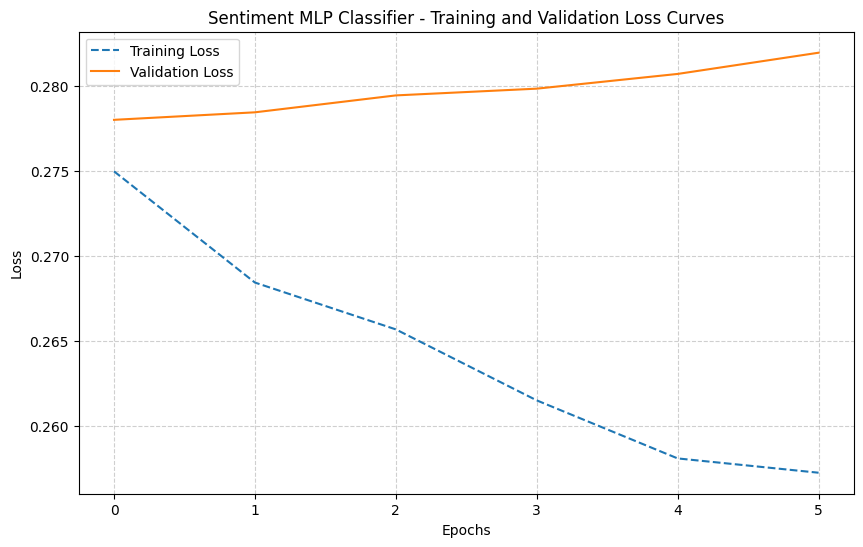


=== PER-CLASS METRICS ===
Class     Split     Precision   Recall      F1          PR-AUC      
-----------------------------------------------------------------
0         Train     0.9091        0.8992        0.9041        0.9663
0         Dev       0.8872        0.8817        0.8844        0.9559
0         Test      0.8783        0.8741        0.8762        0.9498
-----------------------------------------------------------------
1         Train     0.9007        0.9104        0.9055        0.9650
1         Dev       0.8814        0.8869        0.8841        0.9496
1         Test      0.8747        0.8789        0.8768        0.9470
-----------------------------------------------------------------

=== MACRO-AVERAGED METRICS ===
Split     Accuracy    Precision   Recall      F1          PR-AUC      
-----------------------------------------------------------------
Train     0.9048        0.9049        0.9048        0.9048        0.9656
Dev       0.8843        0.8843        0.8843      

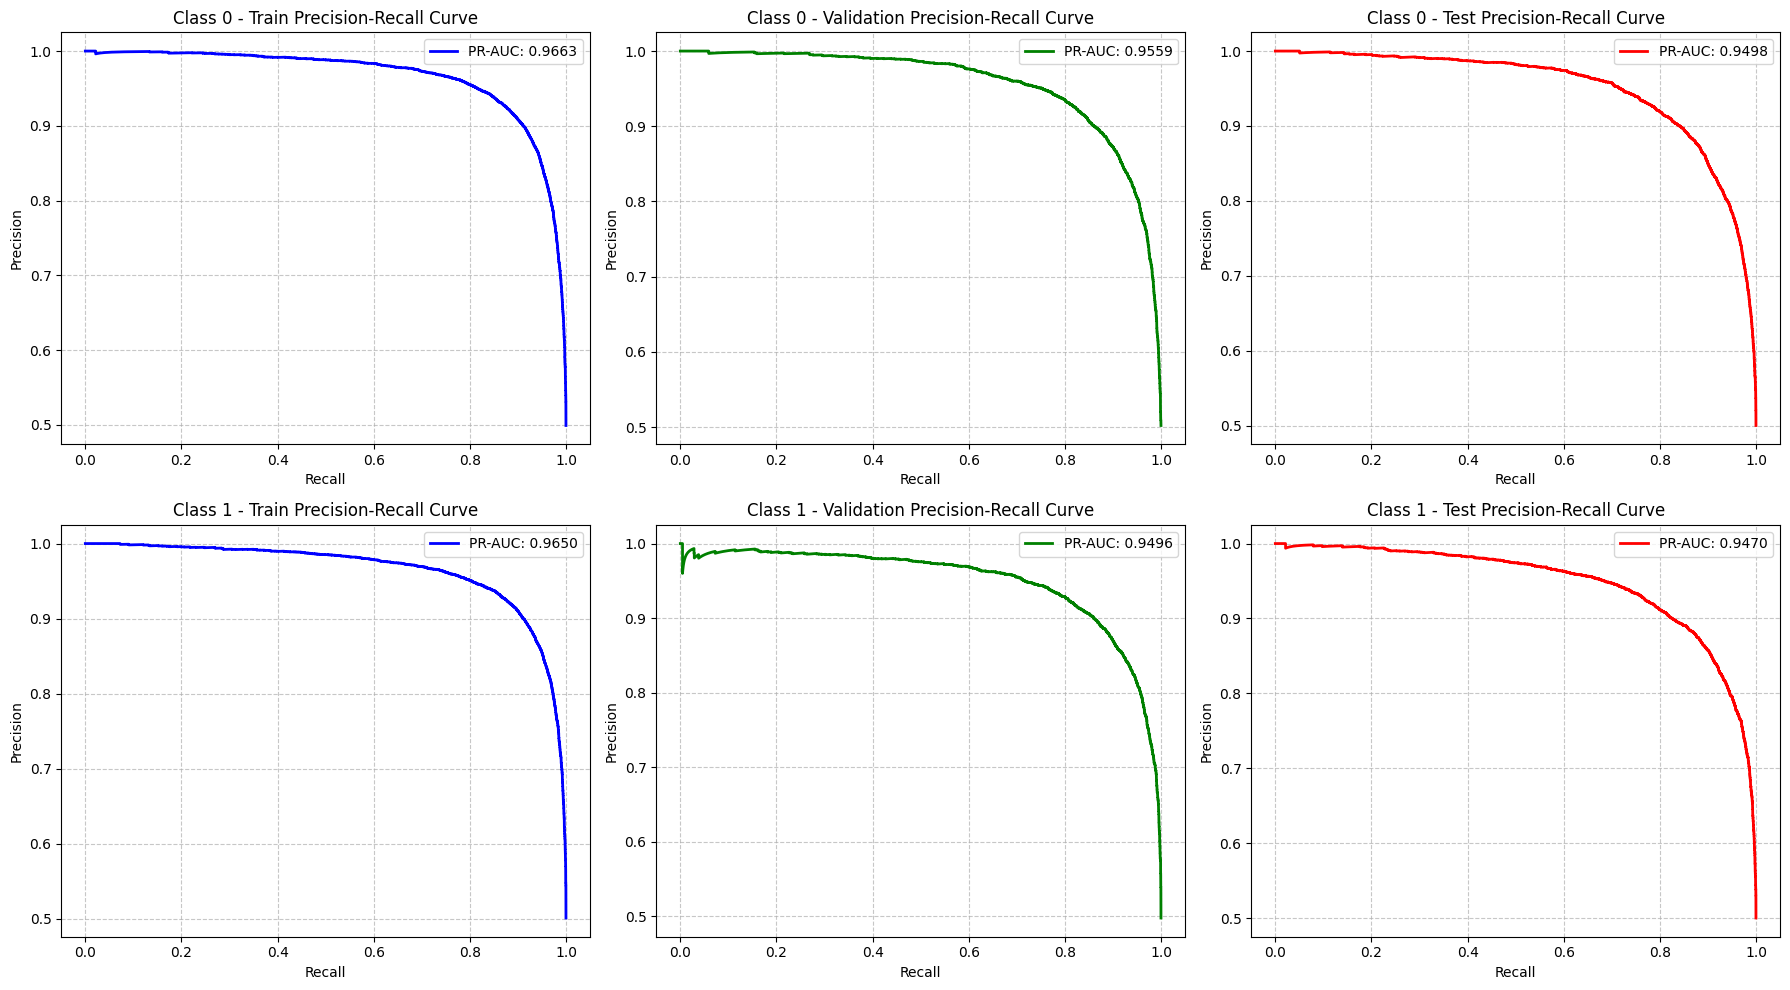

In [ ]:
# Plot loss curves
plot_loss_curves(train_losses, val_losses, title="Sentiment MLP Classifier")

# Get detailed evaluation metrics
all_metrics = evaluate_model_detailed(model, train_loader, val_loader, test_loader)

# # Store results for potential comparison with other models
# results = {
#     "model": model,
#     "train_losses": train_losses,
#     "val_losses": val_losses,
#     "all_metrics": all_metrics
# }

**Observations**:
  * The neural network model substantially outperforms the baseline, showing why more complex models are often worth the investment.
  * The model shows similar effecetiveness form both positive and negative sentiment detection, avoiding bias toward either class.
  * The reasonable gap between training and testing performance indicates the model learned meaningful patterns rather than just memorizing the training data.
  * High PR-AUC scores across all data splits suggest the model makes predictions with strong confidence.
  * The balanced precision and recall metrics show the model doesn't sacrifice one aspect of performance for another.


The neural network demonstrates clear advantages over the simples word-counting approach while maintaining consistent performance across different evaluation metrics. This confirms that the additional complexity of the MLP architecture translates to meaningful improvements in sentiment analysis accuracy.

In [ ]:
# Create the comparison structures
models_comparison = {
    'Baseline': baseline_metrics,
    'MLP Classifier': all_metrics
}

# Print comparison table for test set
print("\n=== MODEL COMPARISON (TEST SET) ===")
print(f"{'Model':<20}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1':<12}{'PR-AUC':<12}")
print("-" * 75)

for model_name, metrics in models_comparison.items():
    # Access test metrics based on the different structures
    if model_name == 'Baseline':
        test_metrics = metrics['test']
    else:  # MLP Classifier
        test_metrics = metrics['test']['macro']  # The MLP metrics have a nested 'macro' key

    print(f"{model_name:<20}{test_metrics['accuracy']:.4f}{' '*8}{test_metrics['macro_precision']:.4f}{' '*8}{test_metrics['macro_recall']:.4f}{' '*8}{test_metrics['macro_f1']:.4f}{' '*8}{test_metrics['macro_pr_auc']:.4f}")


=== MODEL COMPARISON (TEST SET) ===
Model               Accuracy    Precision   Recall      F1          PR-AUC      
---------------------------------------------------------------------------
Baseline            0.7767        0.7767        0.7767        0.7767        0.8325
MLP Classifier      0.8765        0.8765        0.8765        0.8765        0.9484


### Training using **Bag of Words** embeddings

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), feature_names, label_to_idx = preprocess_data(
    train_data, test_data, representation="bow"
)

In [ ]:
baseline_model = BaselineSentimentClassifier()
baseline_model.train(X_train, y_train, feature_names)

In [ ]:
baseline_metrics = evaluate_baseline(baseline_model, X_train, y_train, X_val, y_val, X_test, y_test)

print("\n=== BASELINE MODEL METRICS ===")
print(f"Accuracy: {baseline_metrics['test']['accuracy']:.4f}")
print(f"Macro F1: {baseline_metrics['test']['macro_f1']:.4f}")
print(f"Macro PR-AUC: {baseline_metrics['test']['macro_pr_auc']:.4f}")


=== BASELINE MODEL METRICS ===
Accuracy: 0.7766
Macro F1: 0.7766
Macro PR-AUC: 0.8325


In [ ]:
# Tune hyperparameters
best_model, best_params, tuning_results = hyperparameter_tuning(
    X_train, y_train, X_val, y_val, device=device
)

print(f"Best parameters: {best_params}")

Testing 216 hyperparameter combinations


Hyperparameter Tuning:   0%|          | 0/216 [00:00<?, ?it/s]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.47780, Val Loss: 0.32062
Epoch 6/10 - Train Loss: 0.23447, Val Loss: 0.32577


Hyperparameter Tuning:   0%|          | 1/216 [00:23<1:24:22, 23.55s/it]

New best model found! Validation loss: 0.34622

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35603, Val Loss: 0.30885
Epoch 6/10 - Train Loss: 0.03033, Val Loss: 0.72132


Hyperparameter Tuning:   1%|          | 2/216 [00:39<1:08:17, 19.15s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34521, Val Loss: 0.31817
Epoch 6/10 - Train Loss: 0.03738, Val Loss: 0.73267


Hyperparameter Tuning:   1%|▏         | 3/216 [00:56<1:03:33, 17.90s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.43306, Val Loss: 0.30669
Epoch 6/10 - Train Loss: 0.18868, Val Loss: 0.33629


Hyperparameter Tuning:   2%|▏         | 4/216 [01:12<1:01:21, 17.36s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34691, Val Loss: 0.30047
Epoch 6/10 - Train Loss: 0.01769, Val Loss: 0.98194


Hyperparameter Tuning:   2%|▏         | 5/216 [01:28<59:40, 16.97s/it]  


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34621, Val Loss: 0.31568
Epoch 6/10 - Train Loss: 0.02084, Val Loss: 0.88267


Hyperparameter Tuning:   3%|▎         | 6/216 [01:45<58:59, 16.85s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.39909, Val Loss: 0.31142
Epoch 6/10 - Train Loss: 0.10331, Val Loss: 0.37994


Hyperparameter Tuning:   3%|▎         | 7/216 [02:01<58:19, 16.74s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34226, Val Loss: 0.30172
Epoch 6/10 - Train Loss: 0.01286, Val Loss: 0.84336


Hyperparameter Tuning:   4%|▎         | 8/216 [02:18<58:15, 16.80s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35202, Val Loss: 0.31069
Epoch 6/10 - Train Loss: 0.02218, Val Loss: 0.91923


Hyperparameter Tuning:   4%|▍         | 9/216 [02:35<58:00, 16.82s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.43687, Val Loss: 0.30499
Epoch 6/10 - Train Loss: 0.18088, Val Loss: 0.34506


Hyperparameter Tuning:   5%|▍         | 10/216 [02:54<59:38, 17.37s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35194, Val Loss: 0.29739
Epoch 6/10 - Train Loss: 0.02491, Val Loss: 0.81682


Hyperparameter Tuning:   5%|▌         | 11/216 [03:12<59:41, 17.47s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35252, Val Loss: 0.31526
Epoch 6/10 - Train Loss: 0.02919, Val Loss: 0.82995


Hyperparameter Tuning:   6%|▌         | 12/216 [03:30<1:00:01, 17.65s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.51261, Val Loss: 0.33636
Epoch 6/10 - Train Loss: 0.23619, Val Loss: 0.30953


Hyperparameter Tuning:   6%|▌         | 13/216 [03:47<59:29, 17.59s/it]  

New best model found! Validation loss: 0.33309

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36029, Val Loss: 0.29490
Epoch 6/10 - Train Loss: 0.07602, Val Loss: 0.52177


Hyperparameter Tuning:   6%|▋         | 14/216 [04:04<58:37, 17.41s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35313, Val Loss: 0.30096
Epoch 6/10 - Train Loss: 0.08658, Val Loss: 0.52371


Hyperparameter Tuning:   7%|▋         | 15/216 [04:22<58:36, 17.50s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.45952, Val Loss: 0.31102
Epoch 6/10 - Train Loss: 0.20697, Val Loss: 0.31955


Hyperparameter Tuning:   7%|▋         | 16/216 [04:39<58:02, 17.41s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35650, Val Loss: 0.29884
Epoch 6/10 - Train Loss: 0.03843, Val Loss: 0.66641


Hyperparameter Tuning:   8%|▊         | 17/216 [04:57<58:03, 17.51s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36013, Val Loss: 0.31324
Epoch 6/10 - Train Loss: 0.06339, Val Loss: 0.59933


Hyperparameter Tuning:   8%|▊         | 18/216 [05:14<57:53, 17.54s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.42297, Val Loss: 0.32003
Epoch 6/10 - Train Loss: 0.13132, Val Loss: 0.35423


Hyperparameter Tuning:   9%|▉         | 19/216 [05:32<58:00, 17.67s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34834, Val Loss: 0.30884
Epoch 6/10 - Train Loss: 0.02318, Val Loss: 0.79588


Hyperparameter Tuning:   9%|▉         | 20/216 [05:50<57:38, 17.65s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36178, Val Loss: 0.31034
Epoch 6/10 - Train Loss: 0.05150, Val Loss: 0.84057


Hyperparameter Tuning:  10%|▉         | 21/216 [06:08<57:57, 17.83s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.47589, Val Loss: 0.31148
Epoch 6/10 - Train Loss: 0.18716, Val Loss: 0.32816


Hyperparameter Tuning:  10%|█         | 22/216 [06:27<58:49, 18.19s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36300, Val Loss: 0.30148
Epoch 6/10 - Train Loss: 0.04721, Val Loss: 0.60968


Hyperparameter Tuning:  11%|█         | 23/216 [06:47<59:45, 18.58s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36988, Val Loss: 0.31645
Epoch 6/10 - Train Loss: 0.06200, Val Loss: 0.58157


Hyperparameter Tuning:  11%|█         | 24/216 [07:06<1:00:12, 18.81s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.59617, Val Loss: 0.40424
Epoch 6/10 - Train Loss: 0.25701, Val Loss: 0.29344


Hyperparameter Tuning:  12%|█▏        | 25/216 [07:24<58:37, 18.41s/it]  

New best model found! Validation loss: 0.31251

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.39377, Val Loss: 0.29949
Epoch 6/10 - Train Loss: 0.16546, Val Loss: 0.38252


Hyperparameter Tuning:  12%|█▏        | 26/216 [07:41<57:06, 18.04s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.39274, Val Loss: 0.31063
Epoch 6/10 - Train Loss: 0.20794, Val Loss: 0.36148


Hyperparameter Tuning:  12%|█▎        | 27/216 [07:59<56:49, 18.04s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.55131, Val Loss: 0.34524
Epoch 6/10 - Train Loss: 0.22528, Val Loss: 0.30208


Hyperparameter Tuning:  13%|█▎        | 28/216 [08:16<55:43, 17.78s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37788, Val Loss: 0.29565
Epoch 6/10 - Train Loss: 0.11533, Val Loss: 0.42445


Hyperparameter Tuning:  13%|█▎        | 29/216 [08:33<55:10, 17.70s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38764, Val Loss: 0.30971
Epoch 6/10 - Train Loss: 0.17081, Val Loss: 0.42897


Hyperparameter Tuning:  14%|█▍        | 30/216 [08:51<55:07, 17.78s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.48637, Val Loss: 0.31651
Epoch 6/10 - Train Loss: 0.18622, Val Loss: 0.32028


Hyperparameter Tuning:  14%|█▍        | 31/216 [09:09<54:39, 17.73s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36271, Val Loss: 0.29904
Epoch 6/10 - Train Loss: 0.08023, Val Loss: 0.47158


Hyperparameter Tuning:  15%|█▍        | 32/216 [09:27<54:34, 17.80s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38956, Val Loss: 0.31298
Epoch 6/10 - Train Loss: 0.18613, Val Loss: 0.35047


Hyperparameter Tuning:  15%|█▌        | 33/216 [09:45<54:26, 17.85s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.60098, Val Loss: 0.36441
Epoch 6/10 - Train Loss: 0.23039, Val Loss: 0.30651


Hyperparameter Tuning:  16%|█▌        | 34/216 [10:04<55:31, 18.31s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.39799, Val Loss: 0.30048
Epoch 6/10 - Train Loss: 0.13944, Val Loss: 0.40821


Hyperparameter Tuning:  16%|█▌        | 35/216 [10:24<56:17, 18.66s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.42476, Val Loss: 0.30921
Epoch 6/10 - Train Loss: 0.21100, Val Loss: 0.36936


Hyperparameter Tuning:  17%|█▋        | 36/216 [10:43<56:38, 18.88s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.55739, Val Loss: 0.36801
Epoch 6/10 - Train Loss: 0.24478, Val Loss: 0.31374


Hyperparameter Tuning:  17%|█▋        | 37/216 [10:53<48:02, 16.11s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36282, Val Loss: 0.30976
Epoch 6/10 - Train Loss: 0.06077, Val Loss: 0.56361


Hyperparameter Tuning:  18%|█▊        | 38/216 [11:02<41:57, 14.14s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34909, Val Loss: 0.30234
Epoch 6/10 - Train Loss: 0.04278, Val Loss: 0.69625


Hyperparameter Tuning:  18%|█▊        | 39/216 [11:12<37:44, 12.79s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49652, Val Loss: 0.32359
Epoch 6/10 - Train Loss: 0.22360, Val Loss: 0.32351


Hyperparameter Tuning:  19%|█▊        | 40/216 [11:21<34:20, 11.71s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36096, Val Loss: 0.30932
Epoch 6/10 - Train Loss: 0.01015, Val Loss: 0.85823


Hyperparameter Tuning:  19%|█▉        | 41/216 [11:31<32:18, 11.08s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34640, Val Loss: 0.30872
Epoch 6/10 - Train Loss: 0.02644, Val Loss: 0.70941


Hyperparameter Tuning:  19%|█▉        | 42/216 [11:41<31:01, 10.70s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.44634, Val Loss: 0.31124
Epoch 6/10 - Train Loss: 0.16912, Val Loss: 0.34566


Hyperparameter Tuning:  20%|█▉        | 43/216 [11:50<30:06, 10.44s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35191, Val Loss: 0.29812
Epoch 6/10 - Train Loss: 0.01174, Val Loss: 0.86428


Hyperparameter Tuning:  20%|██        | 44/216 [12:00<29:20, 10.23s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35020, Val Loss: 0.30397
Epoch 6/10 - Train Loss: 0.01765, Val Loss: 1.00781


Hyperparameter Tuning:  21%|██        | 45/216 [12:10<28:28,  9.99s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.50442, Val Loss: 0.31736
Epoch 6/10 - Train Loss: 0.21763, Val Loss: 0.33093


Hyperparameter Tuning:  21%|██▏       | 46/216 [12:20<28:32, 10.07s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36453, Val Loss: 0.33532
Epoch 6/10 - Train Loss: 0.02632, Val Loss: 0.96496


Hyperparameter Tuning:  22%|██▏       | 47/216 [12:30<28:33, 10.14s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34884, Val Loss: 0.31042
Epoch 6/10 - Train Loss: 0.02507, Val Loss: 0.95953


Hyperparameter Tuning:  22%|██▏       | 48/216 [12:41<28:33, 10.20s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.58631, Val Loss: 0.40683
Epoch 6/10 - Train Loss: 0.25596, Val Loss: 0.30465


Hyperparameter Tuning:  23%|██▎       | 49/216 [12:51<28:17, 10.17s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37614, Val Loss: 0.29606
Epoch 6/10 - Train Loss: 0.07864, Val Loss: 0.46996


Hyperparameter Tuning:  23%|██▎       | 50/216 [13:01<27:59, 10.12s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35694, Val Loss: 0.31371
Epoch 6/10 - Train Loss: 0.08121, Val Loss: 0.50575


Hyperparameter Tuning:  24%|██▎       | 51/216 [13:10<27:33, 10.02s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.51971, Val Loss: 0.33242
Epoch 6/10 - Train Loss: 0.23928, Val Loss: 0.31299


Hyperparameter Tuning:  24%|██▍       | 52/216 [13:20<27:26, 10.04s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36099, Val Loss: 0.29665
Epoch 6/10 - Train Loss: 0.05137, Val Loss: 0.59576


Hyperparameter Tuning:  25%|██▍       | 53/216 [13:31<27:18, 10.05s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35630, Val Loss: 0.30253
Epoch 6/10 - Train Loss: 0.06436, Val Loss: 0.56283


Hyperparameter Tuning:  25%|██▌       | 54/216 [13:41<27:17, 10.11s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.47156, Val Loss: 0.31706
Epoch 6/10 - Train Loss: 0.18319, Val Loss: 0.32940


Hyperparameter Tuning:  25%|██▌       | 55/216 [13:51<27:16, 10.17s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35639, Val Loss: 0.29625
Epoch 6/10 - Train Loss: 0.02575, Val Loss: 0.72317


Hyperparameter Tuning:  26%|██▌       | 56/216 [14:01<27:01, 10.14s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35385, Val Loss: 0.32062
Epoch 6/10 - Train Loss: 0.03942, Val Loss: 0.66515


Hyperparameter Tuning:  26%|██▋       | 57/216 [14:11<26:46, 10.11s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.55610, Val Loss: 0.33887
Epoch 6/10 - Train Loss: 0.22774, Val Loss: 0.31765


Hyperparameter Tuning:  27%|██▋       | 58/216 [14:22<27:23, 10.40s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37263, Val Loss: 0.30278
Epoch 6/10 - Train Loss: 0.05625, Val Loss: 0.68302


Hyperparameter Tuning:  27%|██▋       | 59/216 [14:33<27:46, 10.61s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36188, Val Loss: 0.31073
Epoch 6/10 - Train Loss: 0.05783, Val Loss: 0.48864


Hyperparameter Tuning:  28%|██▊       | 60/216 [14:45<28:03, 10.79s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65536, Val Loss: 0.51861
Epoch 6/10 - Train Loss: 0.28059, Val Loss: 0.29073


Hyperparameter Tuning:  28%|██▊       | 61/216 [14:55<27:19, 10.58s/it]

New best model found! Validation loss: 0.29738

Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.41833, Val Loss: 0.29524
Epoch 6/10 - Train Loss: 0.17484, Val Loss: 0.34947


Hyperparameter Tuning:  29%|██▊       | 62/216 [15:05<26:43, 10.41s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.39181, Val Loss: 0.30642
Epoch 6/10 - Train Loss: 0.19571, Val Loss: 0.33954


Hyperparameter Tuning:  29%|██▉       | 63/216 [15:15<26:20, 10.33s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.59918, Val Loss: 0.40671
Epoch 6/10 - Train Loss: 0.25074, Val Loss: 0.29665


Hyperparameter Tuning:  30%|██▉       | 64/216 [15:24<25:33, 10.09s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.39014, Val Loss: 0.29843
Epoch 6/10 - Train Loss: 0.11929, Val Loss: 0.40474


Hyperparameter Tuning:  30%|███       | 65/216 [15:34<25:22, 10.08s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37415, Val Loss: 0.30180
Epoch 6/10 - Train Loss: 0.15258, Val Loss: 0.41812


Hyperparameter Tuning:  31%|███       | 66/216 [15:45<25:23, 10.15s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53793, Val Loss: 0.33582
Epoch 6/10 - Train Loss: 0.21495, Val Loss: 0.30493


Hyperparameter Tuning:  31%|███       | 67/216 [15:55<25:17, 10.19s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37013, Val Loss: 0.29592
Epoch 6/10 - Train Loss: 0.07529, Val Loss: 0.47448


Hyperparameter Tuning:  31%|███▏      | 68/216 [16:05<25:12, 10.22s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37482, Val Loss: 0.31234
Epoch 6/10 - Train Loss: 0.13028, Val Loss: 0.43880


Hyperparameter Tuning:  32%|███▏      | 69/216 [16:16<25:13, 10.30s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65644, Val Loss: 0.48783
Epoch 6/10 - Train Loss: 0.25905, Val Loss: 0.29922


Hyperparameter Tuning:  32%|███▏      | 70/216 [16:27<25:36, 10.52s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.42368, Val Loss: 0.30059
Epoch 6/10 - Train Loss: 0.13947, Val Loss: 0.37945


Hyperparameter Tuning:  33%|███▎      | 71/216 [16:38<25:41, 10.63s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.40156, Val Loss: 0.31003
Epoch 6/10 - Train Loss: 0.17753, Val Loss: 0.38629


Hyperparameter Tuning:  33%|███▎      | 72/216 [16:49<25:57, 10.81s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62426, Val Loss: 0.49518
Epoch 6/10 - Train Loss: 0.25250, Val Loss: 0.30608


Hyperparameter Tuning:  34%|███▍      | 73/216 [16:55<22:38,  9.50s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37922, Val Loss: 0.30953
Epoch 6/10 - Train Loss: 0.11375, Val Loss: 0.44404


Hyperparameter Tuning:  34%|███▍      | 74/216 [17:01<19:53,  8.40s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34619, Val Loss: 0.29937
Epoch 6/10 - Train Loss: 0.04071, Val Loss: 0.73799


Hyperparameter Tuning:  35%|███▍      | 75/216 [17:08<18:21,  7.81s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.57136, Val Loss: 0.38477
Epoch 6/10 - Train Loss: 0.23900, Val Loss: 0.31597


Hyperparameter Tuning:  35%|███▌      | 76/216 [17:14<16:52,  7.23s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36829, Val Loss: 0.31826
Epoch 6/10 - Train Loss: 0.01495, Val Loss: 0.66792


Hyperparameter Tuning:  36%|███▌      | 77/216 [17:20<16:13,  7.00s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35080, Val Loss: 0.29737
Epoch 6/10 - Train Loss: 0.03406, Val Loss: 0.78461


Hyperparameter Tuning:  36%|███▌      | 78/216 [17:26<15:20,  6.67s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.51328, Val Loss: 0.33084
Epoch 6/10 - Train Loss: 0.20794, Val Loss: 0.33250


Hyperparameter Tuning:  37%|███▋      | 79/216 [17:32<15:06,  6.62s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36210, Val Loss: 0.30621
Epoch 6/10 - Train Loss: 0.00264, Val Loss: 0.76662


Hyperparameter Tuning:  37%|███▋      | 80/216 [17:39<14:39,  6.47s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35111, Val Loss: 0.32281
Epoch 6/10 - Train Loss: 0.01649, Val Loss: 0.94269


Hyperparameter Tuning:  38%|███▊      | 81/216 [17:45<14:37,  6.50s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.58570, Val Loss: 0.38119
Epoch 6/10 - Train Loss: 0.23207, Val Loss: 0.31889


Hyperparameter Tuning:  38%|███▊      | 82/216 [17:52<14:37,  6.55s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37642, Val Loss: 0.31379
Epoch 6/10 - Train Loss: 0.02702, Val Loss: 0.66455


Hyperparameter Tuning:  38%|███▊      | 83/216 [17:58<14:28,  6.53s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34918, Val Loss: 0.29858
Epoch 6/10 - Train Loss: 0.03770, Val Loss: 0.69825


Hyperparameter Tuning:  39%|███▉      | 84/216 [18:05<14:36,  6.64s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.64589, Val Loss: 0.53786
Epoch 6/10 - Train Loss: 0.27228, Val Loss: 0.30358


Hyperparameter Tuning:  39%|███▉      | 85/216 [18:12<14:19,  6.56s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.40209, Val Loss: 0.30126
Epoch 6/10 - Train Loss: 0.09476, Val Loss: 0.45012


Hyperparameter Tuning:  40%|███▉      | 86/216 [18:18<14:23,  6.64s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35768, Val Loss: 0.30388
Epoch 6/10 - Train Loss: 0.08361, Val Loss: 0.51450


Hyperparameter Tuning:  40%|████      | 87/216 [18:25<14:10,  6.59s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.59518, Val Loss: 0.41914
Epoch 6/10 - Train Loss: 0.25009, Val Loss: 0.31063


Hyperparameter Tuning:  41%|████      | 88/216 [18:32<14:11,  6.65s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38583, Val Loss: 0.29792
Epoch 6/10 - Train Loss: 0.05304, Val Loss: 0.53813


Hyperparameter Tuning:  41%|████      | 89/216 [18:38<13:46,  6.51s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35335, Val Loss: 0.30231
Epoch 6/10 - Train Loss: 0.06104, Val Loss: 0.57624


Hyperparameter Tuning:  42%|████▏     | 90/216 [18:45<13:51,  6.60s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.54862, Val Loss: 0.34589
Epoch 6/10 - Train Loss: 0.22465, Val Loss: 0.31875


Hyperparameter Tuning:  42%|████▏     | 91/216 [18:51<13:33,  6.51s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36530, Val Loss: 0.29647
Epoch 6/10 - Train Loss: 0.02444, Val Loss: 0.64440


Hyperparameter Tuning:  43%|████▎     | 92/216 [18:58<13:39,  6.61s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35298, Val Loss: 0.30543
Epoch 6/10 - Train Loss: 0.04615, Val Loss: 0.64918


Hyperparameter Tuning:  43%|████▎     | 93/216 [19:04<13:30,  6.59s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63123, Val Loss: 0.44526
Epoch 6/10 - Train Loss: 0.25265, Val Loss: 0.31232


Hyperparameter Tuning:  44%|████▎     | 94/216 [19:11<13:40,  6.73s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.40069, Val Loss: 0.29880
Epoch 6/10 - Train Loss: 0.07684, Val Loss: 0.52439


Hyperparameter Tuning:  44%|████▍     | 95/216 [19:19<13:53,  6.89s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36629, Val Loss: 0.32045
Epoch 6/10 - Train Loss: 0.05888, Val Loss: 0.61025


Hyperparameter Tuning:  44%|████▍     | 96/216 [19:25<13:39,  6.83s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67541, Val Loss: 0.62759
Epoch 6/10 - Train Loss: 0.31333, Val Loss: 0.30152


Hyperparameter Tuning:  45%|████▍     | 97/216 [19:32<13:28,  6.80s/it]

New best model found! Validation loss: 0.29468

Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.44057, Val Loss: 0.31176
Epoch 6/10 - Train Loss: 0.17433, Val Loss: 0.35455


Hyperparameter Tuning:  45%|████▌     | 98/216 [19:38<12:59,  6.60s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.39148, Val Loss: 0.30836
Epoch 6/10 - Train Loss: 0.18310, Val Loss: 0.34040


Hyperparameter Tuning:  46%|████▌     | 99/216 [19:45<12:59,  6.66s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65682, Val Loss: 0.55240
Epoch 6/10 - Train Loss: 0.27537, Val Loss: 0.29638


Hyperparameter Tuning:  46%|████▋     | 100/216 [19:51<12:37,  6.53s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.40753, Val Loss: 0.29883
Epoch 6/10 - Train Loss: 0.12037, Val Loss: 0.38955


Hyperparameter Tuning:  47%|████▋     | 101/216 [19:58<12:37,  6.59s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37915, Val Loss: 0.30344
Epoch 6/10 - Train Loss: 0.14411, Val Loss: 0.36961


Hyperparameter Tuning:  47%|████▋     | 102/216 [20:04<12:18,  6.48s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62346, Val Loss: 0.44097
Epoch 6/10 - Train Loss: 0.24706, Val Loss: 0.30099


Hyperparameter Tuning:  48%|████▊     | 103/216 [20:11<12:24,  6.59s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38965, Val Loss: 0.29692
Epoch 6/10 - Train Loss: 0.07952, Val Loss: 0.47167


Hyperparameter Tuning:  48%|████▊     | 104/216 [20:17<12:15,  6.57s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37474, Val Loss: 0.30323
Epoch 6/10 - Train Loss: 0.11294, Val Loss: 0.41327


Hyperparameter Tuning:  49%|████▊     | 105/216 [20:24<12:10,  6.58s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68251, Val Loss: 0.63753
Epoch 6/10 - Train Loss: 0.29012, Val Loss: 0.29770


Hyperparameter Tuning:  49%|████▉     | 106/216 [20:31<12:25,  6.77s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.44744, Val Loss: 0.29593
Epoch 6/10 - Train Loss: 0.14490, Val Loss: 0.39261


Hyperparameter Tuning:  50%|████▉     | 107/216 [20:38<12:13,  6.73s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.39839, Val Loss: 0.31776
Epoch 6/10 - Train Loss: 0.15535, Val Loss: 0.43116


Hyperparameter Tuning:  50%|█████     | 108/216 [20:45<12:25,  6.91s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.46118, Val Loss: 0.34256
Epoch 6/10 - Train Loss: 0.13238, Val Loss: 0.36367


Hyperparameter Tuning:  50%|█████     | 109/216 [21:04<18:46, 10.52s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35832, Val Loss: 0.30899
Epoch 6/10 - Train Loss: 0.09405, Val Loss: 0.45128


Hyperparameter Tuning:  51%|█████     | 110/216 [21:24<23:19, 13.21s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36185, Val Loss: 0.31428
Epoch 6/10 - Train Loss: 0.11733, Val Loss: 0.46032


Hyperparameter Tuning:  51%|█████▏    | 111/216 [21:43<26:16, 15.01s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.42590, Val Loss: 0.31080
Epoch 6/10 - Train Loss: 0.09171, Val Loss: 0.38123


Hyperparameter Tuning:  52%|█████▏    | 112/216 [22:02<28:11, 16.26s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35541, Val Loss: 0.30048
Epoch 6/10 - Train Loss: 0.08266, Val Loss: 0.48475


Hyperparameter Tuning:  52%|█████▏    | 113/216 [22:22<29:41, 17.30s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36198, Val Loss: 0.30581
Epoch 6/10 - Train Loss: 0.10080, Val Loss: 0.49357


Hyperparameter Tuning:  53%|█████▎    | 114/216 [22:41<30:20, 17.84s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.39296, Val Loss: 0.30064
Epoch 6/10 - Train Loss: 0.06409, Val Loss: 0.43792


Hyperparameter Tuning:  53%|█████▎    | 115/216 [23:01<31:03, 18.45s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36036, Val Loss: 0.29930
Epoch 6/10 - Train Loss: 0.08185, Val Loss: 0.52827


Hyperparameter Tuning:  54%|█████▎    | 116/216 [23:21<31:26, 18.87s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35954, Val Loss: 0.30617
Epoch 6/10 - Train Loss: 0.09194, Val Loss: 0.49898


Hyperparameter Tuning:  54%|█████▍    | 117/216 [23:40<31:20, 18.99s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.46352, Val Loss: 0.33669
Epoch 6/10 - Train Loss: 0.07813, Val Loss: 0.41832


Hyperparameter Tuning:  55%|█████▍    | 118/216 [24:03<32:47, 20.07s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36008, Val Loss: 0.31422
Epoch 6/10 - Train Loss: 0.09730, Val Loss: 0.47883


Hyperparameter Tuning:  55%|█████▌    | 119/216 [24:25<33:37, 20.80s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36442, Val Loss: 0.31082
Epoch 6/10 - Train Loss: 0.10272, Val Loss: 0.45848


Hyperparameter Tuning:  56%|█████▌    | 120/216 [24:48<34:06, 21.32s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53289, Val Loss: 0.38504
Epoch 6/10 - Train Loss: 0.20486, Val Loss: 0.33437


Hyperparameter Tuning:  56%|█████▌    | 121/216 [25:08<33:07, 20.92s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37575, Val Loss: 0.30292
Epoch 6/10 - Train Loss: 0.15878, Val Loss: 0.39572


Hyperparameter Tuning:  56%|█████▋    | 122/216 [25:28<32:33, 20.78s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37254, Val Loss: 0.30515
Epoch 6/10 - Train Loss: 0.16240, Val Loss: 0.38002


Hyperparameter Tuning:  57%|█████▋    | 123/216 [25:48<32:02, 20.67s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.46893, Val Loss: 0.32342
Epoch 6/10 - Train Loss: 0.17261, Val Loss: 0.33762


Hyperparameter Tuning:  57%|█████▋    | 124/216 [26:09<31:25, 20.50s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36397, Val Loss: 0.30130
Epoch 6/10 - Train Loss: 0.13807, Val Loss: 0.40766


Hyperparameter Tuning:  58%|█████▊    | 125/216 [26:29<31:08, 20.53s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36990, Val Loss: 0.31691
Epoch 6/10 - Train Loss: 0.13533, Val Loss: 0.41359


Hyperparameter Tuning:  58%|█████▊    | 126/216 [26:50<30:50, 20.57s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.43374, Val Loss: 0.30687
Epoch 6/10 - Train Loss: 0.13513, Val Loss: 0.36710


Hyperparameter Tuning:  59%|█████▉    | 127/216 [27:11<30:37, 20.64s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36310, Val Loss: 0.30201
Epoch 6/10 - Train Loss: 0.12253, Val Loss: 0.43065


Hyperparameter Tuning:  59%|█████▉    | 128/216 [27:31<30:16, 20.65s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36892, Val Loss: 0.30208
Epoch 6/10 - Train Loss: 0.12125, Val Loss: 0.40890


Hyperparameter Tuning:  60%|█████▉    | 129/216 [27:52<30:00, 20.70s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.52352, Val Loss: 0.37551
Epoch 6/10 - Train Loss: 0.19226, Val Loss: 0.32808


Hyperparameter Tuning:  60%|██████    | 130/216 [28:16<31:00, 21.64s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38135, Val Loss: 0.30449
Epoch 6/10 - Train Loss: 0.15355, Val Loss: 0.41408


Hyperparameter Tuning:  61%|██████    | 131/216 [28:40<31:43, 22.40s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37359, Val Loss: 0.30285
Epoch 6/10 - Train Loss: 0.14478, Val Loss: 0.37760


Hyperparameter Tuning:  61%|██████    | 132/216 [29:04<32:05, 22.93s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62324, Val Loss: 0.46044
Epoch 6/10 - Train Loss: 0.28659, Val Loss: 0.29274


Hyperparameter Tuning:  62%|██████▏   | 133/216 [29:25<30:45, 22.24s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.42825, Val Loss: 0.31048
Epoch 6/10 - Train Loss: 0.24785, Val Loss: 0.31552


Hyperparameter Tuning:  62%|██████▏   | 134/216 [29:45<29:26, 21.55s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.40858, Val Loss: 0.30180
Epoch 6/10 - Train Loss: 0.24505, Val Loss: 0.31287


Hyperparameter Tuning:  62%|██████▎   | 135/216 [30:05<28:40, 21.24s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.56640, Val Loss: 0.39782
Epoch 6/10 - Train Loss: 0.25946, Val Loss: 0.29485


Hyperparameter Tuning:  63%|██████▎   | 136/216 [30:26<28:06, 21.08s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.39682, Val Loss: 0.30353
Epoch 6/10 - Train Loss: 0.20797, Val Loss: 0.34156


Hyperparameter Tuning:  63%|██████▎   | 137/216 [30:46<27:25, 20.83s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38567, Val Loss: 0.31442
Epoch 6/10 - Train Loss: 0.20710, Val Loss: 0.32014


Hyperparameter Tuning:  64%|██████▍   | 138/216 [31:07<27:01, 20.79s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.52920, Val Loss: 0.34922
Epoch 6/10 - Train Loss: 0.22616, Val Loss: 0.30191


Hyperparameter Tuning:  64%|██████▍   | 139/216 [31:28<26:44, 20.84s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38229, Val Loss: 0.30162
Epoch 6/10 - Train Loss: 0.18153, Val Loss: 0.35653


Hyperparameter Tuning:  65%|██████▍   | 140/216 [31:49<26:24, 20.85s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38615, Val Loss: 0.30524
Epoch 6/10 - Train Loss: 0.17866, Val Loss: 0.36624


Hyperparameter Tuning:  65%|██████▌   | 141/216 [32:09<25:59, 20.80s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67246, Val Loss: 0.53561
Epoch 6/10 - Train Loss: 0.29005, Val Loss: 0.29223


Hyperparameter Tuning:  66%|██████▌   | 142/216 [32:34<26:56, 21.84s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.44017, Val Loss: 0.31525
Epoch 6/10 - Train Loss: 0.23787, Val Loss: 0.31309


Hyperparameter Tuning:  66%|██████▌   | 143/216 [32:58<27:25, 22.53s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.40900, Val Loss: 0.32177
Epoch 6/10 - Train Loss: 0.23119, Val Loss: 0.31426


Hyperparameter Tuning:  67%|██████▋   | 144/216 [33:22<27:36, 23.00s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.51542, Val Loss: 0.38335
Epoch 6/10 - Train Loss: 0.13249, Val Loss: 0.33579


Hyperparameter Tuning:  67%|██████▋   | 145/216 [33:33<22:59, 19.43s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35240, Val Loss: 0.30389
Epoch 6/10 - Train Loss: 0.06447, Val Loss: 0.50992


Hyperparameter Tuning:  68%|██████▊   | 146/216 [33:45<19:51, 17.03s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34637, Val Loss: 0.30154
Epoch 6/10 - Train Loss: 0.08265, Val Loss: 0.55062


Hyperparameter Tuning:  68%|██████▊   | 147/216 [33:56<17:37, 15.32s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.45258, Val Loss: 0.32695
Epoch 6/10 - Train Loss: 0.08499, Val Loss: 0.37881


Hyperparameter Tuning:  69%|██████▊   | 148/216 [34:07<15:57, 14.08s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34631, Val Loss: 0.30003
Epoch 6/10 - Train Loss: 0.05334, Val Loss: 0.54141


Hyperparameter Tuning:  69%|██████▉   | 149/216 [34:18<14:45, 13.21s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35026, Val Loss: 0.30413
Epoch 6/10 - Train Loss: 0.07407, Val Loss: 0.50577


Hyperparameter Tuning:  69%|██████▉   | 150/216 [34:29<13:53, 12.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.42295, Val Loss: 0.30573
Epoch 6/10 - Train Loss: 0.05491, Val Loss: 0.40224


Hyperparameter Tuning:  70%|██████▉   | 151/216 [34:41<13:14, 12.22s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34149, Val Loss: 0.29830
Epoch 6/10 - Train Loss: 0.04980, Val Loss: 0.56249


Hyperparameter Tuning:  70%|███████   | 152/216 [34:52<12:45, 11.96s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34945, Val Loss: 0.30500
Epoch 6/10 - Train Loss: 0.06411, Val Loss: 0.56697


Hyperparameter Tuning:  71%|███████   | 153/216 [35:03<12:21, 11.77s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.48727, Val Loss: 0.35601
Epoch 6/10 - Train Loss: 0.06347, Val Loss: 0.40678


Hyperparameter Tuning:  71%|███████▏  | 154/216 [35:16<12:26, 12.05s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35753, Val Loss: 0.30029
Epoch 6/10 - Train Loss: 0.05316, Val Loss: 0.53850


Hyperparameter Tuning:  72%|███████▏  | 155/216 [35:29<12:27, 12.25s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34933, Val Loss: 0.29606
Epoch 6/10 - Train Loss: 0.07160, Val Loss: 0.51739


Hyperparameter Tuning:  72%|███████▏  | 156/216 [35:42<12:23, 12.39s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.57920, Val Loss: 0.43741
Epoch 6/10 - Train Loss: 0.20791, Val Loss: 0.30338


Hyperparameter Tuning:  73%|███████▎  | 157/216 [35:53<11:58, 12.18s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36623, Val Loss: 0.29428
Epoch 6/10 - Train Loss: 0.12819, Val Loss: 0.39747


Hyperparameter Tuning:  73%|███████▎  | 158/216 [36:05<11:38, 12.04s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35791, Val Loss: 0.30080
Epoch 6/10 - Train Loss: 0.12659, Val Loss: 0.40668


Hyperparameter Tuning:  74%|███████▎  | 159/216 [36:17<11:18, 11.91s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.50776, Val Loss: 0.35136
Epoch 6/10 - Train Loss: 0.17093, Val Loss: 0.31603


Hyperparameter Tuning:  74%|███████▍  | 160/216 [36:28<11:02, 11.83s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36085, Val Loss: 0.29761
Epoch 6/10 - Train Loss: 0.10451, Val Loss: 0.44790


Hyperparameter Tuning:  75%|███████▍  | 161/216 [36:40<10:47, 11.78s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35208, Val Loss: 0.30301
Epoch 6/10 - Train Loss: 0.10406, Val Loss: 0.42266


Hyperparameter Tuning:  75%|███████▌  | 162/216 [36:51<10:33, 11.72s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.45271, Val Loss: 0.31779
Epoch 6/10 - Train Loss: 0.12989, Val Loss: 0.35531


Hyperparameter Tuning:  75%|███████▌  | 163/216 [37:03<10:22, 11.74s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35216, Val Loss: 0.30005
Epoch 6/10 - Train Loss: 0.09348, Val Loss: 0.50040


Hyperparameter Tuning:  76%|███████▌  | 164/216 [37:15<10:13, 11.79s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35043, Val Loss: 0.30372
Epoch 6/10 - Train Loss: 0.09016, Val Loss: 0.46975


Hyperparameter Tuning:  76%|███████▋  | 165/216 [37:27<10:03, 11.84s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.57080, Val Loss: 0.41476
Epoch 6/10 - Train Loss: 0.18482, Val Loss: 0.31645


Hyperparameter Tuning:  77%|███████▋  | 166/216 [37:41<10:22, 12.46s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37668, Val Loss: 0.30791
Epoch 6/10 - Train Loss: 0.12199, Val Loss: 0.40990


Hyperparameter Tuning:  77%|███████▋  | 167/216 [37:55<10:25, 12.77s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36063, Val Loss: 0.30523
Epoch 6/10 - Train Loss: 0.11278, Val Loss: 0.40724


Hyperparameter Tuning:  78%|███████▊  | 168/216 [38:08<10:20, 12.93s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63954, Val Loss: 0.52114
Epoch 6/10 - Train Loss: 0.28837, Val Loss: 0.28982


Hyperparameter Tuning:  78%|███████▊  | 169/216 [38:20<09:50, 12.57s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.42988, Val Loss: 0.30353
Epoch 6/10 - Train Loss: 0.22538, Val Loss: 0.31545


Hyperparameter Tuning:  79%|███████▊  | 170/216 [38:31<09:25, 12.29s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.40078, Val Loss: 0.30230
Epoch 6/10 - Train Loss: 0.21340, Val Loss: 0.31861


Hyperparameter Tuning:  79%|███████▉  | 171/216 [38:43<09:04, 12.10s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.60724, Val Loss: 0.44580
Epoch 6/10 - Train Loss: 0.25002, Val Loss: 0.28842


Hyperparameter Tuning:  80%|███████▉  | 172/216 [38:55<08:53, 12.13s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.39411, Val Loss: 0.30033
Epoch 6/10 - Train Loss: 0.17878, Val Loss: 0.34310


Hyperparameter Tuning:  80%|████████  | 173/216 [39:07<08:37, 12.04s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37789, Val Loss: 0.29961
Epoch 6/10 - Train Loss: 0.17634, Val Loss: 0.35187


Hyperparameter Tuning:  81%|████████  | 174/216 [39:19<08:22, 11.96s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.56758, Val Loss: 0.37637
Epoch 6/10 - Train Loss: 0.21739, Val Loss: 0.29593


Hyperparameter Tuning:  81%|████████  | 175/216 [39:31<08:09, 11.94s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37998, Val Loss: 0.29919
Epoch 6/10 - Train Loss: 0.14916, Val Loss: 0.37161


Hyperparameter Tuning:  81%|████████▏ | 176/216 [39:42<07:57, 11.93s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37121, Val Loss: 0.29698
Epoch 6/10 - Train Loss: 0.14683, Val Loss: 0.35901


Hyperparameter Tuning:  82%|████████▏ | 177/216 [39:54<07:45, 11.94s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.70205, Val Loss: 0.58296
Epoch 6/10 - Train Loss: 0.30436, Val Loss: 0.29034


Hyperparameter Tuning:  82%|████████▏ | 178/216 [40:08<07:52, 12.42s/it]

New best model found! Validation loss: 0.29393

Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.45215, Val Loss: 0.30505
Epoch 6/10 - Train Loss: 0.20812, Val Loss: 0.32716


Hyperparameter Tuning:  83%|████████▎ | 179/216 [40:22<07:52, 12.77s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.40678, Val Loss: 0.30722
Epoch 6/10 - Train Loss: 0.19943, Val Loss: 0.32926


Hyperparameter Tuning:  83%|████████▎ | 180/216 [40:35<07:48, 13.01s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53629, Val Loss: 0.42274
Epoch 6/10 - Train Loss: 0.16391, Val Loss: 0.31767


Hyperparameter Tuning:  84%|████████▍ | 181/216 [40:42<06:35, 11.29s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36113, Val Loss: 0.29682
Epoch 6/10 - Train Loss: 0.04669, Val Loss: 0.51636


Hyperparameter Tuning:  84%|████████▍ | 182/216 [40:49<05:37,  9.93s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34106, Val Loss: 0.29906
Epoch 6/10 - Train Loss: 0.06266, Val Loss: 0.59526


Hyperparameter Tuning:  85%|████████▍ | 183/216 [40:56<05:01,  9.12s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49399, Val Loss: 0.36552
Epoch 6/10 - Train Loss: 0.11046, Val Loss: 0.33585


Hyperparameter Tuning:  85%|████████▌ | 184/216 [41:03<04:27,  8.37s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34526, Val Loss: 0.29490
Epoch 6/10 - Train Loss: 0.03451, Val Loss: 0.54544


Hyperparameter Tuning:  86%|████████▌ | 185/216 [41:10<04:08,  8.02s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34188, Val Loss: 0.29531
Epoch 6/10 - Train Loss: 0.05420, Val Loss: 0.63066


Hyperparameter Tuning:  86%|████████▌ | 186/216 [41:17<03:48,  7.62s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.45259, Val Loss: 0.32584
Epoch 6/10 - Train Loss: 0.06385, Val Loss: 0.36626


Hyperparameter Tuning:  87%|████████▋ | 187/216 [41:24<03:37,  7.50s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34072, Val Loss: 0.29826
Epoch 6/10 - Train Loss: 0.02812, Val Loss: 0.58725


Hyperparameter Tuning:  87%|████████▋ | 188/216 [41:31<03:28,  7.45s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34021, Val Loss: 0.30591
Epoch 6/10 - Train Loss: 0.03774, Val Loss: 0.69850


Hyperparameter Tuning:  88%|████████▊ | 189/216 [41:38<03:15,  7.22s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.54937, Val Loss: 0.41841
Epoch 6/10 - Train Loss: 0.09686, Val Loss: 0.34425


Hyperparameter Tuning:  88%|████████▊ | 190/216 [41:46<03:13,  7.44s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35968, Val Loss: 0.29896
Epoch 6/10 - Train Loss: 0.04405, Val Loss: 0.60968


Hyperparameter Tuning:  88%|████████▊ | 191/216 [41:54<03:07,  7.50s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34524, Val Loss: 0.30376
Epoch 6/10 - Train Loss: 0.05611, Val Loss: 0.54378


Hyperparameter Tuning:  89%|████████▉ | 192/216 [42:02<03:02,  7.62s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.59196, Val Loss: 0.46710
Epoch 6/10 - Train Loss: 0.22337, Val Loss: 0.29107


Hyperparameter Tuning:  89%|████████▉ | 193/216 [42:09<02:54,  7.59s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38188, Val Loss: 0.29621
Epoch 6/10 - Train Loss: 0.11891, Val Loss: 0.41464


Hyperparameter Tuning:  90%|████████▉ | 194/216 [42:16<02:42,  7.37s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35241, Val Loss: 0.29612
Epoch 6/10 - Train Loss: 0.10809, Val Loss: 0.45856


Hyperparameter Tuning:  90%|█████████ | 195/216 [42:23<02:35,  7.40s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.56131, Val Loss: 0.41128
Epoch 6/10 - Train Loss: 0.18680, Val Loss: 0.30011


Hyperparameter Tuning:  91%|█████████ | 196/216 [42:31<02:27,  7.37s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36104, Val Loss: 0.29425
Epoch 6/10 - Train Loss: 0.08821, Val Loss: 0.50139


Hyperparameter Tuning:  91%|█████████ | 197/216 [42:38<02:19,  7.33s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34453, Val Loss: 0.29876
Epoch 6/10 - Train Loss: 0.08174, Val Loss: 0.49890


Hyperparameter Tuning:  92%|█████████▏| 198/216 [42:45<02:12,  7.38s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.50442, Val Loss: 0.34975
Epoch 6/10 - Train Loss: 0.14289, Val Loss: 0.32820


Hyperparameter Tuning:  92%|█████████▏| 199/216 [42:53<02:03,  7.27s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34992, Val Loss: 0.29129
Epoch 6/10 - Train Loss: 0.07303, Val Loss: 0.51660


Hyperparameter Tuning:  93%|█████████▎| 200/216 [43:00<01:57,  7.37s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34598, Val Loss: 0.30373
Epoch 6/10 - Train Loss: 0.06569, Val Loss: 0.56619


Hyperparameter Tuning:  93%|█████████▎| 201/216 [43:07<01:50,  7.36s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62194, Val Loss: 0.48062
Epoch 6/10 - Train Loss: 0.21773, Val Loss: 0.29628


Hyperparameter Tuning:  94%|█████████▎| 202/216 [43:15<01:45,  7.53s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38237, Val Loss: 0.30166
Epoch 6/10 - Train Loss: 0.10650, Val Loss: 0.46234


Hyperparameter Tuning:  94%|█████████▍| 203/216 [43:24<01:40,  7.75s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36024, Val Loss: 0.30027
Epoch 6/10 - Train Loss: 0.09443, Val Loss: 0.47042


Hyperparameter Tuning:  94%|█████████▍| 204/216 [43:32<01:34,  7.91s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67364, Val Loss: 0.56259
Epoch 6/10 - Train Loss: 0.31510, Val Loss: 0.29652


Hyperparameter Tuning:  95%|█████████▍| 205/216 [43:39<01:24,  7.66s/it]

New best model found! Validation loss: 0.28834

Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.44635, Val Loss: 0.30222
Epoch 6/10 - Train Loss: 0.20529, Val Loss: 0.32868


Hyperparameter Tuning:  95%|█████████▌| 206/216 [43:47<01:16,  7.62s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.39210, Val Loss: 0.30038
Epoch 6/10 - Train Loss: 0.19580, Val Loss: 0.33523


Hyperparameter Tuning:  96%|█████████▌| 207/216 [43:53<01:06,  7.41s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65617, Val Loss: 0.49332
Epoch 6/10 - Train Loss: 0.27468, Val Loss: 0.28778


Hyperparameter Tuning:  96%|█████████▋| 208/216 [44:01<00:59,  7.47s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.40750, Val Loss: 0.29294
Epoch 6/10 - Train Loss: 0.17352, Val Loss: 0.34455


Hyperparameter Tuning:  97%|█████████▋| 209/216 [44:09<00:52,  7.50s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37200, Val Loss: 0.30275
Epoch 6/10 - Train Loss: 0.15572, Val Loss: 0.37952


Hyperparameter Tuning:  97%|█████████▋| 210/216 [44:16<00:44,  7.35s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.59849, Val Loss: 0.43313
Epoch 6/10 - Train Loss: 0.23286, Val Loss: 0.29029


Hyperparameter Tuning:  98%|█████████▊| 211/216 [44:23<00:37,  7.42s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38264, Val Loss: 0.28986
Epoch 6/10 - Train Loss: 0.13405, Val Loss: 0.39123


Hyperparameter Tuning:  98%|█████████▊| 212/216 [44:30<00:29,  7.30s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36222, Val Loss: 0.30578
Epoch 6/10 - Train Loss: 0.11830, Val Loss: 0.42238


Hyperparameter Tuning:  99%|█████████▊| 213/216 [44:38<00:22,  7.36s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.70565, Val Loss: 0.62230
Epoch 6/10 - Train Loss: 0.33603, Val Loss: 0.30361


Hyperparameter Tuning:  99%|█████████▉| 214/216 [44:46<00:15,  7.65s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.47133, Val Loss: 0.31156
Epoch 6/10 - Train Loss: 0.19796, Val Loss: 0.33660


Hyperparameter Tuning: 100%|█████████▉| 215/216 [44:54<00:07,  7.70s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.41498, Val Loss: 0.29784
Epoch 6/10 - Train Loss: 0.17971, Val Loss: 0.34409


Hyperparameter Tuning: 100%|██████████| 216/216 [45:02<00:00, 12.51s/it]


Top 3 hyperparameter configurations:
1. Val Loss: 0.28834, Params: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
2. Val Loss: 0.29047, Params: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
3. Val Loss: 0.29369, Params: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Best parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}


In [ ]:
batch_size = best_params['batch_size']  # Use the best batch size

train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device), torch.LongTensor(y_train).to(device))
val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device), torch.LongTensor(y_val).to(device))
test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device), torch.LongTensor(y_test).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_dim = X_train.shape[1]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

# Train the model with the enhanced function
model, train_losses, val_losses = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,  # Added test_loader
    criterion=criterion,
    optimizer=optimizer,
    epochs=20,
    device=device,
    patience=5
)


Epoch 1/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 703.24it/s]


Epoch 1/20 - Train Loss: 0.24062, Val Loss: 0.29091
Model improved - saving to best_sentiment_mlp_model.pt


Epoch 2/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 698.49it/s]


Epoch 2/20 - Train Loss: 0.22777, Val Loss: 0.29575
Patience: 1/5


Epoch 3/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 723.73it/s]


Epoch 3/20 - Train Loss: 0.22069, Val Loss: 0.29786
Patience: 2/5


Epoch 4/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 723.65it/s]


Epoch 4/20 - Train Loss: 0.21893, Val Loss: 0.30230
Patience: 3/5


Epoch 5/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 644.96it/s]


Epoch 5/20 - Train Loss: 0.20739, Val Loss: 0.30541
Patience: 4/5


Epoch 6/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 716.32it/s]

Epoch 6/20 - Train Loss: 0.20004, Val Loss: 0.31030
Patience: 5/5
Early stopping after 6 epochs


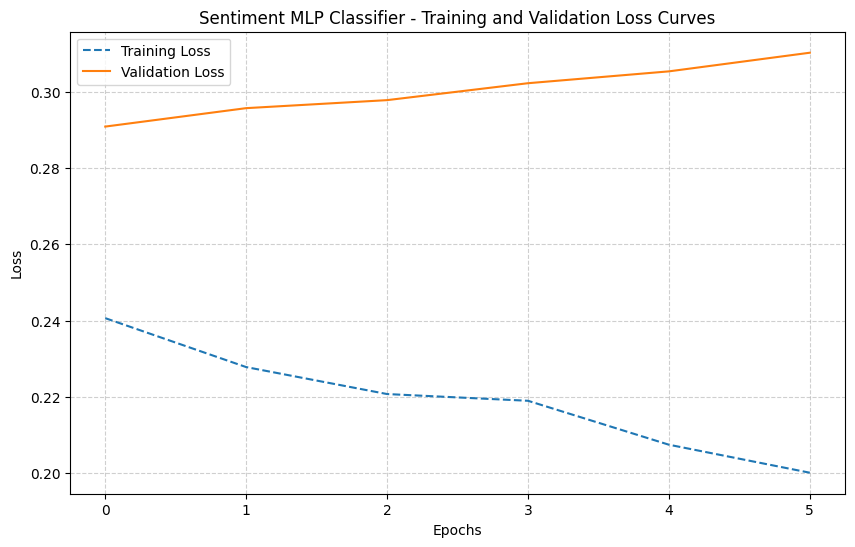


=== PER-CLASS METRICS ===
Class     Split     Precision   Recall      F1          PR-AUC      
-----------------------------------------------------------------
0         Train     0.9408        0.9378        0.9393        0.9850
0         Dev       0.8811        0.8843        0.8827        0.9507
0         Test      0.8710        0.8675        0.8692        0.9452
-----------------------------------------------------------------
1         Train     0.9382        0.9412        0.9397        0.9842
1         Dev       0.8829        0.8797        0.8813        0.9439
1         Test      0.8680        0.8715        0.8697        0.9425
-----------------------------------------------------------------

=== MACRO-AVERAGED METRICS ===
Split     Accuracy    Precision   Recall      F1          PR-AUC      
-----------------------------------------------------------------
Train     0.9395        0.9395        0.9395        0.9395        0.9846
Dev       0.8820        0.8820        0.8820      

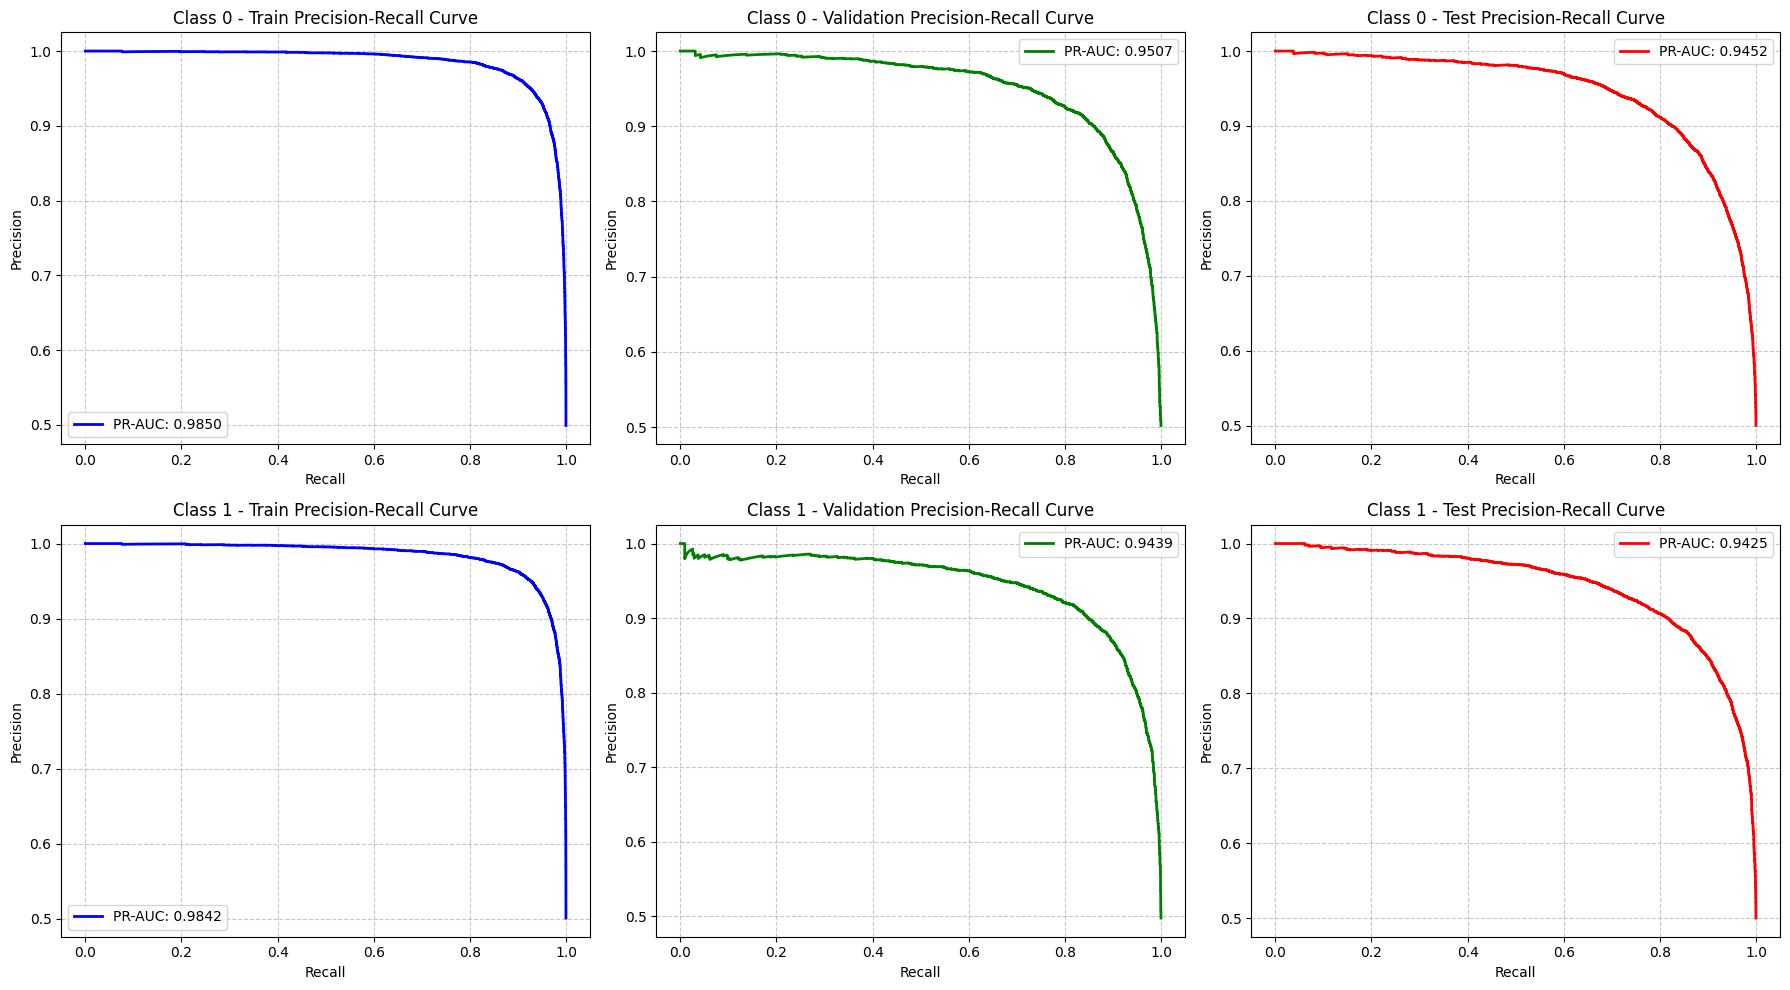

In [ ]:
# Plot loss curves
plot_loss_curves(train_losses, val_losses, title="Sentiment MLP Classifier")

# Get detailed evaluation metrics
all_metrics = evaluate_model_detailed(model, train_loader, val_loader, test_loader)


**Observations**: The `Bag of Words (BoW)` approach with the MLP classifier shows several interesting patterns:
  1. The model demonstrates excellent performance on the training data, suggesting it effectively captures the patters present in the training examples.
  2. There's a noticeable difference between training and test performance, indicating some degree of overfitting to the training data.
  3. Similar to the previous model, this approach maintains balances performance across both sentiment classes, showing no bias toward positive or negative sentiment detection.
  4. This BoW approach performs slightly better then the TfIdf vectorizer apporach, suggesting that the feature representation matters as much as the model architecture.

In [ ]:
# Create the comparison structures
models_comparison = {
    'Baseline': baseline_metrics,
    'MLP Classifier': all_metrics
}

# Print comparison table for test set
print("\n=== MODEL COMPARISON (TEST SET) ===")
print(f"{'Model':<20}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1':<12}{'PR-AUC':<12}")
print("-" * 75)

for model_name, metrics in models_comparison.items():
    # Access test metrics based on the different structures
    if model_name == 'Baseline':
        test_metrics = metrics['test']
    else:  # MLP Classifier
        test_metrics = metrics['test']['macro']  # The MLP metrics have a nested 'macro' key

    print(f"{model_name:<20}{test_metrics['accuracy']:.4f}{' '*8}{test_metrics['macro_precision']:.4f}{' '*8}{test_metrics['macro_recall']:.4f}{' '*8}{test_metrics['macro_f1']:.4f}{' '*8}{test_metrics['macro_pr_auc']:.4f}")



=== MODEL COMPARISON (TEST SET) ===
Model               Accuracy    Precision   Recall      F1          PR-AUC      
---------------------------------------------------------------------------
Baseline            0.7766        0.7766        0.7766        0.7766        0.8325
MLP Classifier      0.8695        0.8695        0.8695        0.8695        0.9439


### Training using **pre-trained word embeddings** embeddings

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), feature_names, label_to_idx = preprocess_data(
    train_data, test_data, representation="embeddings"
)


Loading pre-trained word embeddings...
[==================================================] 100.0% 128.1/128.1MB downloaded
Loaded 400000 word vectors with dimension 100
Processing training embeddings...
Processing validation embeddings...
Processing test embeddings...


In [ ]:
baseline_model = BaselineSentimentClassifier()
baseline_model.train(X_train, y_train, feature_names)

In [ ]:
baseline_metrics = evaluate_baseline(baseline_model, X_train, y_train, X_val, y_val, X_test, y_test)

print("\n=== BASELINE MODEL METRICS ===")
print(f"Accuracy: {baseline_metrics['test']['accuracy']:.4f}")
print(f"Macro F1: {baseline_metrics['test']['macro_f1']:.4f}")
print(f"Macro PR-AUC: {baseline_metrics['test']['macro_pr_auc']:.4f}")


=== BASELINE MODEL METRICS ===
Accuracy: 0.5031
Macro F1: 0.3411
Macro PR-AUC: 0.7225


In [ ]:
# Tune hyperparameters
best_model, best_params, tuning_results = hyperparameter_tuning(
    X_train, y_train, X_val, y_val, device=device
)

print(f"Best parameters: {best_params}")

Testing 216 hyperparameter combinations


Hyperparameter Tuning:   0%|          | 0/216 [00:00<?, ?it/s]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.64297, Val Loss: 0.56950
Epoch 6/10 - Train Loss: 0.45604, Val Loss: 0.45350


Hyperparameter Tuning:   0%|          | 1/216 [00:16<57:35, 16.07s/it]

New best model found! Validation loss: 0.44332

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.50240, Val Loss: 0.46124
Epoch 6/10 - Train Loss: 0.43453, Val Loss: 0.43579


Hyperparameter Tuning:   1%|          | 2/216 [00:31<56:43, 15.91s/it]

New best model found! Validation loss: 0.43167

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.49365, Val Loss: 0.44803
Epoch 6/10 - Train Loss: 0.43582, Val Loss: 0.43405


Hyperparameter Tuning:   1%|▏         | 3/216 [00:47<56:38, 15.96s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62053, Val Loss: 0.53264
Epoch 6/10 - Train Loss: 0.44771, Val Loss: 0.44615


Hyperparameter Tuning:   2%|▏         | 4/216 [01:04<56:40, 16.04s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.50932, Val Loss: 0.45366
Epoch 6/10 - Train Loss: 0.42851, Val Loss: 0.43155


Hyperparameter Tuning:   2%|▏         | 5/216 [01:19<56:05, 15.95s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.49329, Val Loss: 0.44896
Epoch 6/10 - Train Loss: 0.43962, Val Loss: 0.43319


Hyperparameter Tuning:   3%|▎         | 6/216 [01:35<55:38, 15.90s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.58052, Val Loss: 0.49127
Epoch 6/10 - Train Loss: 0.43955, Val Loss: 0.45525


Hyperparameter Tuning:   3%|▎         | 7/216 [01:52<56:14, 16.15s/it]

New best model found! Validation loss: 0.43125

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.49500, Val Loss: 0.45370
Epoch 6/10 - Train Loss: 0.42717, Val Loss: 0.42865


Hyperparameter Tuning:   4%|▎         | 8/216 [02:08<56:16, 16.23s/it]

New best model found! Validation loss: 0.42843

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.48967, Val Loss: 0.54333
Epoch 6/10 - Train Loss: 0.43824, Val Loss: 0.45960


Hyperparameter Tuning:   4%|▍         | 9/216 [02:25<56:16, 16.31s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.61389, Val Loss: 0.50917
Epoch 6/10 - Train Loss: 0.44529, Val Loss: 0.44068


Hyperparameter Tuning:   5%|▍         | 10/216 [02:42<57:33, 16.76s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.50416, Val Loss: 0.44577
Epoch 6/10 - Train Loss: 0.43258, Val Loss: 0.44438


Hyperparameter Tuning:   5%|▌         | 11/216 [03:00<57:59, 16.97s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.49298, Val Loss: 0.47104
Epoch 6/10 - Train Loss: 0.43842, Val Loss: 0.43558


Hyperparameter Tuning:   6%|▌         | 12/216 [03:18<58:37, 17.24s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66997, Val Loss: 0.61043
Epoch 6/10 - Train Loss: 0.47417, Val Loss: 0.45889


Hyperparameter Tuning:   6%|▌         | 13/216 [03:35<57:48, 17.08s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.52808, Val Loss: 0.45475
Epoch 6/10 - Train Loss: 0.44506, Val Loss: 0.44016


Hyperparameter Tuning:   6%|▋         | 14/216 [03:52<57:46, 17.16s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50818, Val Loss: 0.48714
Epoch 6/10 - Train Loss: 0.45814, Val Loss: 0.46713


Hyperparameter Tuning:   7%|▋         | 15/216 [04:09<57:19, 17.11s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63756, Val Loss: 0.54564
Epoch 6/10 - Train Loss: 0.45701, Val Loss: 0.44590


Hyperparameter Tuning:   7%|▋         | 16/216 [04:26<56:48, 17.04s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.50910, Val Loss: 0.46102
Epoch 6/10 - Train Loss: 0.43984, Val Loss: 0.43832


Hyperparameter Tuning:   8%|▊         | 17/216 [04:43<56:32, 17.05s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50308, Val Loss: 0.45037
Epoch 6/10 - Train Loss: 0.45702, Val Loss: 0.43495


Hyperparameter Tuning:   8%|▊         | 18/216 [05:00<56:15, 17.05s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.59706, Val Loss: 0.50009
Epoch 6/10 - Train Loss: 0.44570, Val Loss: 0.44436


Hyperparameter Tuning:   9%|▉         | 19/216 [05:18<56:52, 17.32s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.50064, Val Loss: 0.45411
Epoch 6/10 - Train Loss: 0.43906, Val Loss: 0.43111


Hyperparameter Tuning:   9%|▉         | 20/216 [05:35<56:43, 17.36s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.49925, Val Loss: 0.44958
Epoch 6/10 - Train Loss: 0.45391, Val Loss: 0.43800


Hyperparameter Tuning:  10%|▉         | 21/216 [05:53<57:00, 17.54s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.64079, Val Loss: 0.53274
Epoch 6/10 - Train Loss: 0.46079, Val Loss: 0.44416


Hyperparameter Tuning:  10%|█         | 22/216 [06:12<57:59, 17.94s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.51829, Val Loss: 0.47764
Epoch 6/10 - Train Loss: 0.44468, Val Loss: 0.44860


Hyperparameter Tuning:  11%|█         | 23/216 [06:32<59:09, 18.39s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.51734, Val Loss: 0.47276
Epoch 6/10 - Train Loss: 0.45816, Val Loss: 0.43682


Hyperparameter Tuning:  11%|█         | 24/216 [06:50<59:20, 18.54s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67929, Val Loss: 0.64342
Epoch 6/10 - Train Loss: 0.50563, Val Loss: 0.47471


Hyperparameter Tuning:  12%|█▏        | 25/216 [07:08<57:44, 18.14s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.56814, Val Loss: 0.47180
Epoch 6/10 - Train Loss: 0.46570, Val Loss: 0.44303


Hyperparameter Tuning:  12%|█▏        | 26/216 [07:24<56:09, 17.74s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.55311, Val Loss: 0.46600
Epoch 6/10 - Train Loss: 0.48965, Val Loss: 0.45512


Hyperparameter Tuning:  12%|█▎        | 27/216 [07:42<55:33, 17.64s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67014, Val Loss: 0.59863
Epoch 6/10 - Train Loss: 0.47972, Val Loss: 0.45452


Hyperparameter Tuning:  13%|█▎        | 28/216 [07:59<54:40, 17.45s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.53912, Val Loss: 0.45895
Epoch 6/10 - Train Loss: 0.45746, Val Loss: 0.43807


Hyperparameter Tuning:  13%|█▎        | 29/216 [08:16<54:07, 17.37s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.54570, Val Loss: 0.46296
Epoch 6/10 - Train Loss: 0.48683, Val Loss: 0.45336


Hyperparameter Tuning:  14%|█▍        | 30/216 [08:33<53:36, 17.29s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.64402, Val Loss: 0.54199
Epoch 6/10 - Train Loss: 0.46320, Val Loss: 0.44750


Hyperparameter Tuning:  14%|█▍        | 31/216 [08:51<53:28, 17.34s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.52550, Val Loss: 0.47092
Epoch 6/10 - Train Loss: 0.45616, Val Loss: 0.43482


Hyperparameter Tuning:  15%|█▍        | 32/216 [09:09<53:49, 17.55s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.53151, Val Loss: 0.46774
Epoch 6/10 - Train Loss: 0.48010, Val Loss: 0.45502


Hyperparameter Tuning:  15%|█▌        | 33/216 [09:26<53:25, 17.52s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68847, Val Loss: 0.66406
Epoch 6/10 - Train Loss: 0.49539, Val Loss: 0.46392


Hyperparameter Tuning:  16%|█▌        | 34/216 [09:45<54:49, 18.08s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.56888, Val Loss: 0.46868
Epoch 6/10 - Train Loss: 0.46951, Val Loss: 0.44292


Hyperparameter Tuning:  16%|█▌        | 35/216 [10:05<55:33, 18.42s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.56556, Val Loss: 0.47217
Epoch 6/10 - Train Loss: 0.50130, Val Loss: 0.47270


Hyperparameter Tuning:  17%|█▋        | 36/216 [10:24<56:02, 18.68s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68523, Val Loss: 0.65473
Epoch 6/10 - Train Loss: 0.46962, Val Loss: 0.46517


Hyperparameter Tuning:  17%|█▋        | 37/216 [10:33<47:25, 15.89s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.52260, Val Loss: 0.49126
Epoch 6/10 - Train Loss: 0.43544, Val Loss: 0.43155


Hyperparameter Tuning:  18%|█▊        | 38/216 [10:43<41:25, 13.97s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.49783, Val Loss: 0.45239
Epoch 6/10 - Train Loss: 0.44175, Val Loss: 0.44012


Hyperparameter Tuning:  18%|█▊        | 39/216 [10:52<36:43, 12.45s/it]

New best model found! Validation loss: 0.42790

Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65187, Val Loss: 0.58007
Epoch 6/10 - Train Loss: 0.45300, Val Loss: 0.44859


Hyperparameter Tuning:  19%|█▊        | 40/216 [11:01<33:56, 11.57s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.51353, Val Loss: 0.45128
Epoch 6/10 - Train Loss: 0.43218, Val Loss: 0.43280


Hyperparameter Tuning:  19%|█▉        | 41/216 [11:11<31:53, 10.93s/it]

New best model found! Validation loss: 0.42488

Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.49998, Val Loss: 0.45198
Epoch 6/10 - Train Loss: 0.43742, Val Loss: 0.43052


Hyperparameter Tuning:  19%|█▉        | 42/216 [11:20<30:20, 10.46s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62184, Val Loss: 0.53220
Epoch 6/10 - Train Loss: 0.44422, Val Loss: 0.44374


Hyperparameter Tuning:  20%|█▉        | 43/216 [11:29<28:59, 10.06s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.50562, Val Loss: 0.45723
Epoch 6/10 - Train Loss: 0.43001, Val Loss: 0.43483


Hyperparameter Tuning:  20%|██        | 44/216 [11:39<28:29,  9.94s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.49881, Val Loss: 0.44703
Epoch 6/10 - Train Loss: 0.43586, Val Loss: 0.42954


Hyperparameter Tuning:  21%|██        | 45/216 [11:49<28:07,  9.87s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66548, Val Loss: 0.59283
Epoch 6/10 - Train Loss: 0.45302, Val Loss: 0.45321


Hyperparameter Tuning:  21%|██▏       | 46/216 [11:59<28:16,  9.98s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.51545, Val Loss: 0.45261
Epoch 6/10 - Train Loss: 0.43209, Val Loss: 0.42933


Hyperparameter Tuning:  22%|██▏       | 47/216 [12:09<28:23, 10.08s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50306, Val Loss: 0.46237
Epoch 6/10 - Train Loss: 0.43487, Val Loss: 0.43281


Hyperparameter Tuning:  22%|██▏       | 48/216 [12:19<28:18, 10.11s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68499, Val Loss: 0.66641
Epoch 6/10 - Train Loss: 0.48899, Val Loss: 0.46929


Hyperparameter Tuning:  23%|██▎       | 49/216 [12:29<27:42,  9.96s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.54864, Val Loss: 0.46471
Epoch 6/10 - Train Loss: 0.44514, Val Loss: 0.43519


Hyperparameter Tuning:  23%|██▎       | 50/216 [12:39<27:36,  9.98s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.51572, Val Loss: 0.48263
Epoch 6/10 - Train Loss: 0.45344, Val Loss: 0.44249


Hyperparameter Tuning:  24%|██▎       | 51/216 [12:49<27:27,  9.98s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66596, Val Loss: 0.60197
Epoch 6/10 - Train Loss: 0.46511, Val Loss: 0.45310


Hyperparameter Tuning:  24%|██▍       | 52/216 [12:59<27:21, 10.01s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.52837, Val Loss: 0.45354
Epoch 6/10 - Train Loss: 0.43757, Val Loss: 0.43779


Hyperparameter Tuning:  25%|██▍       | 53/216 [13:09<27:11, 10.01s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50231, Val Loss: 0.45116
Epoch 6/10 - Train Loss: 0.45122, Val Loss: 0.43325


Hyperparameter Tuning:  25%|██▌       | 54/216 [13:18<26:37,  9.86s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63421, Val Loss: 0.54119
Epoch 6/10 - Train Loss: 0.45181, Val Loss: 0.44251


Hyperparameter Tuning:  25%|██▌       | 55/216 [13:29<26:45,  9.97s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.51349, Val Loss: 0.45710
Epoch 6/10 - Train Loss: 0.43800, Val Loss: 0.45297


Hyperparameter Tuning:  26%|██▌       | 56/216 [13:39<26:51, 10.07s/it]

New best model found! Validation loss: 0.42444

Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50824, Val Loss: 0.45011
Epoch 6/10 - Train Loss: 0.44610, Val Loss: 0.43723


Hyperparameter Tuning:  26%|██▋       | 57/216 [13:49<26:52, 10.14s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67211, Val Loss: 0.60377
Epoch 6/10 - Train Loss: 0.46452, Val Loss: 0.44867


Hyperparameter Tuning:  27%|██▋       | 58/216 [14:01<27:35, 10.48s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.54022, Val Loss: 0.47171
Epoch 6/10 - Train Loss: 0.44248, Val Loss: 0.44654


Hyperparameter Tuning:  27%|██▋       | 59/216 [14:12<27:50, 10.64s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.52272, Val Loss: 0.46476
Epoch 6/10 - Train Loss: 0.45357, Val Loss: 0.44862


Hyperparameter Tuning:  28%|██▊       | 60/216 [14:23<28:00, 10.77s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68997, Val Loss: 0.67718
Epoch 6/10 - Train Loss: 0.52453, Val Loss: 0.49275


Hyperparameter Tuning:  28%|██▊       | 61/216 [14:33<27:07, 10.50s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.58084, Val Loss: 0.47212
Epoch 6/10 - Train Loss: 0.46613, Val Loss: 0.44233


Hyperparameter Tuning:  29%|██▊       | 62/216 [14:42<26:14, 10.22s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.55158, Val Loss: 0.47183
Epoch 6/10 - Train Loss: 0.48753, Val Loss: 0.44878


Hyperparameter Tuning:  29%|██▉       | 63/216 [14:52<25:54, 10.16s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68715, Val Loss: 0.66453
Epoch 6/10 - Train Loss: 0.49260, Val Loss: 0.46830


Hyperparameter Tuning:  30%|██▉       | 64/216 [15:02<25:38, 10.12s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.55916, Val Loss: 0.47453
Epoch 6/10 - Train Loss: 0.45825, Val Loss: 0.43957


Hyperparameter Tuning:  30%|███       | 65/216 [15:12<25:26, 10.11s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.54164, Val Loss: 0.46428
Epoch 6/10 - Train Loss: 0.48048, Val Loss: 0.44907


Hyperparameter Tuning:  31%|███       | 66/216 [15:22<25:13, 10.09s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66779, Val Loss: 0.59814
Epoch 6/10 - Train Loss: 0.47082, Val Loss: 0.45331


Hyperparameter Tuning:  31%|███       | 67/216 [15:32<24:44,  9.96s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.53912, Val Loss: 0.47540
Epoch 6/10 - Train Loss: 0.44870, Val Loss: 0.43863


Hyperparameter Tuning:  31%|███▏      | 68/216 [15:42<24:44, 10.03s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.52654, Val Loss: 0.46902
Epoch 6/10 - Train Loss: 0.47925, Val Loss: 0.45050


Hyperparameter Tuning:  32%|███▏      | 69/216 [15:52<24:45, 10.10s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.69359, Val Loss: 0.68569
Epoch 6/10 - Train Loss: 0.51009, Val Loss: 0.47410


Hyperparameter Tuning:  32%|███▏      | 70/216 [16:03<25:18, 10.40s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.57974, Val Loss: 0.47385
Epoch 6/10 - Train Loss: 0.46815, Val Loss: 0.43799


Hyperparameter Tuning:  33%|███▎      | 71/216 [16:14<25:32, 10.57s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.55900, Val Loss: 0.48269
Epoch 6/10 - Train Loss: 0.49474, Val Loss: 0.46221


Hyperparameter Tuning:  33%|███▎      | 72/216 [16:26<25:42, 10.71s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68478, Val Loss: 0.67091
Epoch 6/10 - Train Loss: 0.49817, Val Loss: 0.48923


Hyperparameter Tuning:  34%|███▍      | 73/216 [16:31<21:58,  9.22s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.56748, Val Loss: 0.47056
Epoch 6/10 - Train Loss: 0.43839, Val Loss: 0.43993


Hyperparameter Tuning:  34%|███▍      | 74/216 [16:38<19:47,  8.36s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50994, Val Loss: 0.45127
Epoch 6/10 - Train Loss: 0.43852, Val Loss: 0.43313


Hyperparameter Tuning:  35%|███▍      | 75/216 [16:43<17:49,  7.58s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68033, Val Loss: 0.65233
Epoch 6/10 - Train Loss: 0.46548, Val Loss: 0.45951


Hyperparameter Tuning:  35%|███▌      | 76/216 [16:50<16:48,  7.20s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.54637, Val Loss: 0.46438
Epoch 6/10 - Train Loss: 0.43566, Val Loss: 0.43153


Hyperparameter Tuning:  36%|███▌      | 77/216 [16:55<15:39,  6.76s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50359, Val Loss: 0.47498
Epoch 6/10 - Train Loss: 0.43678, Val Loss: 0.43362


Hyperparameter Tuning:  36%|███▌      | 78/216 [17:02<15:16,  6.64s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65081, Val Loss: 0.58189
Epoch 6/10 - Train Loss: 0.45168, Val Loss: 0.44752


Hyperparameter Tuning:  37%|███▋      | 79/216 [17:08<14:36,  6.40s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.52047, Val Loss: 0.45198
Epoch 6/10 - Train Loss: 0.43114, Val Loss: 0.42911


Hyperparameter Tuning:  37%|███▋      | 80/216 [17:14<14:32,  6.42s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50596, Val Loss: 0.45949
Epoch 6/10 - Train Loss: 0.43789, Val Loss: 0.43444


Hyperparameter Tuning:  38%|███▊      | 81/216 [17:20<14:04,  6.25s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68738, Val Loss: 0.66503
Epoch 6/10 - Train Loss: 0.46079, Val Loss: 0.45531


Hyperparameter Tuning:  38%|███▊      | 82/216 [17:27<14:18,  6.41s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.53686, Val Loss: 0.45716
Epoch 6/10 - Train Loss: 0.43400, Val Loss: 0.43634


Hyperparameter Tuning:  38%|███▊      | 83/216 [17:33<14:05,  6.36s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50681, Val Loss: 0.50971
Epoch 6/10 - Train Loss: 0.43338, Val Loss: 0.43168


Hyperparameter Tuning:  39%|███▉      | 84/216 [17:40<14:10,  6.44s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68653, Val Loss: 0.67585
Epoch 6/10 - Train Loss: 0.51322, Val Loss: 0.49211


Hyperparameter Tuning:  39%|███▉      | 85/216 [17:46<13:59,  6.41s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.58815, Val Loss: 0.48137
Epoch 6/10 - Train Loss: 0.44681, Val Loss: 0.44094


Hyperparameter Tuning:  40%|███▉      | 86/216 [17:52<13:52,  6.40s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.52379, Val Loss: 0.45284
Epoch 6/10 - Train Loss: 0.44838, Val Loss: 0.43825


Hyperparameter Tuning:  40%|████      | 87/216 [17:59<13:54,  6.47s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68019, Val Loss: 0.65494
Epoch 6/10 - Train Loss: 0.48418, Val Loss: 0.46912


Hyperparameter Tuning:  41%|████      | 88/216 [18:05<13:33,  6.35s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.54633, Val Loss: 0.46834
Epoch 6/10 - Train Loss: 0.43746, Val Loss: 0.43336


Hyperparameter Tuning:  41%|████      | 89/216 [18:12<13:36,  6.43s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.51374, Val Loss: 0.45104
Epoch 6/10 - Train Loss: 0.44409, Val Loss: 0.43346


Hyperparameter Tuning:  42%|████▏     | 90/216 [18:18<13:16,  6.32s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66783, Val Loss: 0.60935
Epoch 6/10 - Train Loss: 0.45835, Val Loss: 0.44765


Hyperparameter Tuning:  42%|████▏     | 91/216 [18:24<13:26,  6.45s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.52822, Val Loss: 0.46165
Epoch 6/10 - Train Loss: 0.43446, Val Loss: 0.44540


Hyperparameter Tuning:  43%|████▎     | 92/216 [18:31<13:11,  6.38s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50996, Val Loss: 0.45619
Epoch 6/10 - Train Loss: 0.44512, Val Loss: 0.43219


Hyperparameter Tuning:  43%|████▎     | 93/216 [18:37<13:19,  6.50s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.69002, Val Loss: 0.68089
Epoch 6/10 - Train Loss: 0.48348, Val Loss: 0.46179


Hyperparameter Tuning:  44%|████▎     | 94/216 [18:44<13:16,  6.53s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.56363, Val Loss: 0.46759
Epoch 6/10 - Train Loss: 0.44271, Val Loss: 0.43293


Hyperparameter Tuning:  44%|████▍     | 95/216 [18:51<13:33,  6.72s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.53000, Val Loss: 0.49201
Epoch 6/10 - Train Loss: 0.45439, Val Loss: 0.43904


Hyperparameter Tuning:  44%|████▍     | 96/216 [18:58<13:30,  6.75s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.69060, Val Loss: 0.68440
Epoch 6/10 - Train Loss: 0.55215, Val Loss: 0.52008


Hyperparameter Tuning:  45%|████▍     | 97/216 [19:05<13:15,  6.68s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.62738, Val Loss: 0.51573
Epoch 6/10 - Train Loss: 0.47153, Val Loss: 0.44460


Hyperparameter Tuning:  45%|████▌     | 98/216 [19:11<12:57,  6.59s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.55985, Val Loss: 0.47995
Epoch 6/10 - Train Loss: 0.48229, Val Loss: 0.44728


Hyperparameter Tuning:  46%|████▌     | 99/216 [19:17<12:39,  6.49s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.69088, Val Loss: 0.68175
Epoch 6/10 - Train Loss: 0.51745, Val Loss: 0.48820


Hyperparameter Tuning:  46%|████▋     | 100/216 [19:24<12:37,  6.53s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.58570, Val Loss: 0.47569
Epoch 6/10 - Train Loss: 0.45757, Val Loss: 0.43759


Hyperparameter Tuning:  47%|████▋     | 101/216 [19:30<12:14,  6.39s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.53842, Val Loss: 0.46680
Epoch 6/10 - Train Loss: 0.47358, Val Loss: 0.44560


Hyperparameter Tuning:  47%|████▋     | 102/216 [19:36<12:16,  6.46s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67932, Val Loss: 0.64170
Epoch 6/10 - Train Loss: 0.48370, Val Loss: 0.46318


Hyperparameter Tuning:  48%|████▊     | 103/216 [19:43<11:59,  6.37s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.55677, Val Loss: 0.47915
Epoch 6/10 - Train Loss: 0.45335, Val Loss: 0.43790


Hyperparameter Tuning:  48%|████▊     | 104/216 [19:49<12:06,  6.48s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.53095, Val Loss: 0.46552
Epoch 6/10 - Train Loss: 0.47076, Val Loss: 0.45495


Hyperparameter Tuning:  49%|████▊     | 105/216 [19:56<11:49,  6.39s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.69306, Val Loss: 0.68887
Epoch 6/10 - Train Loss: 0.53168, Val Loss: 0.49571


Hyperparameter Tuning:  49%|████▉     | 106/216 [20:03<12:11,  6.65s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.60560, Val Loss: 0.48683
Epoch 6/10 - Train Loss: 0.46754, Val Loss: 0.44366


Hyperparameter Tuning:  50%|████▉     | 107/216 [20:09<12:03,  6.63s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.57565, Val Loss: 0.50243
Epoch 6/10 - Train Loss: 0.48749, Val Loss: 0.47438


Hyperparameter Tuning:  50%|█████     | 108/216 [20:17<12:14,  6.80s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.57451, Val Loss: 0.48823
Epoch 6/10 - Train Loss: 0.43005, Val Loss: 0.42876


Hyperparameter Tuning:  50%|█████     | 109/216 [20:36<18:54, 10.60s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.46907, Val Loss: 0.44359
Epoch 6/10 - Train Loss: 0.39796, Val Loss: 0.43437


Hyperparameter Tuning:  51%|█████     | 110/216 [20:55<23:08, 13.09s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.46596, Val Loss: 0.46204
Epoch 6/10 - Train Loss: 0.40966, Val Loss: 0.43597


Hyperparameter Tuning:  51%|█████▏    | 111/216 [21:14<26:13, 14.98s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.52521, Val Loss: 0.45632
Epoch 6/10 - Train Loss: 0.40677, Val Loss: 0.42027


Hyperparameter Tuning:  52%|█████▏    | 112/216 [21:33<27:56, 16.12s/it]

New best model found! Validation loss: 0.42070

Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.46399, Val Loss: 0.45676
Epoch 6/10 - Train Loss: 0.38518, Val Loss: 0.43151


Hyperparameter Tuning:  52%|█████▏    | 113/216 [21:53<29:19, 17.09s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.47078, Val Loss: 0.44249
Epoch 6/10 - Train Loss: 0.40088, Val Loss: 0.45150


Hyperparameter Tuning:  53%|█████▎    | 114/216 [22:12<30:01, 17.66s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.50001, Val Loss: 0.44285
Epoch 6/10 - Train Loss: 0.38497, Val Loss: 0.41718


Hyperparameter Tuning:  53%|█████▎    | 115/216 [22:31<30:33, 18.15s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.45973, Val Loss: 0.52298
Epoch 6/10 - Train Loss: 0.38081, Val Loss: 0.64946


Hyperparameter Tuning:  54%|█████▎    | 116/216 [22:50<30:54, 18.55s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.47107, Val Loss: 0.47102
Epoch 6/10 - Train Loss: 0.40225, Val Loss: 0.42641


Hyperparameter Tuning:  54%|█████▍    | 117/216 [23:09<30:44, 18.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.54045, Val Loss: 0.47185
Epoch 6/10 - Train Loss: 0.40696, Val Loss: 0.42757


Hyperparameter Tuning:  55%|█████▍    | 118/216 [23:32<32:27, 19.88s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.46926, Val Loss: 0.52541
Epoch 6/10 - Train Loss: 0.39036, Val Loss: 0.42662


Hyperparameter Tuning:  55%|█████▌    | 119/216 [23:54<33:27, 20.69s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.46834, Val Loss: 0.56778
Epoch 6/10 - Train Loss: 0.40268, Val Loss: 0.47026


Hyperparameter Tuning:  56%|█████▌    | 120/216 [24:17<34:04, 21.29s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.61339, Val Loss: 0.51717
Epoch 6/10 - Train Loss: 0.45891, Val Loss: 0.43379


Hyperparameter Tuning:  56%|█████▌    | 121/216 [24:37<33:13, 20.98s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.48786, Val Loss: 0.45202
Epoch 6/10 - Train Loss: 0.42559, Val Loss: 0.42518


Hyperparameter Tuning:  56%|█████▋    | 122/216 [24:58<32:28, 20.73s/it]

New best model found! Validation loss: 0.41356

Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.48032, Val Loss: 0.43969
Epoch 6/10 - Train Loss: 0.43092, Val Loss: 0.44302


Hyperparameter Tuning:  57%|█████▋    | 123/216 [25:18<31:59, 20.64s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.56777, Val Loss: 0.47708
Epoch 6/10 - Train Loss: 0.43780, Val Loss: 0.42339


Hyperparameter Tuning:  57%|█████▋    | 124/216 [25:39<31:37, 20.62s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.47996, Val Loss: 0.44057
Epoch 6/10 - Train Loss: 0.41481, Val Loss: 0.42160


Hyperparameter Tuning:  58%|█████▊    | 125/216 [25:59<31:05, 20.50s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.47751, Val Loss: 0.55539
Epoch 6/10 - Train Loss: 0.42293, Val Loss: 0.43487


Hyperparameter Tuning:  58%|█████▊    | 126/216 [26:19<30:44, 20.50s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53082, Val Loss: 0.45270
Epoch 6/10 - Train Loss: 0.42315, Val Loss: 0.41546


Hyperparameter Tuning:  59%|█████▉    | 127/216 [26:40<30:24, 20.50s/it]

New best model found! Validation loss: 0.41071

Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.47626, Val Loss: 0.42483
Epoch 6/10 - Train Loss: 0.40991, Val Loss: 0.42349


Hyperparameter Tuning:  59%|█████▉    | 128/216 [27:00<29:47, 20.31s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.47624, Val Loss: 0.44553
Epoch 6/10 - Train Loss: 0.42084, Val Loss: 0.45413


Hyperparameter Tuning:  60%|█████▉    | 129/216 [27:20<29:30, 20.35s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.60665, Val Loss: 0.50354
Epoch 6/10 - Train Loss: 0.45284, Val Loss: 0.43042


Hyperparameter Tuning:  60%|██████    | 130/216 [27:44<30:50, 21.51s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.49293, Val Loss: 0.44550
Epoch 6/10 - Train Loss: 0.42481, Val Loss: 0.42040


Hyperparameter Tuning:  61%|██████    | 131/216 [28:09<31:39, 22.35s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.47958, Val Loss: 0.43419
Epoch 6/10 - Train Loss: 0.42576, Val Loss: 0.42110


Hyperparameter Tuning:  61%|██████    | 132/216 [28:33<32:06, 22.93s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68532, Val Loss: 0.56241
Epoch 6/10 - Train Loss: 0.49462, Val Loss: 0.44807


Hyperparameter Tuning:  62%|██████▏   | 133/216 [28:53<30:41, 22.19s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.54195, Val Loss: 0.44363
Epoch 6/10 - Train Loss: 0.45999, Val Loss: 0.42790


Hyperparameter Tuning:  62%|██████▏   | 134/216 [29:13<29:23, 21.51s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50953, Val Loss: 0.54176
Epoch 6/10 - Train Loss: 0.46033, Val Loss: 0.42874


Hyperparameter Tuning:  62%|██████▎   | 135/216 [29:34<28:36, 21.19s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63169, Val Loss: 0.52420
Epoch 6/10 - Train Loss: 0.47293, Val Loss: 0.43478


Hyperparameter Tuning:  63%|██████▎   | 136/216 [29:54<28:00, 21.01s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.51464, Val Loss: 0.44222
Epoch 6/10 - Train Loss: 0.44178, Val Loss: 0.42592


Hyperparameter Tuning:  63%|██████▎   | 137/216 [30:14<27:14, 20.70s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50067, Val Loss: 0.44168
Epoch 6/10 - Train Loss: 0.44972, Val Loss: 0.42529


Hyperparameter Tuning:  64%|██████▍   | 138/216 [30:35<26:52, 20.68s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.59303, Val Loss: 0.48206
Epoch 6/10 - Train Loss: 0.46047, Val Loss: 0.43325


Hyperparameter Tuning:  64%|██████▍   | 139/216 [30:56<26:36, 20.73s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.49926, Val Loss: 0.44773
Epoch 6/10 - Train Loss: 0.43399, Val Loss: 0.42106


Hyperparameter Tuning:  65%|██████▍   | 140/216 [31:16<26:01, 20.55s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.49618, Val Loss: 0.45215
Epoch 6/10 - Train Loss: 0.44075, Val Loss: 0.41993


Hyperparameter Tuning:  65%|██████▌   | 141/216 [31:37<25:42, 20.56s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.69224, Val Loss: 0.58718
Epoch 6/10 - Train Loss: 0.49404, Val Loss: 0.44698


Hyperparameter Tuning:  66%|██████▌   | 142/216 [32:01<26:44, 21.68s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.54991, Val Loss: 0.44300
Epoch 6/10 - Train Loss: 0.45563, Val Loss: 0.43094


Hyperparameter Tuning:  66%|██████▌   | 143/216 [32:25<27:20, 22.47s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.51748, Val Loss: 0.44864
Epoch 6/10 - Train Loss: 0.45595, Val Loss: 0.43629


Hyperparameter Tuning:  67%|██████▋   | 144/216 [32:49<27:38, 23.04s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.57515, Val Loss: 0.50794
Epoch 6/10 - Train Loss: 0.42272, Val Loss: 0.43060


Hyperparameter Tuning:  67%|██████▋   | 145/216 [33:01<23:01, 19.45s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.46646, Val Loss: 0.43930
Epoch 6/10 - Train Loss: 0.38030, Val Loss: 0.49095


Hyperparameter Tuning:  68%|██████▊   | 146/216 [33:12<19:46, 16.95s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.46210, Val Loss: 0.49541
Epoch 6/10 - Train Loss: 0.39196, Val Loss: 0.46358


Hyperparameter Tuning:  68%|██████▊   | 147/216 [33:23<17:27, 15.19s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.55026, Val Loss: 0.47743
Epoch 6/10 - Train Loss: 0.40668, Val Loss: 0.42934


Hyperparameter Tuning:  69%|██████▊   | 148/216 [33:34<15:49, 13.97s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.46049, Val Loss: 0.43379
Epoch 6/10 - Train Loss: 0.36478, Val Loss: 0.44565


Hyperparameter Tuning:  69%|██████▉   | 149/216 [33:45<14:37, 13.10s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.45930, Val Loss: 0.44552
Epoch 6/10 - Train Loss: 0.38662, Val Loss: 0.62654


Hyperparameter Tuning:  69%|██████▉   | 150/216 [33:56<13:45, 12.50s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.51053, Val Loss: 0.44905
Epoch 6/10 - Train Loss: 0.38547, Val Loss: 0.42570


Hyperparameter Tuning:  70%|██████▉   | 151/216 [34:07<13:04, 12.07s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.45773, Val Loss: 0.45900
Epoch 6/10 - Train Loss: 0.35114, Val Loss: 0.43297


Hyperparameter Tuning:  70%|███████   | 152/216 [34:18<12:29, 11.72s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.45867, Val Loss: 0.43667
Epoch 6/10 - Train Loss: 0.38209, Val Loss: 0.47850


Hyperparameter Tuning:  71%|███████   | 153/216 [34:29<12:05, 11.52s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.57400, Val Loss: 0.49502
Epoch 6/10 - Train Loss: 0.40465, Val Loss: 0.42983


Hyperparameter Tuning:  71%|███████▏  | 154/216 [34:42<12:17, 11.89s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.46936, Val Loss: 0.44151
Epoch 6/10 - Train Loss: 0.36404, Val Loss: 0.45477


Hyperparameter Tuning:  72%|███████▏  | 155/216 [34:55<12:24, 12.21s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.46180, Val Loss: 0.51154
Epoch 6/10 - Train Loss: 0.38853, Val Loss: 0.43724


Hyperparameter Tuning:  72%|███████▏  | 156/216 [35:08<12:26, 12.45s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65795, Val Loss: 0.55900
Epoch 6/10 - Train Loss: 0.45559, Val Loss: 0.43681


Hyperparameter Tuning:  73%|███████▎  | 157/216 [35:19<11:58, 12.18s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.49216, Val Loss: 0.45058
Epoch 6/10 - Train Loss: 0.41777, Val Loss: 0.43040


Hyperparameter Tuning:  73%|███████▎  | 158/216 [35:31<11:34, 11.97s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.46723, Val Loss: 0.45459
Epoch 6/10 - Train Loss: 0.41655, Val Loss: 0.43408


Hyperparameter Tuning:  74%|███████▎  | 159/216 [35:42<11:14, 11.83s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.58657, Val Loss: 0.50761
Epoch 6/10 - Train Loss: 0.44015, Val Loss: 0.42687


Hyperparameter Tuning:  74%|███████▍  | 160/216 [35:54<11:01, 11.82s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.48038, Val Loss: 0.47891
Epoch 6/10 - Train Loss: 0.40323, Val Loss: 0.42479


Hyperparameter Tuning:  75%|███████▍  | 161/216 [36:06<10:50, 11.82s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.46864, Val Loss: 0.46450
Epoch 6/10 - Train Loss: 0.40839, Val Loss: 0.43090


Hyperparameter Tuning:  75%|███████▌  | 162/216 [36:18<10:36, 11.79s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53837, Val Loss: 0.46092
Epoch 6/10 - Train Loss: 0.42901, Val Loss: 0.41930


Hyperparameter Tuning:  75%|███████▌  | 163/216 [36:29<10:22, 11.74s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.47018, Val Loss: 0.50264
Epoch 6/10 - Train Loss: 0.39334, Val Loss: 0.41469


Hyperparameter Tuning:  76%|███████▌  | 164/216 [36:41<10:09, 11.71s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.46656, Val Loss: 0.44838
Epoch 6/10 - Train Loss: 0.40088, Val Loss: 0.42623


Hyperparameter Tuning:  76%|███████▋  | 165/216 [36:53<09:58, 11.73s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63174, Val Loss: 0.52898
Epoch 6/10 - Train Loss: 0.44769, Val Loss: 0.42765


Hyperparameter Tuning:  77%|███████▋  | 166/216 [37:06<10:12, 12.25s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.49319, Val Loss: 0.43748
Epoch 6/10 - Train Loss: 0.41183, Val Loss: 0.43294


Hyperparameter Tuning:  77%|███████▋  | 167/216 [37:20<10:19, 12.64s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.47362, Val Loss: 0.43821
Epoch 6/10 - Train Loss: 0.41131, Val Loss: 0.44003


Hyperparameter Tuning:  78%|███████▊  | 168/216 [37:34<10:24, 13.02s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.70295, Val Loss: 0.59715
Epoch 6/10 - Train Loss: 0.51115, Val Loss: 0.46193


Hyperparameter Tuning:  78%|███████▊  | 169/216 [37:45<09:48, 12.53s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.55612, Val Loss: 0.45046
Epoch 6/10 - Train Loss: 0.45064, Val Loss: 0.42518


Hyperparameter Tuning:  79%|███████▊  | 170/216 [37:56<09:21, 12.21s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.49964, Val Loss: 0.44543
Epoch 6/10 - Train Loss: 0.44759, Val Loss: 0.43707


Hyperparameter Tuning:  79%|███████▉  | 171/216 [38:08<09:00, 12.01s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67410, Val Loss: 0.55414
Epoch 6/10 - Train Loss: 0.48505, Val Loss: 0.44653


Hyperparameter Tuning:  80%|███████▉  | 172/216 [38:20<08:43, 11.90s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.52331, Val Loss: 0.44834
Epoch 6/10 - Train Loss: 0.43537, Val Loss: 0.42198


Hyperparameter Tuning:  80%|████████  | 173/216 [38:31<08:27, 11.81s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.48726, Val Loss: 0.43125
Epoch 6/10 - Train Loss: 0.43604, Val Loss: 0.43470


Hyperparameter Tuning:  81%|████████  | 174/216 [38:43<08:15, 11.80s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63400, Val Loss: 0.50823
Epoch 6/10 - Train Loss: 0.46570, Val Loss: 0.42980


Hyperparameter Tuning:  81%|████████  | 175/216 [38:55<08:02, 11.77s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.49542, Val Loss: 0.43104
Epoch 6/10 - Train Loss: 0.42235, Val Loss: 0.42872


Hyperparameter Tuning:  81%|████████▏ | 176/216 [39:06<07:49, 11.74s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.48801, Val Loss: 0.44781
Epoch 6/10 - Train Loss: 0.42614, Val Loss: 0.42985


Hyperparameter Tuning:  82%|████████▏ | 177/216 [39:18<07:37, 11.73s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.70476, Val Loss: 0.60257
Epoch 6/10 - Train Loss: 0.51044, Val Loss: 0.45749


Hyperparameter Tuning:  82%|████████▏ | 178/216 [39:32<07:46, 12.27s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.56770, Val Loss: 0.45691
Epoch 6/10 - Train Loss: 0.44603, Val Loss: 0.42899


Hyperparameter Tuning:  83%|████████▎ | 179/216 [39:45<07:48, 12.65s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50956, Val Loss: 0.45696
Epoch 6/10 - Train Loss: 0.44636, Val Loss: 0.43019


Hyperparameter Tuning:  83%|████████▎ | 180/216 [39:59<07:48, 13.02s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.60546, Val Loss: 0.54449
Epoch 6/10 - Train Loss: 0.43515, Val Loss: 0.44284


Hyperparameter Tuning:  84%|████████▍ | 181/216 [40:06<06:28, 11.10s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.48631, Val Loss: 0.44320
Epoch 6/10 - Train Loss: 0.37740, Val Loss: 0.48186


Hyperparameter Tuning:  84%|████████▍ | 182/216 [40:13<05:37,  9.93s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.45594, Val Loss: 0.48944
Epoch 6/10 - Train Loss: 0.38204, Val Loss: 0.47792


Hyperparameter Tuning:  85%|████████▍ | 183/216 [40:20<04:55,  8.95s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.57737, Val Loss: 0.50404
Epoch 6/10 - Train Loss: 0.41228, Val Loss: 0.42683


Hyperparameter Tuning:  85%|████████▌ | 184/216 [40:27<04:29,  8.42s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.46012, Val Loss: 0.43845
Epoch 6/10 - Train Loss: 0.34806, Val Loss: 0.44936


Hyperparameter Tuning:  86%|████████▌ | 185/216 [40:33<04:04,  7.90s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.45540, Val Loss: 0.43808
Epoch 6/10 - Train Loss: 0.37247, Val Loss: 0.43050


Hyperparameter Tuning:  86%|████████▌ | 186/216 [40:41<03:49,  7.66s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.51924, Val Loss: 0.46112
Epoch 6/10 - Train Loss: 0.39027, Val Loss: 0.43386


Hyperparameter Tuning:  87%|████████▋ | 187/216 [40:48<03:38,  7.53s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.45260, Val Loss: 0.42810
Epoch 6/10 - Train Loss: 0.32922, Val Loss: 0.43900


Hyperparameter Tuning:  87%|████████▋ | 188/216 [40:54<03:23,  7.27s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.45614, Val Loss: 0.45446
Epoch 6/10 - Train Loss: 0.36705, Val Loss: 0.44148


Hyperparameter Tuning:  88%|████████▊ | 189/216 [41:02<03:16,  7.28s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.57135, Val Loss: 0.51222
Epoch 6/10 - Train Loss: 0.40344, Val Loss: 0.43390


Hyperparameter Tuning:  88%|████████▊ | 190/216 [41:09<03:11,  7.37s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.47050, Val Loss: 0.49589
Epoch 6/10 - Train Loss: 0.34605, Val Loss: 0.49223


Hyperparameter Tuning:  88%|████████▊ | 191/216 [41:17<03:08,  7.56s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.45812, Val Loss: 0.43564
Epoch 6/10 - Train Loss: 0.37260, Val Loss: 0.43306


Hyperparameter Tuning:  89%|████████▉ | 192/216 [41:25<03:04,  7.70s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.64827, Val Loss: 0.57089
Epoch 6/10 - Train Loss: 0.46383, Val Loss: 0.44406


Hyperparameter Tuning:  89%|████████▉ | 193/216 [41:32<02:51,  7.47s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.51451, Val Loss: 0.43685
Epoch 6/10 - Train Loss: 0.41152, Val Loss: 0.44782


Hyperparameter Tuning:  90%|████████▉ | 194/216 [41:40<02:44,  7.46s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.47473, Val Loss: 0.44368
Epoch 6/10 - Train Loss: 0.41286, Val Loss: 0.43542


Hyperparameter Tuning:  90%|█████████ | 195/216 [41:47<02:34,  7.37s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.60512, Val Loss: 0.52954
Epoch 6/10 - Train Loss: 0.44841, Val Loss: 0.43425


Hyperparameter Tuning:  91%|█████████ | 196/216 [41:54<02:26,  7.34s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.49060, Val Loss: 0.44432
Epoch 6/10 - Train Loss: 0.39944, Val Loss: 0.41967


Hyperparameter Tuning:  91%|█████████ | 197/216 [42:02<02:20,  7.40s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.46277, Val Loss: 0.45279
Epoch 6/10 - Train Loss: 0.40045, Val Loss: 0.46644


Hyperparameter Tuning:  92%|█████████▏| 198/216 [42:09<02:10,  7.27s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.56388, Val Loss: 0.48113
Epoch 6/10 - Train Loss: 0.43005, Val Loss: 0.42081


Hyperparameter Tuning:  92%|█████████▏| 199/216 [42:16<02:04,  7.35s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.47128, Val Loss: 0.42940
Epoch 6/10 - Train Loss: 0.38204, Val Loss: 0.42434


Hyperparameter Tuning:  93%|█████████▎| 200/216 [42:23<01:56,  7.28s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.46084, Val Loss: 0.44966
Epoch 6/10 - Train Loss: 0.39125, Val Loss: 0.43178


Hyperparameter Tuning:  93%|█████████▎| 201/216 [42:31<01:49,  7.28s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.61512, Val Loss: 0.53698
Epoch 6/10 - Train Loss: 0.45781, Val Loss: 0.44046


Hyperparameter Tuning:  94%|█████████▎| 202/216 [42:39<01:46,  7.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.50037, Val Loss: 0.46836
Epoch 6/10 - Train Loss: 0.40517, Val Loss: 0.48163


Hyperparameter Tuning:  94%|█████████▍| 203/216 [42:47<01:40,  7.74s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.47336, Val Loss: 0.46905
Epoch 6/10 - Train Loss: 0.40397, Val Loss: 0.43140


Hyperparameter Tuning:  94%|█████████▍| 204/216 [42:55<01:35,  7.93s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68238, Val Loss: 0.59319
Epoch 6/10 - Train Loss: 0.52054, Val Loss: 0.47383


Hyperparameter Tuning:  95%|█████████▍| 205/216 [43:03<01:25,  7.79s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.56376, Val Loss: 0.46675
Epoch 6/10 - Train Loss: 0.44524, Val Loss: 0.42807


Hyperparameter Tuning:  95%|█████████▌| 206/216 [43:10<01:15,  7.51s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.50698, Val Loss: 0.46169
Epoch 6/10 - Train Loss: 0.44099, Val Loss: 0.42293


Hyperparameter Tuning:  96%|█████████▌| 207/216 [43:17<01:07,  7.51s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67687, Val Loss: 0.56855
Epoch 6/10 - Train Loss: 0.49841, Val Loss: 0.45457


Hyperparameter Tuning:  96%|█████████▋| 208/216 [43:25<00:59,  7.46s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.52811, Val Loss: 0.44776
Epoch 6/10 - Train Loss: 0.43093, Val Loss: 0.42164


Hyperparameter Tuning:  97%|█████████▋| 209/216 [43:32<00:51,  7.33s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.48533, Val Loss: 0.46934
Epoch 6/10 - Train Loss: 0.43109, Val Loss: 0.44783


Hyperparameter Tuning:  97%|█████████▋| 210/216 [43:39<00:44,  7.37s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62739, Val Loss: 0.52438
Epoch 6/10 - Train Loss: 0.47818, Val Loss: 0.43859


Hyperparameter Tuning:  98%|█████████▊| 211/216 [43:46<00:36,  7.24s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.50388, Val Loss: 0.43427
Epoch 6/10 - Train Loss: 0.41757, Val Loss: 0.43880


Hyperparameter Tuning:  98%|█████████▊| 212/216 [43:54<00:29,  7.34s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.48330, Val Loss: 0.46213
Epoch 6/10 - Train Loss: 0.41759, Val Loss: 0.47025


Hyperparameter Tuning:  99%|█████████▊| 213/216 [44:01<00:21,  7.32s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.70778, Val Loss: 0.61225
Epoch 6/10 - Train Loss: 0.54246, Val Loss: 0.48087


Hyperparameter Tuning:  99%|█████████▉| 214/216 [44:09<00:15,  7.55s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.56829, Val Loss: 0.45212
Epoch 6/10 - Train Loss: 0.44382, Val Loss: 0.42172


Hyperparameter Tuning: 100%|█████████▉| 215/216 [44:17<00:07,  7.81s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.51251, Val Loss: 0.46714
Epoch 6/10 - Train Loss: 0.43777, Val Loss: 0.44702


Hyperparameter Tuning: 100%|██████████| 216/216 [44:26<00:00, 12.34s/it]


Top 3 hyperparameter configurations:
1. Val Loss: 0.41071, Params: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
2. Val Loss: 0.41356, Params: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
3. Val Loss: 0.41372, Params: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Best parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}


In [ ]:
batch_size = best_params['batch_size']  # Use the best batch size

train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device), torch.LongTensor(y_train).to(device))
val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device), torch.LongTensor(y_val).to(device))
test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device), torch.LongTensor(y_test).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_dim = X_train.shape[1]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

# Train the model with the enhanced function
model, train_losses, val_losses = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,  # Added test_loader
    criterion=criterion,
    optimizer=optimizer,
    epochs=20,
    device=device,
    patience=5
)

Epoch 1/20 (Validation): 100%|██████████| 329/329 [00:00<00:00, 1295.73it/s]


Epoch 1/20 - Train Loss: 0.40489, Val Loss: 0.41499
Model improved - saving to best_sentiment_mlp_model.pt


Epoch 2/20 (Validation): 100%|██████████| 329/329 [00:00<00:00, 1307.43it/s]


Epoch 2/20 - Train Loss: 0.40686, Val Loss: 0.41216
Model improved - saving to best_sentiment_mlp_model.pt


Epoch 3/20 (Validation): 100%|██████████| 329/329 [00:00<00:00, 1245.25it/s]


Epoch 3/20 - Train Loss: 0.40072, Val Loss: 0.42756
Patience: 1/5


Epoch 4/20 (Validation): 100%|██████████| 329/329 [00:00<00:00, 1233.00it/s]


Epoch 4/20 - Train Loss: 0.39582, Val Loss: 0.40993
Model improved - saving to best_sentiment_mlp_model.pt


Epoch 5/20 (Validation): 100%|██████████| 329/329 [00:00<00:00, 808.85it/s]


Epoch 5/20 - Train Loss: 0.39141, Val Loss: 0.40866
Model improved - saving to best_sentiment_mlp_model.pt


Epoch 6/20 (Validation): 100%|██████████| 329/329 [00:00<00:00, 1301.51it/s]


Epoch 6/20 - Train Loss: 0.39184, Val Loss: 0.40815
Model improved - saving to best_sentiment_mlp_model.pt


Epoch 7/20 (Validation): 100%|██████████| 329/329 [00:00<00:00, 1269.93it/s]


Epoch 7/20 - Train Loss: 0.38507, Val Loss: 0.40704
Model improved - saving to best_sentiment_mlp_model.pt


Epoch 8/20 (Validation): 100%|██████████| 329/329 [00:00<00:00, 1317.75it/s]


Epoch 8/20 - Train Loss: 0.38682, Val Loss: 0.41127
Patience: 1/5


Epoch 9/20 (Validation): 100%|██████████| 329/329 [00:00<00:00, 1284.36it/s]


Epoch 9/20 - Train Loss: 0.38262, Val Loss: 0.40904
Patience: 2/5


Epoch 10/20 (Validation): 100%|██████████| 329/329 [00:00<00:00, 1290.10it/s]


Epoch 10/20 - Train Loss: 0.38324, Val Loss: 0.42358
Patience: 3/5


Epoch 11/20 (Validation): 100%|██████████| 329/329 [00:00<00:00, 960.32it/s]


Epoch 11/20 - Train Loss: 0.37931, Val Loss: 0.41008
Patience: 4/5


Epoch 12/20 (Validation): 100%|██████████| 329/329 [00:00<00:00, 1294.56it/s]

Epoch 12/20 - Train Loss: 0.37799, Val Loss: 0.40864
Patience: 5/5
Early stopping after 12 epochs


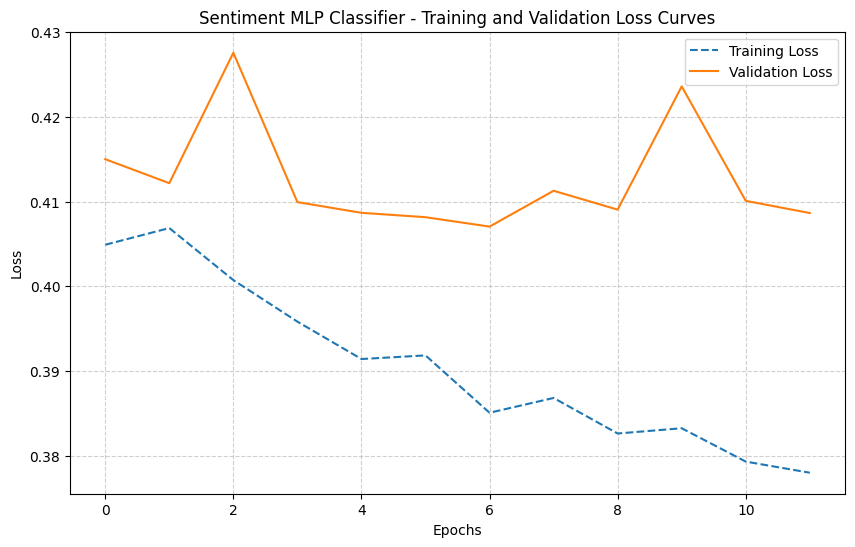


=== PER-CLASS METRICS ===
Class     Split     Precision   Recall      F1          PR-AUC      
-----------------------------------------------------------------
0         Train     0.8478        0.8678        0.8577        0.9326
0         Dev       0.8047        0.8284        0.8164        0.9002
0         Test      0.7940        0.8244        0.8089        0.8907
-----------------------------------------------------------------
1         Train     0.8652        0.8448        0.8548        0.9332
1         Dev       0.8216        0.7972        0.8092        0.8909
1         Test      0.8174        0.7861        0.8015        0.8882
-----------------------------------------------------------------

=== MACRO-AVERAGED METRICS ===
Split     Accuracy    Precision   Recall      F1          PR-AUC      
-----------------------------------------------------------------
Train     0.8563        0.8565        0.8563        0.8563        0.9329
Dev       0.8129        0.8131        0.8128      

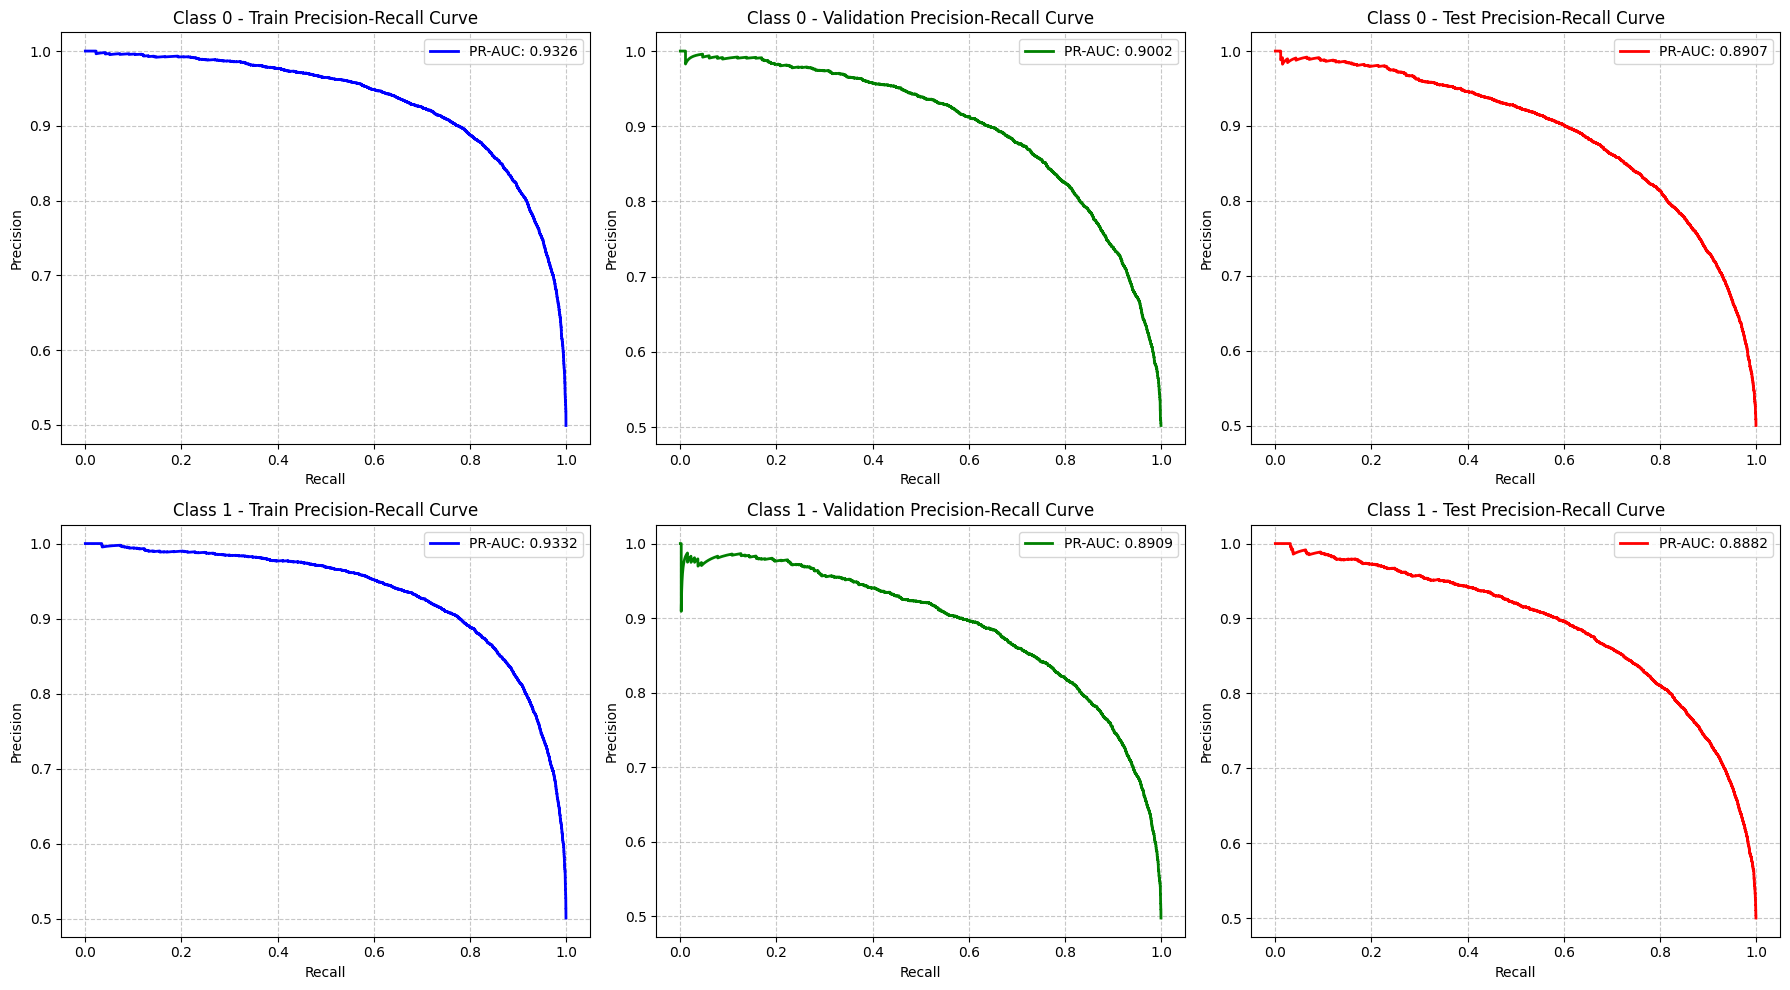

In [41]:
# Plot loss curves
plot_loss_curves(train_losses, val_losses, title="Sentiment MLP Classifier")

# Get detailed evaluation metrics
all_metrics = evaluate_model_detailed(model, train_loader, val_loader, test_loader)

**Observations**: The model using pre-trained word embeddings shows several interesting patters compared to previous approaches:
  1. Surprisingly, the pre-trained embeddings model performs noticeably worse than both the simpler Bag of Words approach and the TfIdf vectorizer implementation.
  2. There's a slight imbalance in performance between the two sentiment classes, with negative sentiment class showing somewhat better recall than positive sentiment.
  3. The difference between training and test performance is less dramatic than with the Bag of Words model, suggesting better generalization despite lower overall performance.
  4. The performance drop is consistent across all metrics, indicating fundamental limitation rather than a problem with specific aspects of classification.

In [42]:
# Create the comparison structures
models_comparison = {
    'Baseline': baseline_metrics,
    'MLP Classifier': all_metrics
}

# Print comparison table for test set
print("\n=== MODEL COMPARISON (TEST SET) ===")
print(f"{'Model':<20}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1':<12}{'PR-AUC':<12}")
print("-" * 75)

for model_name, metrics in models_comparison.items():
    # Access test metrics based on the different structures
    if model_name == 'Baseline':
        test_metrics = metrics['test']
    else:  # MLP Classifier
        test_metrics = metrics['test']['macro']  # The MLP metrics have a nested 'macro' key

    print(f"{model_name:<20}{test_metrics['accuracy']:.4f}{' '*8}{test_metrics['macro_precision']:.4f}{' '*8}{test_metrics['macro_recall']:.4f}{' '*8}{test_metrics['macro_f1']:.4f}{' '*8}{test_metrics['macro_pr_auc']:.4f}")



=== MODEL COMPARISON (TEST SET) ===
Model               Accuracy    Precision   Recall      F1          PR-AUC      
---------------------------------------------------------------------------
Baseline            0.5031        0.6934        0.5031        0.3411        0.7225
MLP Classifier      0.8053        0.8057        0.8053        0.8052        0.8895
